<img src="header.jpg" />

# Imports

# Imports

In [1]:
# Math & data
import numpy as np
import pandas as pd
from datetime import date
import itertools

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

import copy

c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from collections import Counter

In [3]:
# Pre-processing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Feature selection
from sklearn.model_selection import GridSearchCV, KFold

# ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, SVMSMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [4]:
import joblib

In [5]:
import re

In [6]:
# Modules perso
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [7]:
import DisplotData, DisplotML, PwePwocess, Funktiuns
from DisplotData import bcolors
import MLstuff

In [8]:
pd.set_option("display.max_columns", 150) # None

# Noyau Kaggle

# Kaggle core

## Fonctions

## Functions

### Preprocessing

### Preprocessing

In [9]:
def transform_operations(row):
    if Funktiuns.isNaN(row):
        return row
    row = row.split(',')
    return row

In [10]:
# Display/plot feature importance
def display_importances(feature_importance_df_, n_feat=40, algo_name=''):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:n_feat].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    result = best_features[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    plt.figure()
    # sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    sns.barplot(x="importance", y="feature", data=best_features, order=result)

    plt.title(f'{algo_name} features')
    plt.tight_layout()
    plt.savefig(f'{algo_name}_importances.png')

In [11]:
def keep_selected_cols(df, selected_features, table_name=''):
    if not selected_features is None:
        kept_cols = selected_features.loc[selected_features['Table'].str.startswith(table_name), 'Row'].values
        efc_kept_cols = [c for c in df.columns if c in kept_cols]
        df = df[efc_kept_cols]
    return df


def rename_non_relaxable_cat_cols(df, selected_features, cat_cols, suffix='_NR', sep='__'):
    # print(f"df.columns AVANT = {df.columns}")
    new_cat_cols = cat_cols
    if not selected_features is None:
        new_cat_cols = []
        non_relaxable_cols = selected_features.loc[selected_features['Non-relaxable']==1, 'Row'].values
        # print(f"non_relaxable_cols = {non_relaxable_cols}")
        # print(f"cat_cols = {cat_cols}")
        for col_enc in cat_cols:
            # print(f"col_enc = {col_enc}")
            col = col_enc.split(sep)[0]
            # print(f"col = {col}")
            if col in non_relaxable_cols: # and col_enc in df.columns
                col_enc2 = col_enc+suffix
                # print(f"col_enc2 = {col_enc2}")
                new_cat_cols.append(col_enc2)
                df.rename(columns={col_enc: col_enc2}, inplace=True)
            else:
                new_cat_cols.append(col_enc)
    # print(f"df.columns APRES = {df.columns}")
    return df, new_cat_cols

def rename_non_relaxable_num_cols(df, selected_features, suffix='_NR', sep1='%', sep2='#'):
    new_num_cols = []
    num_cols = [col for col in df.columns if df[col].dtype != 'object']
    if not selected_features is None:
        non_relaxable_cols = selected_features.loc[selected_features['Non-relaxable']==1, 'Row'].values
        # print(f"non_relaxable_cols = {non_relaxable_cols}")
        # print(f"num_cols = {num_cols}")
        for col_agg in num_cols:
            # print(f"col_agg = {col_agg}")
            root_feat = col_agg
            if sep1 in root_feat:
                root_feat = root_feat.split(sep1)[1]
            if sep2 in root_feat:
                root_feat = root_feat.split(sep2)[0]
            # print(f"root_feat = {root_feat}")
            if root_feat in non_relaxable_cols: # and col_agg in df.columns
                col_agg2 = col_agg+suffix
                # print(f"col2 = {col2}")
                new_num_cols.append(col_agg2)
                df.rename(columns={col_agg: col_agg2}, inplace=True)
            else:
                new_num_cols.append(col_agg)
    # print(f"df.columns APRES = {df.columns}")
    return df, new_num_cols
    
def get_aggregations_for_root_var(num_cols, selected_features, table_name='', sep1='%', sep2='#'):
    aggregations = {}
    if not selected_features is None:
        # aggregations = {'MONTHS_BALANCE': ops} y sera !
        for col in num_cols:
            root_feat = col
            if sep1 in root_feat:
                root_feat = root_feat.split(sep1)[1]
            if sep2 in root_feat:
                root_feat = root_feat.split(sep2)[0]
            ops = selected_features.loc[(selected_features['Table'].str.startswith(table_name)) & (selected_features['Row']==root_feat), 'Operations'].values
            # print(root_feat, ops) # DEBUG
            if len(ops): 
                aggregations[col] = ops[0]
    
    return aggregations

In [12]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True, prefix_sep='_'):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category, prefix_sep=prefix_sep)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv
def application_train_test(selected_features=None, num_rows=None, nan_as_category=False):
    # Read data and merge
    # df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
    df = df_application_train[0:num_rows]
    # test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
    test_df = df_application_test[0:num_rows]
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Keep only wished cols, if they are specified
    df = keep_selected_cols(df, selected_features, table_name='application_{train|test}.csv')    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']: # comme étape du ColumnTransformer
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category, prefix_sep='__')
    
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    df, cat_cols = rename_non_relaxable_cat_cols(df, selected_features, cat_cols)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    df, num_cols = rename_non_relaxable_num_cols(df, selected_features)
    del test_df
    gc.collect()
    return df, cat_cols


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(selected_features=None, num_rows=None, nan_as_category=True):
    # bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bureau = df_bureau # global
    # bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb = df_bureau_balance # global
    # Keep only wished cols, if they are specified
    bureau = keep_selected_cols(bureau, selected_features, table_name='bureau.csv')
    bb = keep_selected_cols(bb, selected_features, table_name='bureau_balance.csv')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category, prefix_sep='__')
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category, prefix_sep='__')    
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    bb, bb_cat = rename_non_relaxable_cat_cols(bb, selected_features, bb_cat)
    bureau, bureau_cat = rename_non_relaxable_cat_cols(bureau, selected_features, bureau_cat)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {}
    # Numerical
    if not selected_features is None:
        num_cols = list(set(bb.columns)-set(bb_cat)-set(['SK_ID_CURR', 'SK_ID_BUREAU']))
        bb_aggregations = get_aggregations_for_root_var(num_cols, selected_features, table_name='bureau.csv', sep1='%', sep2='#')
    else:
        bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    # Categorical
    for col in bb_cat:
        bb_aggregations[col] = ['mean'] # TODO : récupérer les opérations souhaitées pour la feature racine

    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "#" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    if not selected_features is None:
        bb_num = list(set(bureau.columns)-set(bureau_cat)-set(bb_cat)-set(['SK_ID_CURR', 'SK_ID_BUREAU']))
        num_aggregations = get_aggregations_for_root_var(bb_num, selected_features, table_name='bureau', sep1='%', sep2='#')
    else:
        num_aggregations = {
            'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
            'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
            'DAYS_CREDIT_UPDATE': ['mean'],
            'CREDIT_DAY_OVERDUE': ['max', 'mean'],
            'AMT_CREDIT_MAX_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
            'AMT_ANNUITY': ['max', 'mean'],
            'CNT_CREDIT_PROLONG': ['sum'],
            'MONTHS_BALANCE#MIN': ['min'],
            'MONTHS_BALANCE#MAX': ['max'],
            'MONTHS_BALANCE#SIZE': ['mean', 'sum']
        }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "#MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO%' + e[0] + "#" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    if 'CREDIT_ACTIVE__Active_NR' in bureau.columns:
        active = bureau[bureau['CREDIT_ACTIVE__Active_NR'] == 1]
    else:
        active = bureau[bureau['CREDIT_ACTIVE__Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE%' + e[0] + "#" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    if 'CREDIT_ACTIVE__Closed_NR' in bureau.columns:
        closed = bureau[bureau['CREDIT_ACTIVE__Closed_NR'] == 1]
    else:
        closed = bureau[bureau['CREDIT_ACTIVE__Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED%' + e[0] + "#" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    bureau_agg, num_cols = rename_non_relaxable_num_cols(bureau_agg, selected_features)
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg, bb_cat, bureau_cat

# Preprocess previous_applications.csv
def previous_applications(selected_features=None, num_rows=None, nan_as_category=True):
    # prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev = df_previous_application # global
    # Keep only wished cols, if they are specified
    prev = keep_selected_cols(prev, selected_features, table_name='previous_application.csv')
    prev, prev_cat_cols = one_hot_encoder(prev, nan_as_category= True, prefix_sep='__')
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    prev, prev_cat_cols = rename_non_relaxable_cat_cols(prev, selected_features, prev_cat_cols)
    # Days 365.243 values -> nan
    if 'DAYS_FIRST_DRAWING' in prev.columns: prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    if 'DAYS_FIRST_DUE' in prev.columns: prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    if 'DAYS_LAST_DUE_1ST_VERSION' in prev.columns: prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    if 'DAYS_LAST_DUE' in prev.columns: prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    if 'DAYS_TERMINATION' in prev.columns: prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    if 'AMT_APPLICATION' in prev.columns and 'AMT_CREDIT' in prev.columns: 
        prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
        prev.loc[prev['APP_CREDIT_PERC']>1.e300] = 1. # CG
    # Previous applications numeric features
    if not selected_features is None:
        col_list = ['AMT_ANNUITY',
                    'AMT_APPLICATION',
                    'AMT_CREDIT',
                    'APP_CREDIT_PERC',
                    'AMT_DOWN_PAYMENT',
                    'AMT_GOODS_PRICE',
                    'HOUR_APPR_PROCESS_START',
                    'RATE_DOWN_PAYMENT',
                    'DAYS_DECISION',
                    'CNT_PAYMENT']
        num_aggregations = get_aggregations_for_root_var(col_list, selected_features, table_name='previous_application.csv', sep1='%', sep2='#')
        num_aggregations['APP_CREDIT_PERC'] = ['min', 'max', 'mean', 'var'] # Ad hoc
        
        cat_aggregations = get_aggregations_for_root_var(prev_cat_cols, selected_features, table_name='previous_application.csv', sep1='%', sep2='#')
    else:
        num_aggregations = {}
        if 'AMT_ANNUITY' in prev.columns: num_aggregations['AMT_ANNUITY'] = ['min', 'max', 'mean'] # TODO : fonction à partir du dico ci-dessus
        if 'AMT_APPLICATION' in prev.columns: num_aggregations['AMT_APPLICATION'] = ['min', 'max', 'mean']
        if 'AMT_CREDIT' in prev.columns: num_aggregations['AMT_CREDIT'] = ['min', 'max', 'mean']
        if 'APP_CREDIT_PERC' in prev.columns: num_aggregations['APP_CREDIT_PERC'] = ['min', 'max', 'mean', 'var']
        if 'AMT_DOWN_PAYMENT' in prev.columns: num_aggregations['AMT_DOWN_PAYMENT'] = ['min', 'max', 'mean']
        if 'AMT_GOODS_PRICE' in prev.columns: num_aggregations['AMT_GOODS_PRICE'] = ['min', 'max', 'mean']
        if 'HOUR_APPR_PROCESS_START' in prev.columns: num_aggregations['HOUR_APPR_PROCESS_START'] = ['min', 'max', 'mean']
        if 'RATE_DOWN_PAYMENT' in prev.columns: num_aggregations['RATE_DOWN_PAYMENT'] = ['min', 'max', 'mean']
        if 'DAYS_DECISION' in prev.columns: num_aggregations['DAYS_DECISION'] = ['min', 'max', 'mean']
        if 'CNT_PAYMENT' in prev.columns: num_aggregations['CNT_PAYMENT'] = ['mean', 'sum']
        # Previous applications categorical features
        cat_aggregations = {}
        for cat in prev_cat_cols:
            cat_aggregations[cat] = ['mean'] # Donc le OneHot devient non-entier
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV%' + e[0] + "#" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    if 'NAME_CONTRACT_STATUS__Approved_NR' in prev.columns:
        approved = prev[prev['NAME_CONTRACT_STATUS__Approved_NR'] == 1]
    else:
        approved = prev[prev['NAME_CONTRACT_STATUS__Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED%' + e[0] + "#" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    if 'NAME_CONTRACT_STATUS__Refused_NR' in prev.columns:
        refused = prev[prev['NAME_CONTRACT_STATUS__Refused_NR'] == 1]
    else:
        refused = prev[prev['NAME_CONTRACT_STATUS__Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED%' + e[0] + "#" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    prev_agg, num_cols = rename_non_relaxable_num_cols(prev_agg, selected_features)
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg, prev_cat_cols

# Preprocess POS_CASH_balance.csv
def pos_cash(selected_features=None, num_rows=None, nan_as_category=True):
    # pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos = df_POS_CASH_balance # global
    # Keep only wished cols, if they are specified
    pos = keep_selected_cols(pos, selected_features, table_name='POS_CASH_balance.csv')
    pos, pos_cat_cols = one_hot_encoder(pos, nan_as_category=True, prefix_sep='__')
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    pos, pos_cat_cols = rename_non_relaxable_cat_cols(pos, selected_features, pos_cat_cols)

    # Features
    if not selected_features is None:
        col_list = ['MONTHS_BALANCE',
                    'SK_DPD',
                    'SK_DPD_DEF'] + pos_cat_cols
        aggregations = get_aggregations_for_root_var(col_list, selected_features, table_name='POS_CASH_balance.csv', sep1='%', sep2='#')
    else:
        aggregations = {}
        if 'MONTHS_BALANCE' in pos.columns: aggregations['MONTHS_BALANCE'] = ['max', 'mean', 'size']
        if 'SK_DPD' in pos.columns: aggregations['SK_DPD'] = ['max', 'mean']
        if 'SK_DPD_DEF' in pos.columns: aggregations['SK_DPD_DEF'] = ['max', 'mean']
        for cat in pos_cat_cols:
            aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS%' + e[0] + "#" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS%COUNT_NR'] = pos.groupby('SK_ID_CURR').size()
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    pos_agg, num_cols = rename_non_relaxable_num_cols(pos_agg, selected_features)
    del pos
    gc.collect()
    return pos_agg, pos_cat_cols
    
# Preprocess installments_payments.csv
def installments_payments(selected_features=None, num_rows=None, nan_as_category=True):
    # ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins = df_installments_payments # global
    # Keep only wished cols, if they are specified
    ins = keep_selected_cols(ins, selected_features, table_name='installments_payments.csv')
    ins, ins_cat_cols = one_hot_encoder(ins, nan_as_category=True, prefix_sep='__')
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    ins, ins_cat_cols = rename_non_relaxable_cat_cols(ins, selected_features, ins_cat_cols)
    # Percentage and difference paid in each installment (amount paid and installment value)
    if 'AMT_PAYMENT' in ins.columns and 'AMT_INSTALMENT' in ins.columns: 
        ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
        ins.loc[ins['PAYMENT_PERC']>1.e300] = 1. # CG
        ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    if 'DAYS_ENTRY_PAYMENT' in ins.columns and 'DAYS_INSTALMENT' in ins.columns:
        ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
        ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    if 'DAYS_INSTALMENT' in ins.columns and 'DAYS_ENTRY_PAYMENT' in ins.columns: 
        ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
        ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    col_list = ['NUM_INSTALMENT_VERSION',
                'DPD',
                'DBD',
                'PAYMENT_PERC',
                'PAYMENT_DIFF',
                'AMT_INSTALMENT',
                'AMT_PAYMENT',
                'DAYS_ENTRY_PAYMENT'] + ins_cat_cols
    if not selected_features is None:
        aggregations = get_aggregations_for_root_var(col_list, selected_features, table_name='installments_payments.csv', sep1='%', sep2='#')
    else:
        aggregations = {}
        if 'NUM_INSTALMENT_VERSION' in ins.columns: aggregations['NUM_INSTALMENT_VERSION'] = ['nunique']
        if 'AMT_INSTALMENT' in ins.columns: aggregations['AMT_INSTALMENT'] = ['max', 'mean', 'sum']
        if 'AMT_PAYMENT' in ins.columns: aggregations['AMT_PAYMENT'] = ['min', 'max', 'mean', 'sum']
        if 'DAYS_ENTRY_PAYMENT' in ins.columns: aggregations['DAYS_ENTRY_PAYMENT'] = ['max', 'mean', 'sum']
        for cat in ins_cat_cols:
            aggregations[cat] = ['mean']
    # Dans tous les cas
    if 'DPD' in ins.columns: aggregations['DPD'] = ['max', 'mean', 'sum']
    if 'DBD' in ins.columns: aggregations['DBD'] = ['max', 'mean', 'sum']
    if 'PAYMENT_PERC' in ins.columns: aggregations['PAYMENT_PERC'] = ['max', 'mean', 'sum', 'var']
    if 'PAYMENT_DIFF' in ins.columns: aggregations['PAYMENT_DIFF'] = ['max', 'mean', 'sum', 'var']
            
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL%' + e[0] + "#" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL%COUNT_NR'] = ins.groupby('SK_ID_CURR').size()
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    ins_agg, num_cols = rename_non_relaxable_num_cols(ins_agg, selected_features)
    del ins
    gc.collect()
    return ins_agg, ins_cat_cols

# Preprocess credit_card_balance.csv
def credit_card_balance(selected_features=None, num_rows=None, nan_as_category=True):
    # cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc = df_credit_card_balance # global
    # Keep only wished cols, if they are specified
    cc = keep_selected_cols(cc, selected_features, table_name='credit_card_balance.csv')
    cc, cc_cat_cols = one_hot_encoder(cc, nan_as_category=True, prefix_sep='__')
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    cc, cc_cat_cols = rename_non_relaxable_cat_cols(cc, selected_features, cc_cat_cols)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    if not selected_features is None:
        col_list = list(set(cc.columns)-set(['SK_ID_CURR']))
        aggregations = get_aggregations_for_root_var(col_list, selected_features, table_name='credit_card_balance.csv', sep1='%', sep2='#')
        # print(f"credit_card_balance: aggregations = {aggregations}")
        cc_agg = cc.groupby('SK_ID_CURR').agg(aggregations)
    else:
        cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
        
    cc_agg.columns = pd.Index(['CC%' + e[0] + "#" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC%COUNT_NR'] = cc.groupby('SK_ID_CURR').size()
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    cc_agg, num_cols = rename_non_relaxable_num_cols(cc_agg, selected_features)
    del cc
    gc.collect()
    return cc_agg, cc_cat_cols

In [13]:
def read_feature_selection(file, min_level=2, delimiter=';'):
    """Lecture des features sélectionnées dans un fichier."""
    df_selected_features = pd.read_csv(file, delimiter=delimiter)
    df_selected_features = df_selected_features.loc[df_selected_features['Interet']>=min_level]
    # operations = df_selected_features.loc[df_selected_features['Interet']>=min_level, 'Operations'].values
    df_selected_features['Operations'] = df_selected_features['Operations'].apply(transform_operations)
    return df_selected_features #, operations

In [14]:
def preprocess(selected_features=None, debug=False, num_rows=None):
    num_rows = 3000 if debug else num_rows
    df, cat_cols = application_train_test(selected_features, num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau, bb_cat, bureau_cat = bureau_and_balance(selected_features, num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        cat_cols += bb_cat + bureau_cat
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev, prev_cat_cols = previous_applications(selected_features, num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        cat_cols += prev_cat_cols
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos, pos_cat_cols = pos_cash(selected_features, num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        cat_cols += pos_cat_cols
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins, ins_cat_cols = installments_payments(selected_features, num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        cat_cols += ins_cat_cols
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc, cc_cat_cols = credit_card_balance(selected_features, num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        cat_cols += cc_cat_cols
        del cc
        gc.collect()

    with timer("Create new variables"):
        df = create_cnt_payment(df)
        
    cat_cols = [c for c in cat_cols if c not in ['TARGET']]
    num_cols = list(set(df.columns) - set(cat_cols) - set(['TARGET']))

    return df, cat_cols, num_cols

def main(debug=False, num_rows=None):
    df_prep, cat_cols, num_cols = preprocess(debug, num_rows)

    with timer("Run LightGBM with kfold"):
        # feat_importance, train_df, test_df = kfold_lightgbm(df, n_folds=10, stratified=True, debug=debug)
        feat_importance, train_df, test_df = kfold_randomforest(df, n_folds=10, stratified=True, debug=debug)
    return feat_importance, train_df, test_df

In [15]:
def create_cnt_payment(df, nb_work_samples=20000):
    """Estimation de la durée du prêt demandé."""
    # Matrice de travail 
    Xy = df_previous_application[['AMT_CREDIT', 'AMT_ANNUITY', 'CNT_PAYMENT']]
    # Occurrences des durées
    cnt_occ = Xy['CNT_PAYMENT'].value_counts(normalize=True)
    # Certaines durées sont très rares, on les supprime avant la classification
    rare_vals = cnt_occ.loc[cnt_occ<1.e-4].index.tolist()
    Xy = Xy.loc[~Xy['CNT_PAYMENT'].isin(rare_vals)]
    # Suppression des lignes contenant des NaN
    Xy = Xy.dropna(axis=0).sample(nb_work_samples) # 20000 Suffira à inférer CNT_PAYMENT
    X = Xy[['AMT_CREDIT', 'AMT_ANNUITY']]
    y = Xy['CNT_PAYMENT']
    encoder = LabelEncoder()
    encoder.fit(y) # pas bien
    y_enc = encoder.transform(y)
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2) # , stratify=y_enc
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    y_train_enc = y_train
    y_test_enc = y_test
    # Modèle de classification
    mdl = XGBClassifier() # Pas besoin de l'hyperparamétrer, la variable est juste estimée
    mdl.fit(X_train_sc, y_train_enc)
    y_train_pred = mdl.predict(X_train_sc)
    y_test_pred = mdl.predict(X_test_sc)
    # Affichages
    print(f"create_cnt_payment: train score = {accuracy_score(y_train_pred, y_train_enc):.3f}")
    print(f"create_cnt_payment: test score  = {accuracy_score(y_test_pred, y_test_enc):.3f}")
    # Création de la variable 'CNT_PAYMENT_NR' dans les données 
    X_sc = scaler.transform(df[['AMT_CREDIT', 'AMT_ANNUITY']])
    y_pred_enc = mdl.predict(X_sc)
    y_pred = encoder.inverse_transform(y_pred_enc)
    df['CNT_PAYMENT_NR'] = y_pred
    return df

### Algorithmes

### Algorithms

In [16]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, n_folds, stratified = False, debug= False):
    # CG : correction nom de features qui crashe LGBM
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= n_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    s_moy = []
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        params = {
            'nthread': 4,
            'n_estimators': 10000,
            'learning_rate': 0.02,
            'num_leaves': 34,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 39.3259775,
            'verbose': -1,
            'silent': -1,
        }
        callbacks = [early_stopping(stopping_rounds=200, verbose=0)] #, lgb.log_evaluation(period=0)
        # clf = LGBMClassifier(params)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
            # eval_metric= 'auc', verbose= 200, callbacks=callbacks)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        s = roc_auc_score(valid_y, oof_preds[valid_idx])
        s_moy.append(s)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, s))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full train AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    print('Full test  AUC score %.6f' % np.array(s_moy).mean())
    print("Alors, c'est pareil, hein ?")
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df, n_feat=200, algo_name='LightGBM')
    return feature_importance_df, train_df, test_df

In [17]:
# RandomForest with KFold or Stratified KFold
def kfold_algo(df, cat_cols, num_cols, n_folds, algo_name='RandomForest',stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting {algo_name}. Train shape: {train_df.shape}, test shape: {test_df.shape}")
    del df
    gc.collect()

    # Cross validation model
    # if stratified:
    #     folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1001)
    # else:
    #     folds = KFold(n_splits=n_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    # oof_preds = np.zeros(train_df.shape[0])
    # sub_preds = np.zeros(test_df.shape[0])
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    cat_cols = [f for f in cat_cols if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # TODO: SALE
    num_cols = [f for f in num_cols if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # TODO: SALE
    
    # Parameters
    if algo_name=='RandomForest':
        algo = RandomForestClassifier()
        param_grid = {
            'n_estimators': [200, 500], #[20, 50, 100, 200]
            'max_depth': [None, 2], #[None, 1, 2, 5],
            'min_samples_split': [2, 5], #[2, 5, 10],
            }
    elif algo_name=='XGBoost':
        algo = XGBClassifier()
        param_grid = {
            'n_estimators': [500],
            'max_depth': [5],
            'colsample_bytree': [0.8],
            'nthread': [10],
            'learning_rate': [0.05],
            'random_state': [18011975],
            }

    # Split train/test
    X = train_df[feats]
    y = train_df['TARGET']
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=18011975, stratify=y)

    # categorical_columns = [] #[col for col in df.columns if df[col].dtype == 'object']
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), ("scaler", StandardScaler())] # strategy="median"
    )
    # categorical_transformer = OneHotEncoder(handle_unknown="ignore") # Déjà OneHotEncodé, et les NaN remplacés à 1 pour la catég _nan
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, feats), #num_cols
            # ("cat", categorical_transformer, cat_cols),
        ]
    )
    preprocessor.fit(train_x)
    train_x_enc = preprocessor.transform(train_x)
    test_x_enc = preprocessor.transform(test_x)
    
    # New 18/11/2022 :
    stratified_kfold = StratifiedKFold(n_splits=n_folds,
                                       shuffle=True,
                                       random_state=18011975)
    
    print(f"X = {train_x_enc}")
    print(f"X.sum.sum = {train_x_enc.sum().sum()}")
    print(f"y = {train_y}")
    clf = GridSearchCV(
        algo, param_grid=param_grid,
#         cv=n_folds,
        cv=stratified_kfold,
        scoring='roc_auc',
        n_jobs=-1)
    clf.fit(train_x_enc, train_y)


    # oof_preds = clf.best_estimator_.predict_proba(test_x)[:, 1]
    y_train_pred = clf.best_estimator_.predict_proba(train_x_enc)[:, 1]
    y_test_pred = clf.best_estimator_.predict_proba(test_x_enc)[:, 1]
    # sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    print(f"y_train_pred = {y_train_pred}")
    print(f"y_test_pred = {y_test_pred}")
    
    # fold_importance_df = pd.DataFrame()
    # fold_importance_df["feature"] = feats
    # fold_importance_df["importance"] = clf.feature_importances_
    # fold_importance_df["fold"] = n_fold + 1
    # feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    feature_importance_df = pd.DataFrame()
    feature_importance_df["feature"] = feats
    feature_importance_df["importance"] = clf.best_estimator_.feature_importances_
    
    del clf
    gc.collect()

    print('Train AUC score %.6f' % roc_auc_score(train_y, y_train_pred))
    print('Test  AUC score %.6f' % roc_auc_score(test_y, y_test_pred))
    # Write submission file and plot feature importance
    if not debug:
        # test_df['TARGET'] = sub_preds
        # test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
        pass
    display_importances(feature_importance_df, n_feat=200, algo_name=algo_name)
    return feature_importance_df, train_df, test_df

# Chargement des données

# Loading data

In [18]:
data_dir = "../data/"

In [19]:
df_application_train = pd.read_csv(data_dir+'application_train.csv')
df_application_test = pd.read_csv(data_dir+'application_test.csv')

In [20]:
df_bureau = pd.read_csv(data_dir+'bureau.csv')
df_bureau_balance = pd.read_csv(data_dir+'bureau_balance.csv')
df_credit_card_balance = pd.read_csv(data_dir+'credit_card_balance.csv')
df_installments_payments = pd.read_csv(data_dir+'installments_payments.csv')
df_POS_CASH_balance = pd.read_csv(data_dir+'POS_CASH_balance.csv')
df_previous_application = pd.read_csv(data_dir+'previous_application.csv')

# Exploration des données

# Data mining

## Variables initiales

## Initial variables

<img src="home_credit.png" />

### Description des colonnes

```
- **application_{train|test}.csv**

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

 - **bureau.csv**

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

 - **bureau_balance.csv**

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

 - **POS_CASH_balance.csv**

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

 - **credit_card_balance.csv**

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

 - **previous_application.csv**

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

 - **installments_payments.csv**

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

 - **HomeCredit_columns_description.csv**

This file contains descriptions for the columns in the various data files.
```

 - **application_{train|test}.csv**

Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

 - **bureau.csv**

Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

 - **bureau_balance.csv**

Soldes mensuels des crédits antérieurs au bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes.

 - **POS_CASH_balance.csv**

Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

 - **credit_card_balance.csv**

Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

 - **previous_application.csv**

Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

 - **installments_payments.csv**

Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

 - **HomeCredit_columns_description.csv**

Ce fichier contient les descriptions des colonnes des différents fichiers de données.


In [21]:
df_application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [22]:
df_application_train.tail()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
307506  Secondary / secondary special          Separated       With parents   
307507  Secondary / secondary special              Widow  House / apartment   
307508               Higher education          Separated  House / apartment   
307509  Secondary / secondary special            Married  House / apartment   
307510               Higher education            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
307506                    0.032561       -9327           -236   
307507                    0.025164      -20775         365243   
307508                    0.005002      -14966          -7921   
307509                    0.005313      -11961          -4786   
307510                    0.046220      -16856          -1262   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
307506            -8456.0            -1982          NaN           1   
307507            -4388.0            -4090          NaN           1   
307508            -6737.0            -5150          NaN           1   
307509            -2562.0             -931          NaN           1   
307510            -5128.0             -410          NaN           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
307506               1                0                 1           0   
307507               0                0                 1           1   
307508               1                0                 1           0   
307509               1                0                 1           0   
307510               1                1                 1           1   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
307506           0     Sales staff              1.0                     1   
307507           0             NaN              1.0                     2   
307508           1        Managers              1.0                     3   
307509           0        Laborers              2.0                     2   
307510           0        Laborers              2.0                     1   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
307506                            1                   THURSDAY   
307507                            2                     MONDAY   
307508                            3                   THURSDAY   
307509                            2                  WEDNESDAY   
307510                            1                   THURSDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
307506            

In [23]:
df_application_train[['AMT_ANNUITY', 'AMT_CREDIT']]

AMT_ANNUITY  AMT_CREDIT
0           24700.5    406597.5
1           35698.5   1293502.5
2            6750.0    135000.0
3           29686.5    312682.5
4           21865.5    513000.0
...             ...         ...
307506      27558.0    254700.0
307507      12001.5    269550.0
307508      29979.0    677664.0
307509      20205.0    370107.0
307510      49117.5    675000.0

[307511 rows x 2 columns]

In [24]:
df_application_train['AMT_ANNUITY'] / df_application_train['AMT_CREDIT']

0         0.060749
1         0.027598
2         0.050000
3         0.094941
4         0.042623
            ...   
307506    0.108198
307507    0.044524
307508    0.044239
307509    0.054592
307510    0.072767
Length: 307511, dtype: float64

In [25]:
df_application_train.shape

(307511, 122)

In [26]:
df_application_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [27]:
df_application_test.tail()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
48739         270000.0   Unaccompanied               Working   
48740         495000.0   Unaccompanied  Commercial associate   
48741         315000.0   Unaccompanied  Commercial associate   
48742         450000.0          Family  Commercial associate   
48743         270000.0   Unaccompanied               Working   

                 NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
48739  Secondary / secondary special              Widow  House / apartment   
48740  Secondary / secondary special            Married  House / apartment   
48741  Secondary / secondary special            Married  House / apartment   
48742               Higher education            Married  House / apartment   
48743  Secondary / secondary special            Married  House / apartment   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
48739                    0.002042      -19970          -5169   
48740                    0.035792      -11186          -1149   
48741                    0.026392      -15922          -3037   
48742                    0.018850      -13968          -2731   
48743                    0.006629      -13962           -633   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
48739            -9094.0            -3399          NaN           1   
48740            -3015.0            -3003          NaN           1   
48741            -2681.0            -1504          4.0           1   
48742            -1461.0            -1364          NaN           1   
48743            -1072.0            -4220         22.0           1   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
48739               1                1                 1           1   
48740               1                0                 1           0   
48741               1                0                 1           1   
48742               1                1                 1           1   
48743               1                1                 1           0   

       FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
48739           0             NaN              1.0                     3   
48740           0     Sales staff              4.0                     2   
48741           0             NaN              3.0                     2   
48742           0        Managers              2.0                     2   
48743           0      Core staff              2.0                     2   

       REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
48739                            3                  WEDNESDAY   
48740                            2                     MONDAY   
48741                            2                  WEDNESDAY   
48742                            2                     MONDAY   
48743                            2                    TUESDAY   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
48739                       16                           0   
48740                       11                           0

In [28]:
df_application_test.shape

(48744, 121)

In [29]:
456222 in df_bureau['SK_ID_CURR'].values

False

In [30]:
456253 in df_bureau['SK_ID_CURR'].values

True

OK donc la target est sur les **difficultés de paiement*(1: oui, 0: non), càd plus de X jours de retard sur les Y premières échéances.
Infos : 
 - client possède une voiture
 - client possède un appartement ou une maison
 - prix des biens pour un prêt à la consommation
 - Qui accompagnait le client lors de sa demande de prêt ?!
 - NAME_HOUSING_TYPE : type de logement actuel du client (locataire, vivant avec les parents...)
 - DAYS_REGISTRATION : Combien de jours avant la demande le client a-t-il modifié son inscription ?!
 - DAYS_ID_PUBLISH : Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt
 - Age de la voiture du client !!
 - FLAG_CONT_MOBILE : le portable a pû être joint !!
 - Score de région du client (par l'organisme de prêt) !
 - Quel jour de la semaine le client a-t-il demandé le prêt !!
 - A quelle heure dans le jour le client a-t-il demandé le prêt !!
 - Score en provenance d'autres sources (3 possibles), normalisé
 - Lieu de vie du client : taille de l'appartement, aire commune, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées, état de l'immeuble, nombre d'étages
 - Combien d'observations de l'environnement social du client avec un défaut observable de 30 DPD (jours de retard) ?!
 - Combien d'observations de l'environnement social du client ont manqué 30 DPD (jours de retard) ?
 - Nombre de jours entre le changement de téléphone portable du client et la demande de prêt ?!
 - Nombre de demandes de renseignements au bureau de crédit au sujet du client une heure/mois/trimestre/année avant la demande (moins une période de marge)
 - CC : Montant tiré au cours du mois du crédit précédent
 - CC : Montant des autres tirages au cours du mois du crédit précédent
 - CC : Nombre de tirages au guichet automatique durant ce mois sur le crédit précédent
 - PA : AMT_DOWN_PAYMENT : Acompte sur la demande précédente (Down payment on the previous application)
 - PA : Par rapport à la demande actuelle, quand la décision concernant la demande précédente a-t-elle été prise
 - PA : Le client était-il un ancien ou un nouveau client lors de la demande précédente ?
 - PA : Par rapport à la date d'application de l'application actuelle, à quand remonte le premier décaissement de l'application précédente
 - IP : Version du calendrier des versements (0 pour carte de crédit) du crédit précédent. Le changement de version de versement d'un mois à l'autre signifie que certains paramètres du calendrier de paiement ont changé
 - IP : Sur quel versement nous observons le paiement ?!
 - IP : **DAYS_ENTRY_PAYMENT : Quand les échéances du crédit précédent ont-elles été effectivement payées (par rapport à la date de demande du prêt en cours)**

In [31]:
df_application_train.shape

(307511, 122)

In [32]:
df_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [33]:
df_bureau.shape

(1716428, 17)

In [34]:
df_bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [35]:
df_bureau_balance.shape

(27299925, 3)

In [36]:
df_bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [37]:
df_credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [38]:
df_credit_card_balance.shape

(3840312, 23)

In [39]:
df_installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [40]:
df_installments_payments.shape

(13605401, 8)

In [41]:
df_POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [42]:
df_POS_CASH_balance.shape

(10001358, 8)

In [43]:
df_previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [44]:
df_previous_application.shape

(1670214, 37)

### Indicateur de prêt ouvert / fermé

`'DAYS_ENDDATE_FACT'` : permet de trier les prêts ouverts / fermés.

In [45]:
df_bureau['DAYS_ENDDATE_FACT'].notna().sum()

1082775

### Recherche d'un indicateur de dette

D'après la description des colonnes, la variable `AMT_CREDIT_SUM_OVERDUE` représente le montant en souffrance   

In [46]:
df_bureau.loc[(df_bureau['AMT_CREDIT_SUM_OVERDUE']>0)] \
    ['AMT_CREDIT_SUM_OVERDUE'].mean()

15650.437456709951

In [47]:
df_bureau.loc[(df_bureau['AMT_CREDIT_SUM_OVERDUE']==0)] \
    ['AMT_CREDIT_SUM'].mean()

354785.027854352

In [48]:
(df_previous_application['AMT_ANNUITY'] * df_previous_application['CNT_PAYMENT'] \
    - df_previous_application['AMT_CREDIT']).mean()

90897.82318068699

In [49]:
df_previous_application['CNT_PAYMENT'].max()

84.0

In [50]:
df_bureau.loc[(df_bureau['DAYS_ENDDATE_FACT'].notna()) & (df_bureau['AMT_CREDIT_SUM_OVERDUE']>0)] \
    [['SK_ID_BUREAU', 'AMT_CREDIT_SUM_OVERDUE']]

SK_ID_BUREAU  AMT_CREDIT_SUM_OVERDUE
9446          5725982                   585.0
17100         5190659                   220.5
33723         5804754                     9.0
43881         5214368                     9.0
46064         5217154                    54.0
...               ...                     ...
1628047       5567059                    36.0
1655616       6688027                     4.5
1679083       6654943                 63949.5
1696803       5560835                    76.5
1710139       5055833                   234.0

[157 rows x 2 columns]

In [51]:
df_bureau.loc[df_bureau['AMT_CREDIT_SUM_OVERDUE']>0][['SK_ID_BUREAU']].value_counts()

SK_ID_BUREAU
5000316         1
6204395         1
6192076         1
6192080         1
6192082         1
               ..
5610927         1
5613360         1
5613991         1
5614207         1
6842102         1
Length: 4158, dtype: int64

La variable `'AMT_CREDIT_SUM_OVERDUE'` nous permet donc d'estimer les pertes de la banque, et ce sans répétition de la même valeur. Pour les prêts fermés, cette somme s'élève à :

In [52]:
loss = df_bureau.loc[(df_bureau['DAYS_ENDDATE_FACT'].notna()) & (df_bureau['AMT_CREDIT_SUM_OVERDUE']>0)] \
    ['AMT_CREDIT_SUM_OVERDUE'].sum()
loss

2894184.7649999997

In [53]:
df_bureau.loc[df_bureau['AMT_CREDIT_SUM_OVERDUE']>0].shape[0]

4158

La perte moyenne d'un prêt avec incident est donc de :

In [54]:
mean_loss = loss / df_bureau.loc[df_bureau['AMT_CREDIT_SUM_OVERDUE']>0].shape[0]
mean_loss

696.052132034632

### Estimation de la durée de rembourseement

Il nous faut également calculer les gains associés à un prêt. On dispose pas de cette information directement. La variable `'AMT_ANNUITY'` donne le montant annuel de remboursement du client, pour les crédits en  cours. Mais pour ces mêmes crédits on n'a pas la durée de remboursement (en mois ou en années). Les anciens prêts portent cette information, avec la variable `'CNT_PAYMENT'`. Est-elle simplement fonction du montant du prêt ?

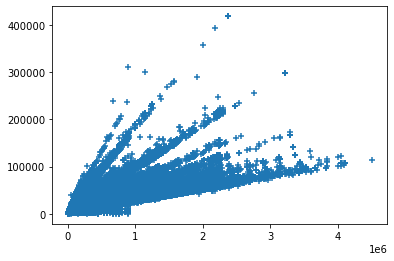

In [55]:
fig = plt.figure()
# plt.scatter(df_previous_application['AMT_CREDIT'], df_previous_application['CNT_PAYMENT'])
plt.scatter(df_previous_application['AMT_CREDIT'], df_previous_application['AMT_ANNUITY'], marker='+')

Pas vraiment, on a plusieurs "raies" de durée de paiement, en fonction du montant. On peut tenter de les **prédire**, à partir des informations sur les anciens crédits, par un algorithme de machine learning.

In [56]:
Xy = df_previous_application[['AMT_CREDIT', 'AMT_ANNUITY', 'CNT_PAYMENT']]

cnt_occ = Xy['CNT_PAYMENT'].value_counts(normalize=True)

# Certaines durées sont très rares, on les supprime avant la classification.
rare_vals = cnt_occ.loc[cnt_occ<1.e-4].index.tolist()

~Xy['CNT_PAYMENT'].isin(rare_vals)

Xy = Xy.loc[~Xy['CNT_PAYMENT'].isin(rare_vals)]
print(Xy.shape)
Xy = Xy.dropna(axis=0).sample(20000) # Suffira à inférer CNT_PAYMENT
print(Xy.shape)

X = Xy[['AMT_CREDIT', 'AMT_ANNUITY']]
y = Xy['CNT_PAYMENT']
encoder = LabelEncoder()
encoder.fit(y) # pas bien
y_enc = encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2) # , stratify=y_enc
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
# y_train_enc = encoder.transform(y_train)
# y_test_enc = encoder.transform(y_test)
y_train_enc = y_train
y_test_enc = y_test
print(np.unique(y_train_enc))
print(np.unique(y_test_enc))

mdl = XGBClassifier()
mdl.fit(X_train_sc, y_train_enc)
y_train_pred = mdl.predict(X_train_sc)
y_test_pred = mdl.predict(X_test_sc)

print(accuracy_score(y_train_pred, y_train_enc))
print(accuracy_score(y_test_pred, y_test_enc))

(1669913, 3)
(20000, 3)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
0.941125
0.83575


On reporte ces actions dans une fonction qui créera la variable `'CNT_PAYMENT_NR'`, appelée lors du preprocessing.

Ici, on utilise le modèle sur les prêts fermés :

In [57]:
df_work = df_bureau.loc[(df_bureau['DAYS_ENDDATE_FACT'].notna()) & (df_bureau['AMT_CREDIT_SUM_OVERDUE']==0) \
                       & (df_bureau['AMT_ANNUITY']>0)][['AMT_CREDIT_SUM', 'AMT_ANNUITY']].dropna()
df_work.shape

(92203, 2)

In [58]:
X_prep_sc = scaler.transform(df_work[['AMT_CREDIT_SUM', 'AMT_ANNUITY']])

y_prep_pred_enc = mdl.predict(X_prep_sc)

y_prep_pred_enc

y_prep_pred = encoder.inverse_transform(y_prep_pred_enc)
y_prep_pred

df_work['CNT_PAYMENT_NR'] = y_prep_pred

### Estimation du gain moyen par prêt

In [59]:
df_work['AMT_ANNUITY'].mean()

44433.380973905514

In [60]:
df_work['AMT_CREDIT_SUM'].mean()

273246.31287094794

In [61]:
df_work['CNT_PAYMENT_NR'].mean()

16.879266401310154

In [62]:
df_work

AMT_CREDIT_SUM  AMT_ANNUITY  CNT_PAYMENT_NR
787            112500.0     8181.000            18.0
789             88848.0     8181.000            12.0
790                 0.0     8061.210             4.0
792             34515.0    13131.000             4.0
795            109323.0    40522.005             4.0
...                 ...          ...             ...
1716265         91044.0     9103.500            12.0
1716275         15705.0    43735.500             3.0
1716285        205488.0    94378.500             4.0
1716290        900000.0    58554.000            18.0
1716291         49495.5    12600.000             4.0

[92203 rows x 3 columns]

Certaines annuités sont supérieures au montant du prêt !
Certains montants de prêts sont nuls !

In [63]:
df_work['GAIN'] = df_work['AMT_ANNUITY'] * df_work['CNT_PAYMENT_NR'] - df_work['AMT_CREDIT_SUM']

In [64]:
df_work['GAIN'].mean()

286791.0073302082

Il y des outliers, c'est pas possible : le gain moyen dépasse le montant moyen de prêt !

In [65]:
df_work.loc[df_work['GAIN']<0., 'GAIN'].shape[0]

13385

In [66]:
df_work.loc[df_work['GAIN']<0., 'GAIN'].mean()

-378331.2239607769

In [67]:
df_work.loc[df_work['GAIN']>0., 'GAIN'].mean()

400795.7497243663

In [68]:
df_work2 = df_work.loc[(df_work['GAIN']>0.) & (df_work['AMT_CREDIT_SUM']>0.) & (df_work['AMT_ANNUITY']>0.) & \
                       (df_work['AMT_CREDIT_SUM']>df_work['AMT_ANNUITY'])] 

In [69]:
df_work2.shape

(70922, 4)

In [70]:
mean_gain = df_work2['GAIN'].median()
mean_gain

33786.0

In [71]:
df_work2['AMT_CREDIT_SUM'].median()

111699.0

In [72]:
df_work2.describe()

AMT_CREDIT_SUM   AMT_ANNUITY  CNT_PAYMENT_NR          GAIN
count    7.092200e+04  7.092200e+04    70922.000000  7.092200e+04
mean     2.268652e+05  3.188323e+04       16.453160  2.638723e+05
std      5.380211e+05  1.319784e+05       16.438161  4.884058e+06
min      3.280500e+03  4.500000e+02        3.000000  9.000000e-02
25%      5.405198e+04  8.717760e+03        4.000000  1.402238e+04
50%      1.116990e+05  1.494000e+04       10.000000  3.378600e+04
75%      2.340000e+05  2.698200e+04       24.000000  1.082558e+05
max      1.009980e+08  1.169150e+07       60.000000  5.486368e+08

Des outliers nous conduisent à prendre la médiane plutôt que la moyenne :

In [73]:
alpha = (df_work2['AMT_CREDIT_SUM'] / df_work2['GAIN']).median()
alpha

2.9583640306436294

### Taux de valeurs manquantes

In [74]:
df_bureau_balance.shape

(27299925, 3)

In [75]:
df_bureau_balance.isna().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [76]:
df_bureau.isna().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

### Value counts

In [77]:
for df, df_name in [[df_application_train, 'df_application_train'],
#                     [df_application_test, 'df_application_test'],
                    [df_bureau, 'df_bureau'],
                    [df_bureau_balance, 'df_bureau_balance'],
                    [df_credit_card_balance, 'df_credit_card_balance'],
                    [df_installments_payments, 'df_installments_payments'],
                    [df_POS_CASH_balance, 'df_POS_CASH_balance'],
                    [df_previous_application, 'df_previous_application']]:
    print(bcolors.BOLD+'\n'+df_name+'\n'+'='*len(df_name)+'\n'+bcolors.ENDC)
    DisplotData.print_value_counts(df, exclude=['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU',
                                                'DAYS_DECISION',
                                                'MONTHS_BALANCE',
                                                'AMT_CREDIT_LIMIT_ACTUAL',
                                                'DAYS_CREDIT'])


df_application_train

Légende :

Colonne numérique
-----------------

Colonne catégorielle
--------------------

----------------------------------------------------------------------------------------------------


FONDKAPREMONT_MODE
------------------
reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: FONDKAPREMONT_MODE, dtype: int64


YEARS_BEGINEXPLUATATION_MODE
----------------------------



DEF_60_CNT_SOCIAL_CIRCLE
------------------------



AMT_REQ_CREDIT_BUREAU_HOUR
--------------------------



NAME_TYPE_SUITE
---------------
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64


FLAG_OWN_CAR
------------
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64


FLAG_DOCUMENT_5
---------------
0    302863
1      4648
Name: FLAG_DOCUM

Name: ORGANIZATION_TYPE, dtype: int64


ENTRANCES_MODE
--------------



ELEVATORS_MODE
--------------



NONLIVINGAREA_MODE
------------------



AMT_REQ_CREDIT_BUREAU_QRT
-------------------------



OWN_CAR_AGE
-----------



ELEVATORS_AVG
-------------



FLAG_DOCUMENT_10
----------------
0    307504
1         7
Name: FLAG_DOCUMENT_10, dtype: int64


FLOORSMIN_MEDI
--------------



NAME_EDUCATION_TYPE
-------------------
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64


OBS_60_CNT_SOCIAL_CIRCLE
------------------------



YEARS_BUILD_MODE
----------------



ENTRANCES_MEDI
--------------



NAME_HOUSING_TYPE
-----------------
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment    



NUM_INSTALMENT_NUMBER
---------------------
1      1004160
2       985716
3       968279
4       943502
5       880007
        ...   
275          2
269          2
277          1
274          1
276          1
Name: NUM_INSTALMENT_NUMBER, Length: 277, dtype: int64


NUM_INSTALMENT_VERSION
----------------------


df_POS_CASH_balance

Légende :

Colonne numérique
-----------------

Colonne catégorielle
--------------------

----------------------------------------------------------------------------------------------------


CNT_INSTALMENT_FUTURE
---------------------



SK_DPD_DEF
----------
0       9887389
1         22134
2         14690
3         11652
4          9528
         ...   
1656          1
1291          1
1411          1
2448          1
2495          1
Name: SK_DPD_DEF, Length: 2307, dtype: int64


CNT_INSTALMENT
--------------



NAME_CONTRACT_STATUS
--------------------
Active                   9151119
Completed                 744883
Signed                     87260
Dem

### Sélection des premières variables de travail

Tous les samples à prédire possèdent des infos dans les tables connexes. 

### Fusion des doublons

### Suppression des lignes contenant des valeurs manquantes

### Nettoyage

### Imputations

## Etudes statistiques

In [601]:
DISPLAY_EDA_GRAPHS = True

### Etudes univariées

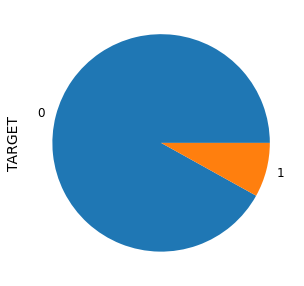

In [602]:
df_application_train['TARGET'].value_counts().plot(kind='pie')

#### Variables catégorielles

df_application_train
--------------------
df_bureau
---------
df_bureau_balance
-----------------
df_credit_card_balance
----------------------


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


df_installments_payments
------------------------
df_POS_CASH_balance
-------------------


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


df_previous_application
-----------------------


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open

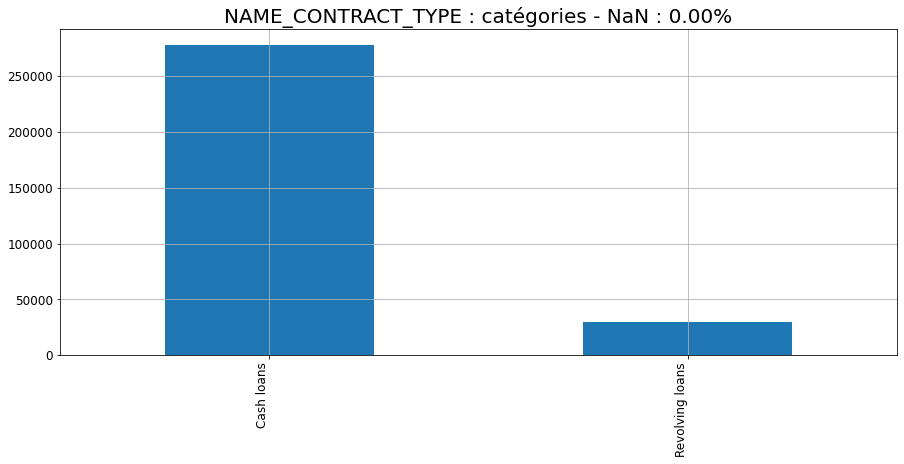

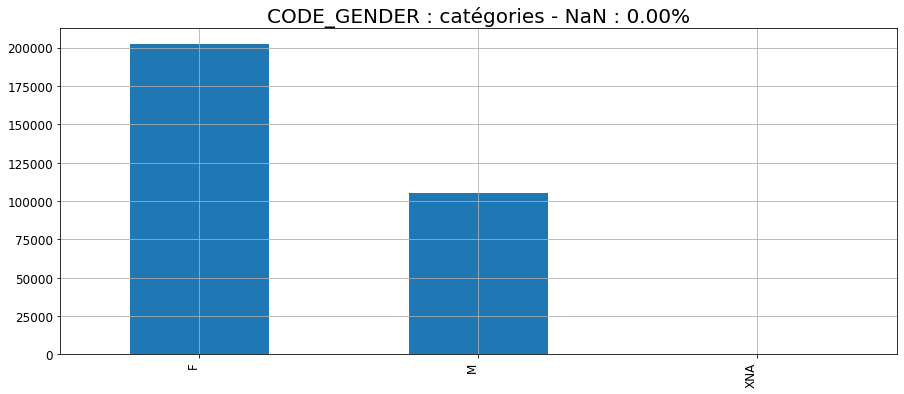

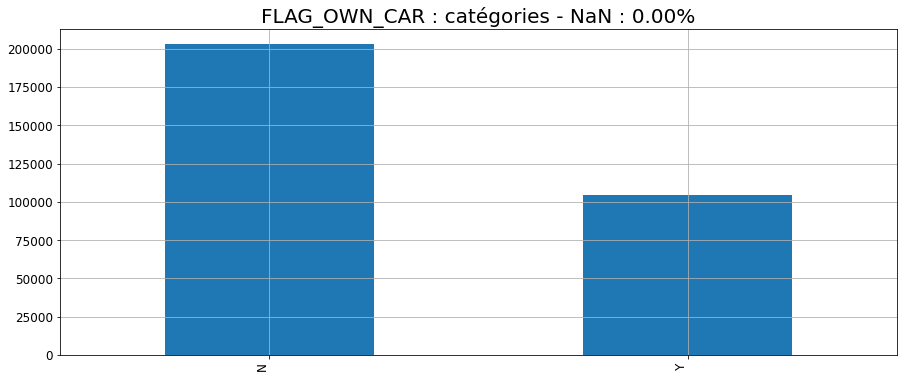

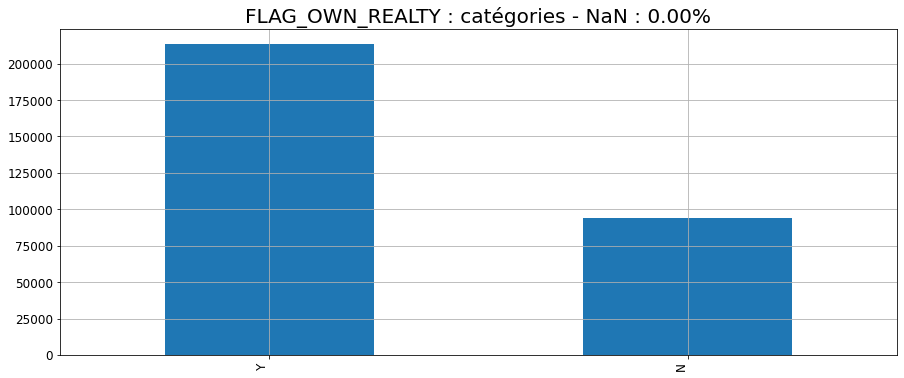

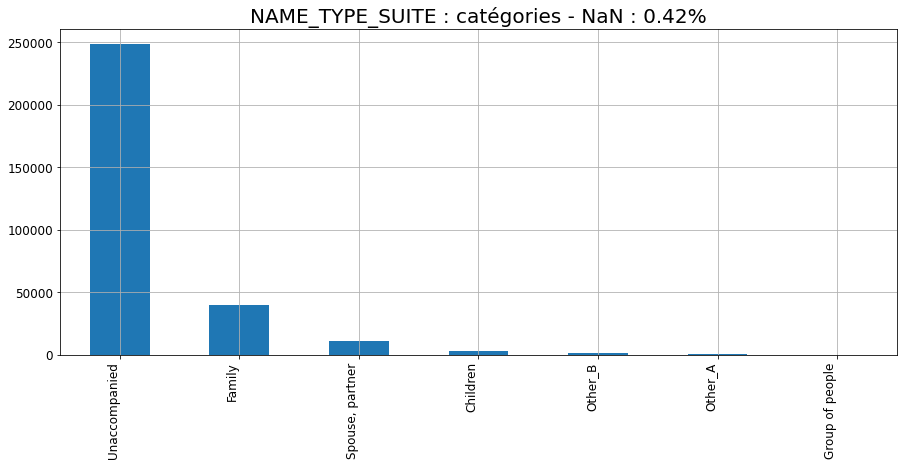

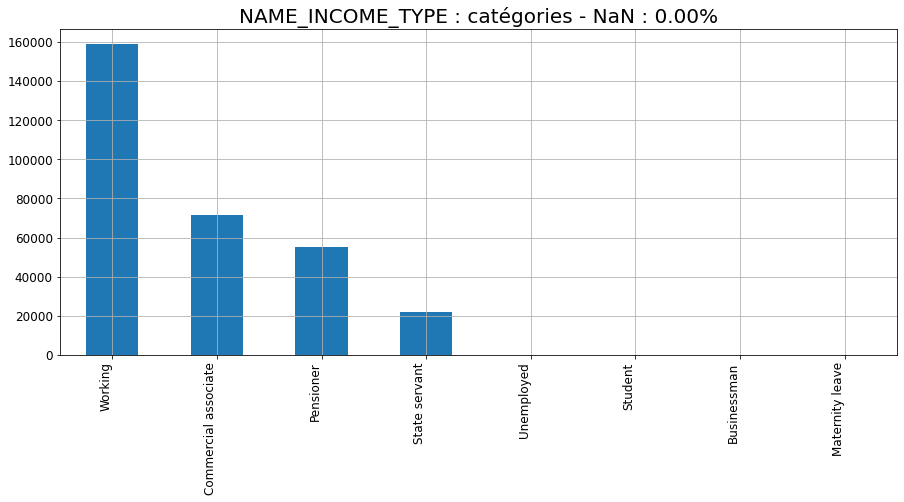

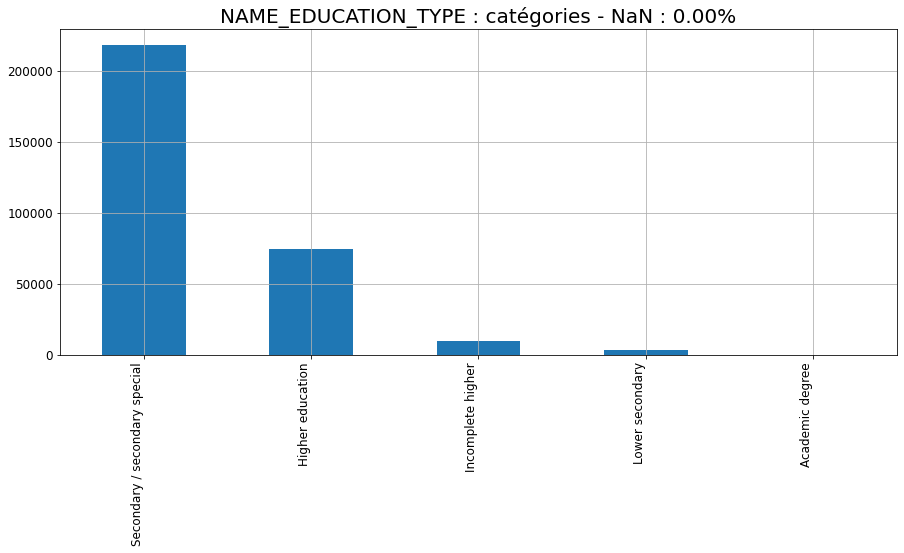

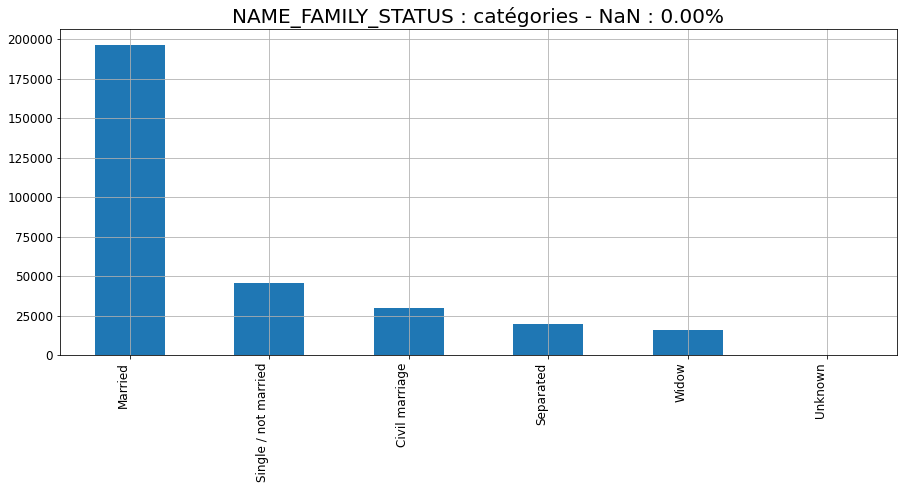

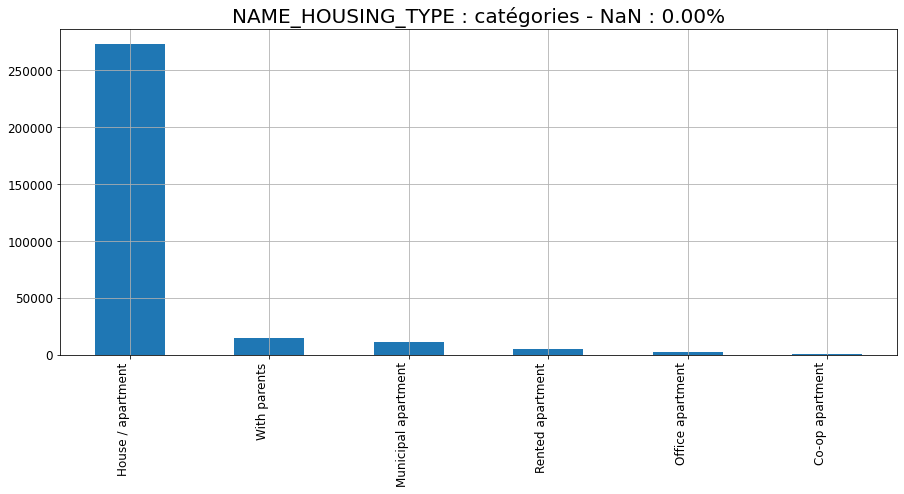

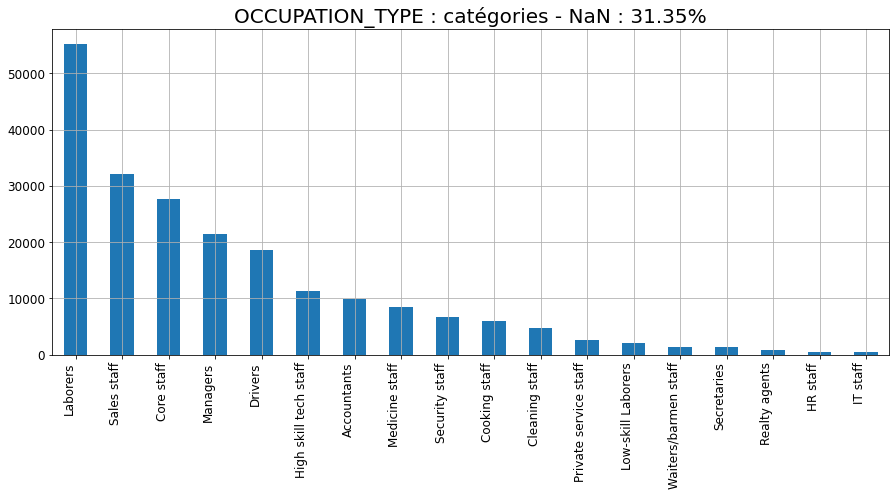

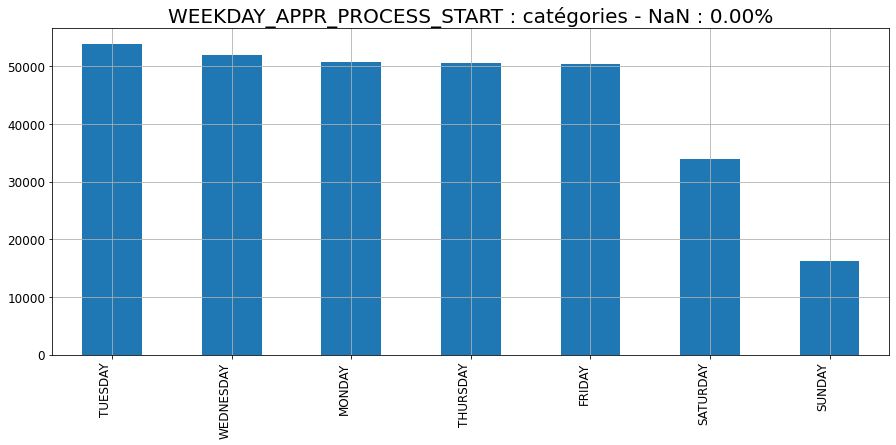

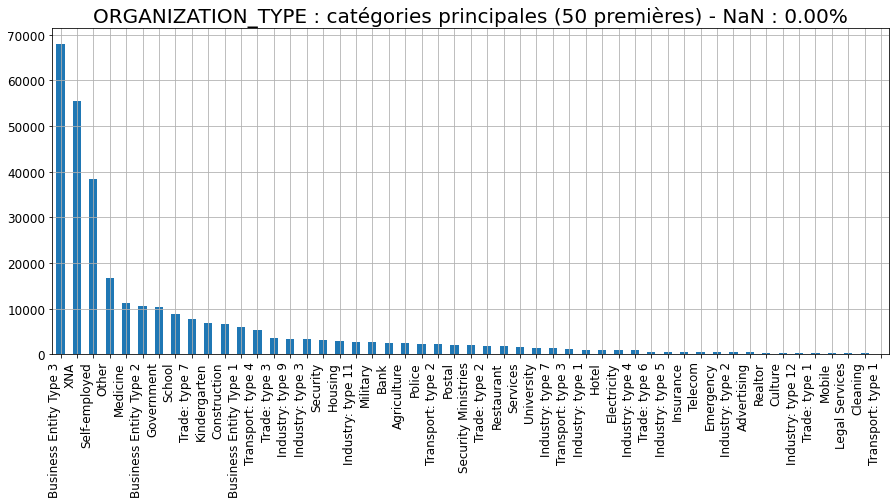

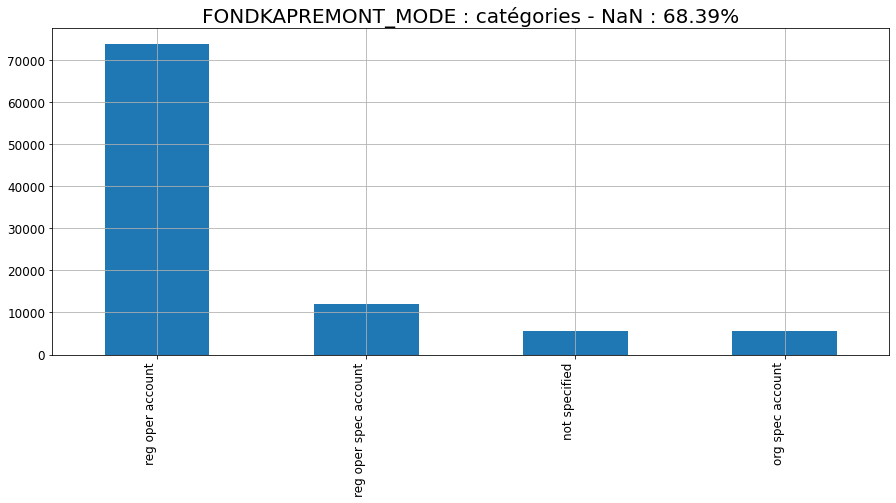

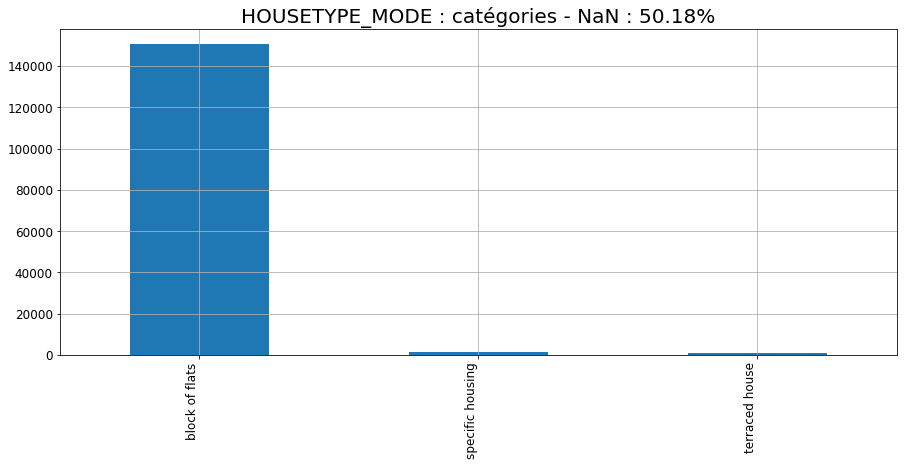

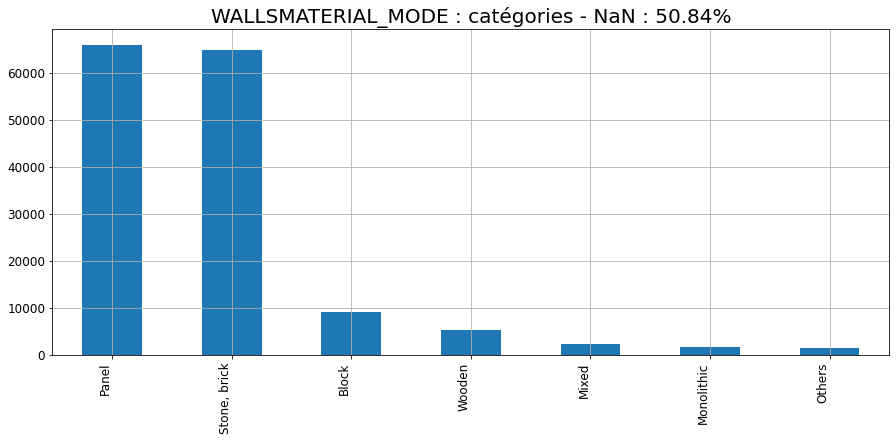

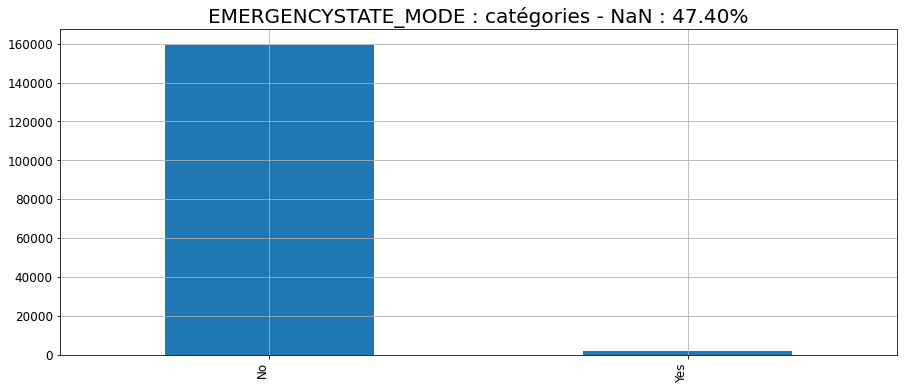

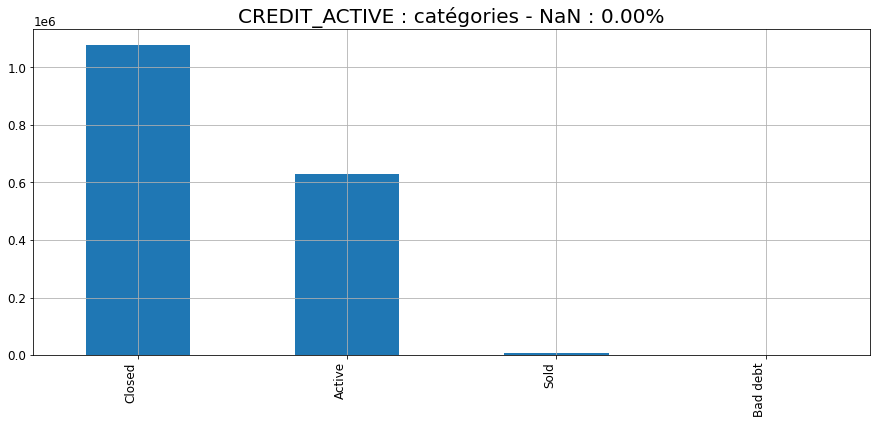

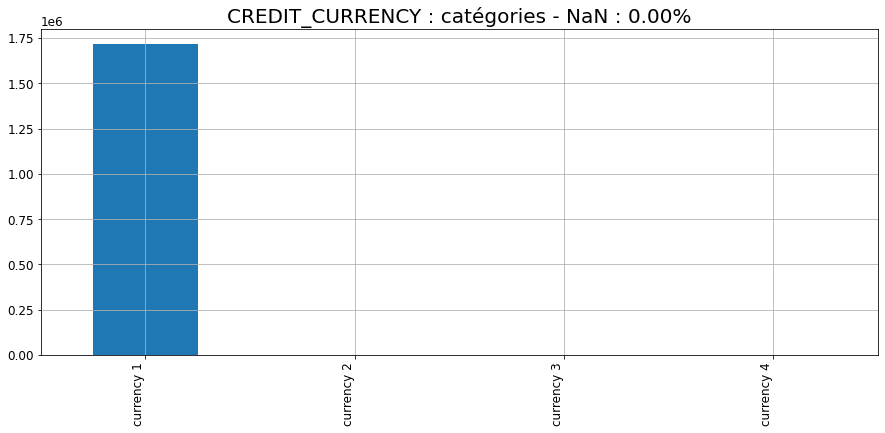

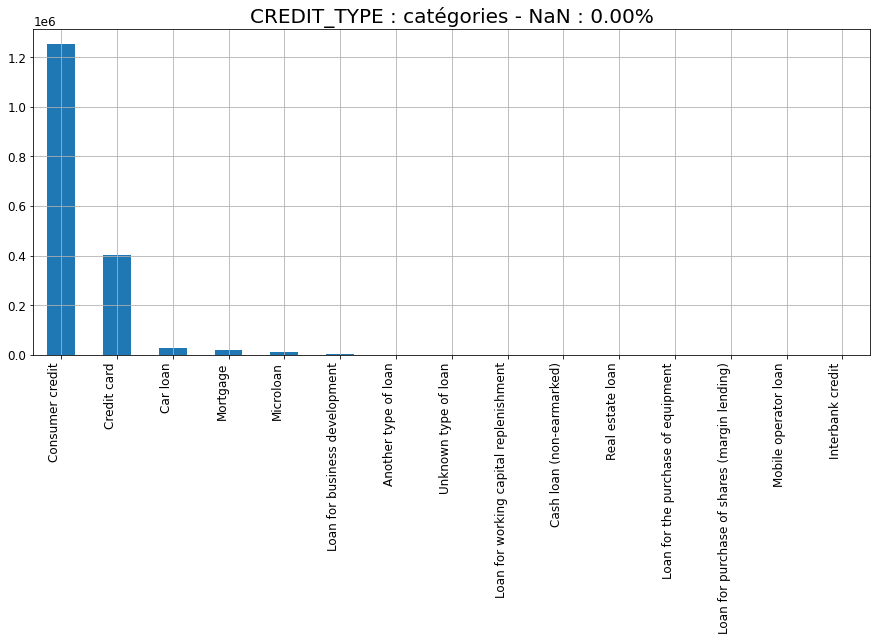

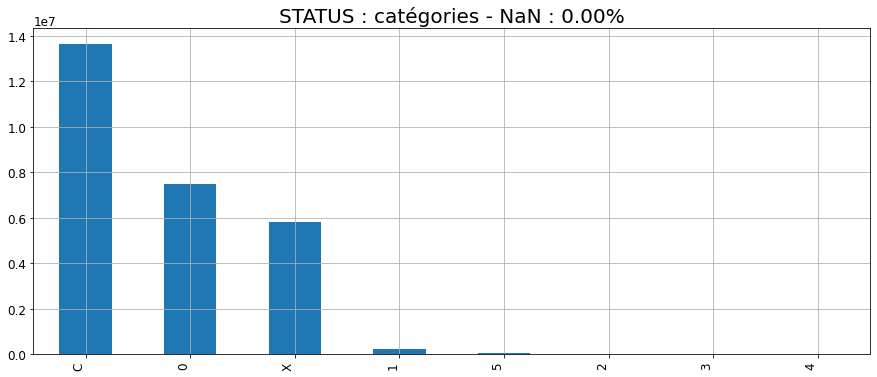

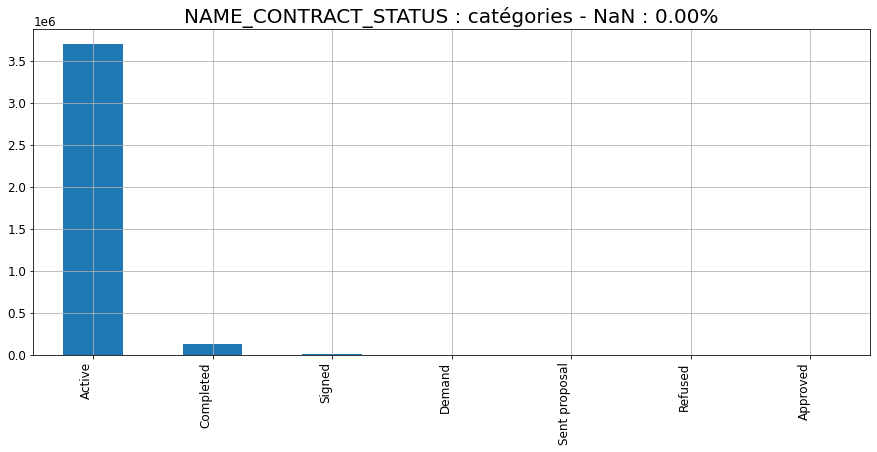

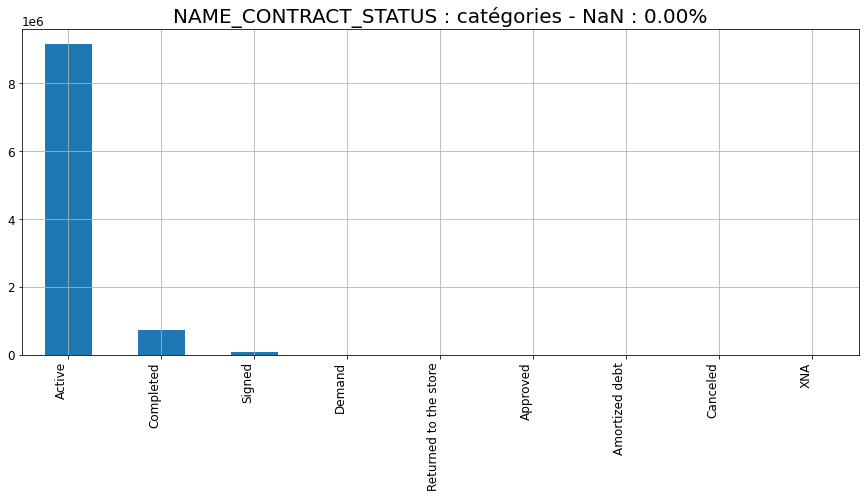

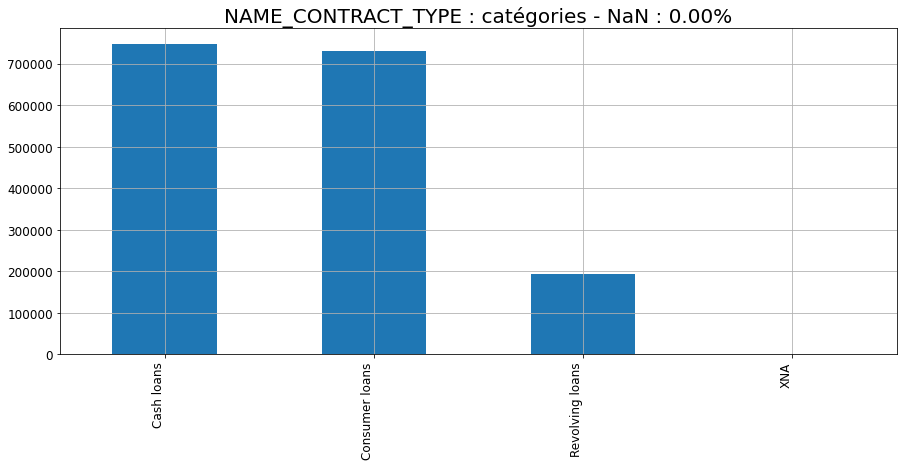

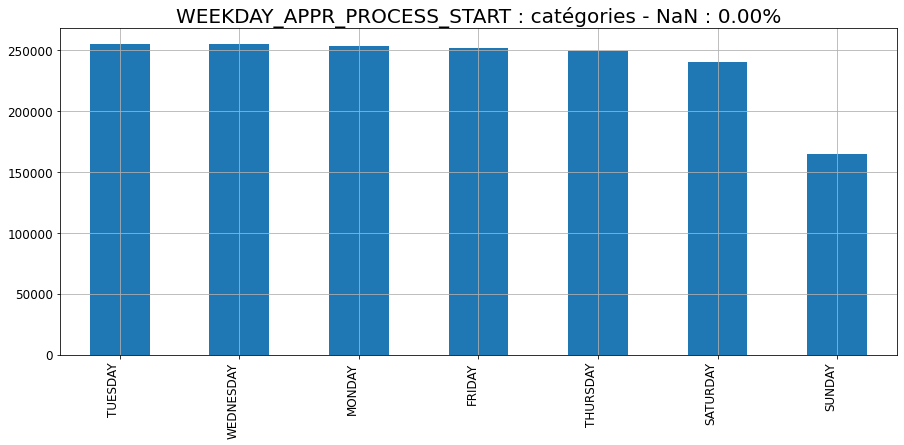

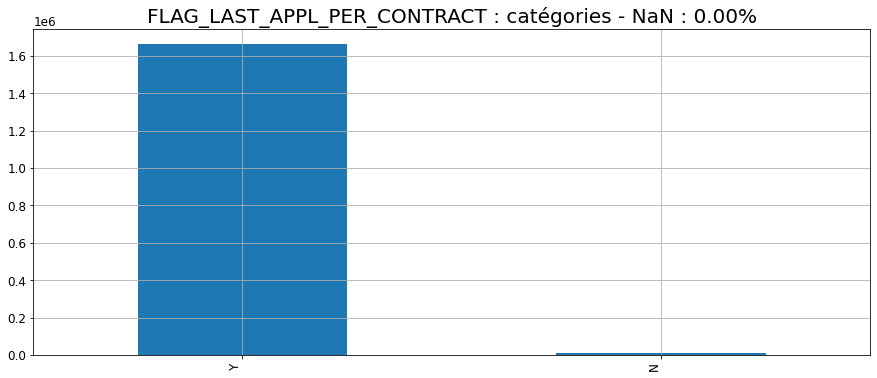

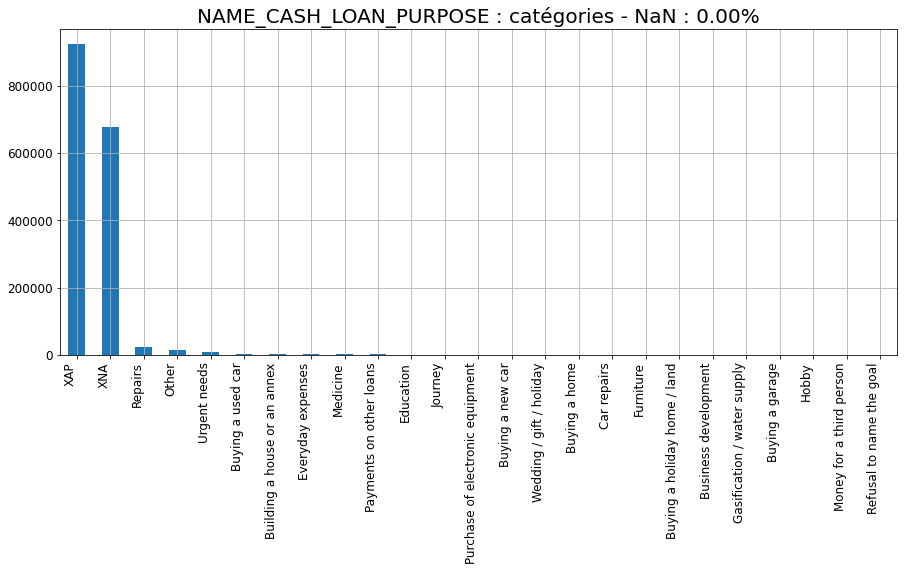

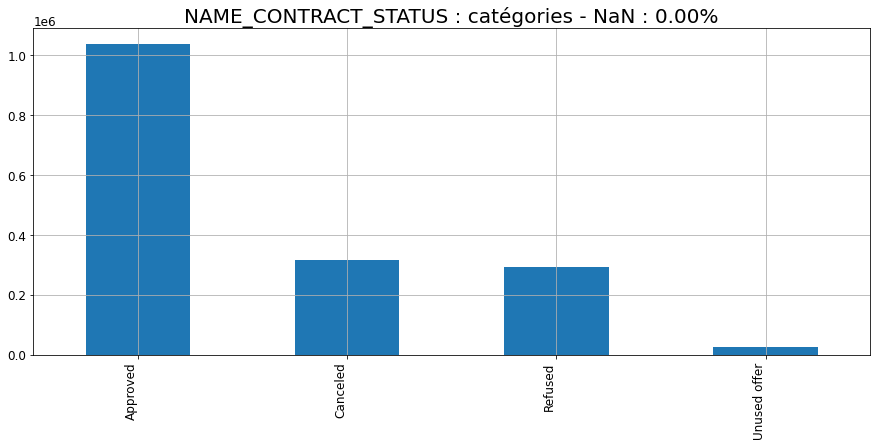

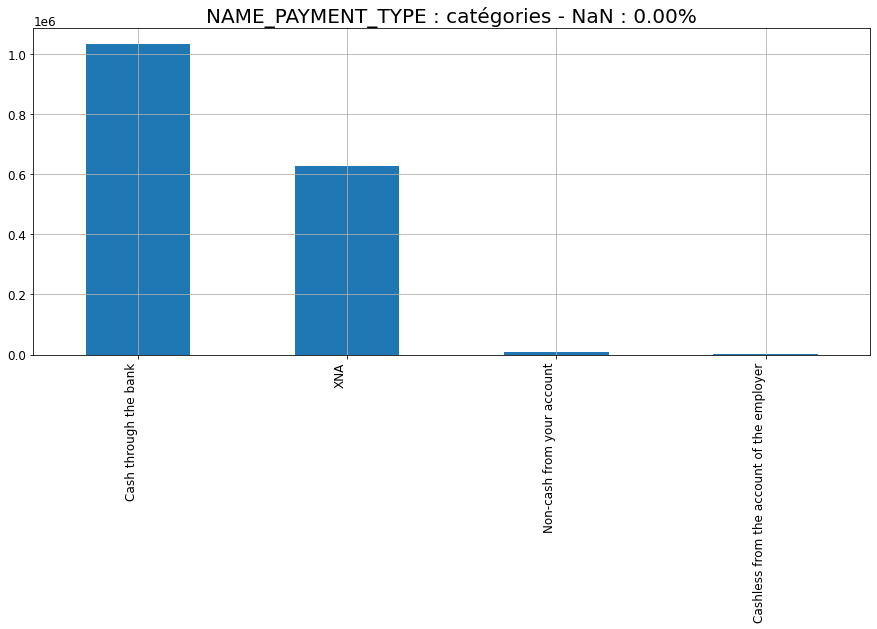

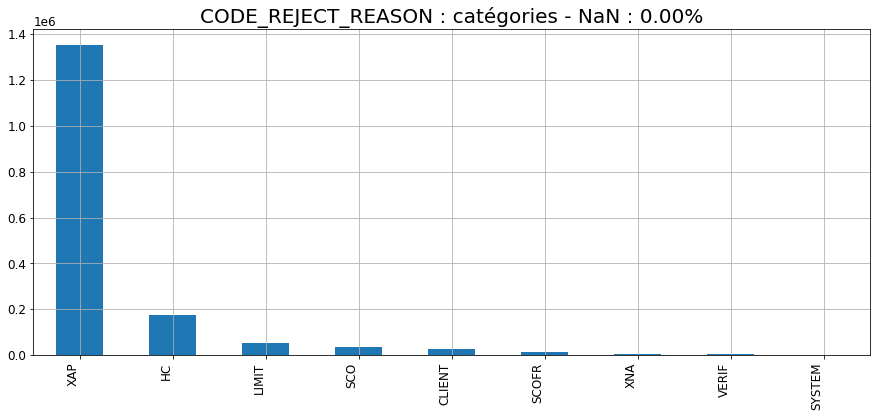

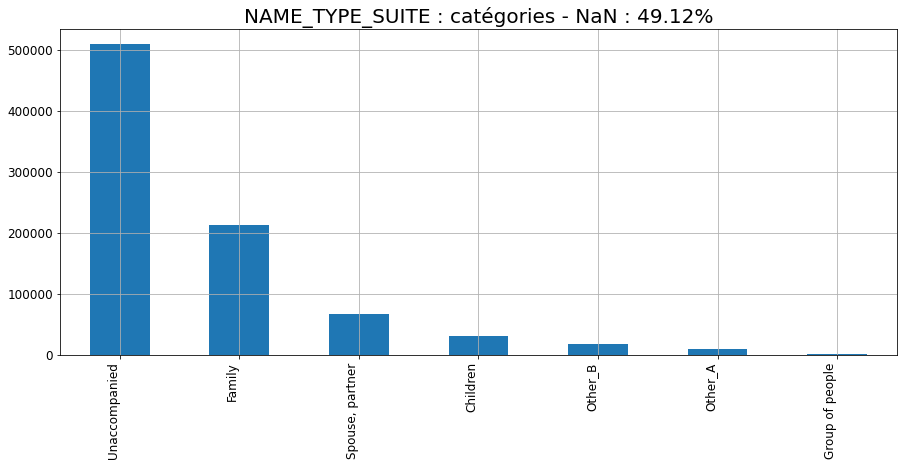

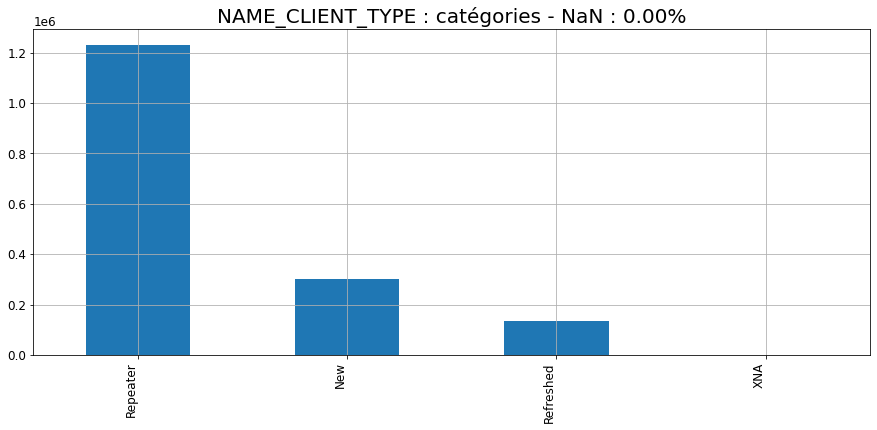

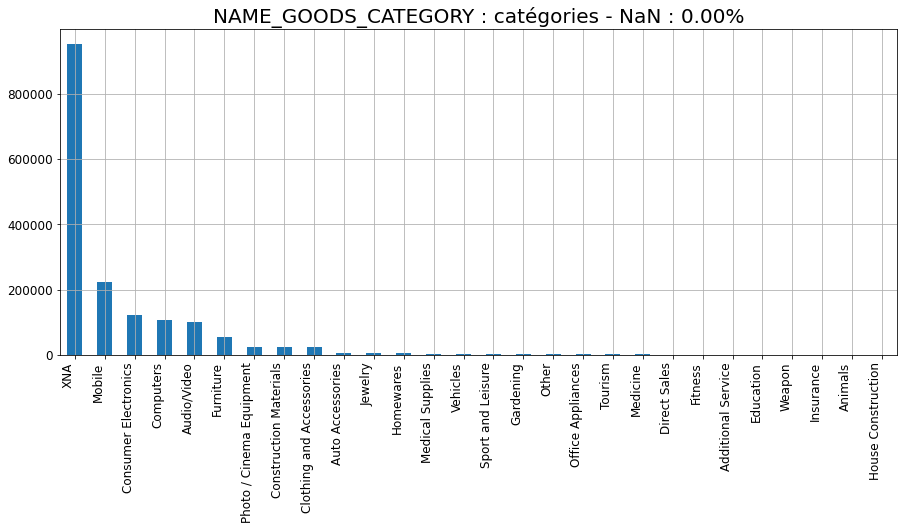

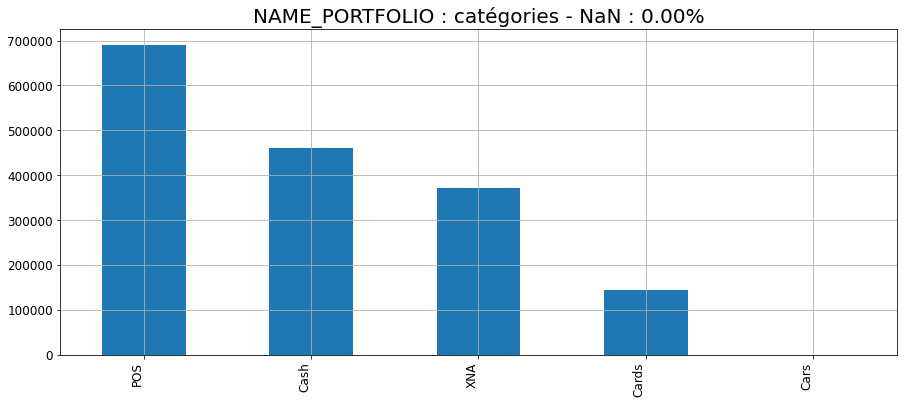

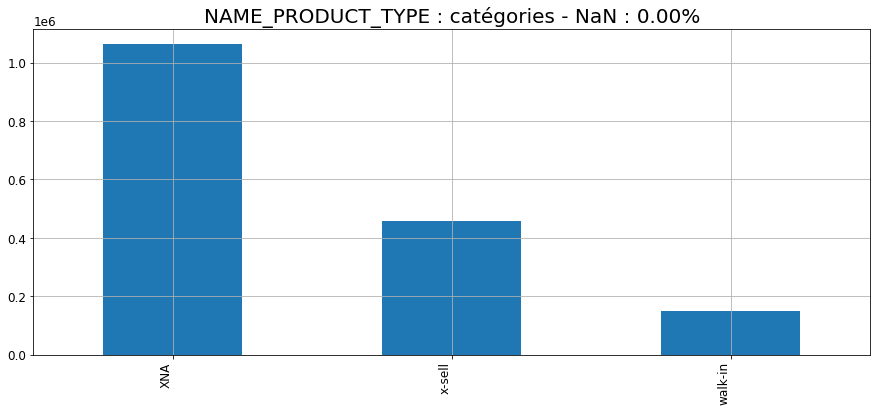

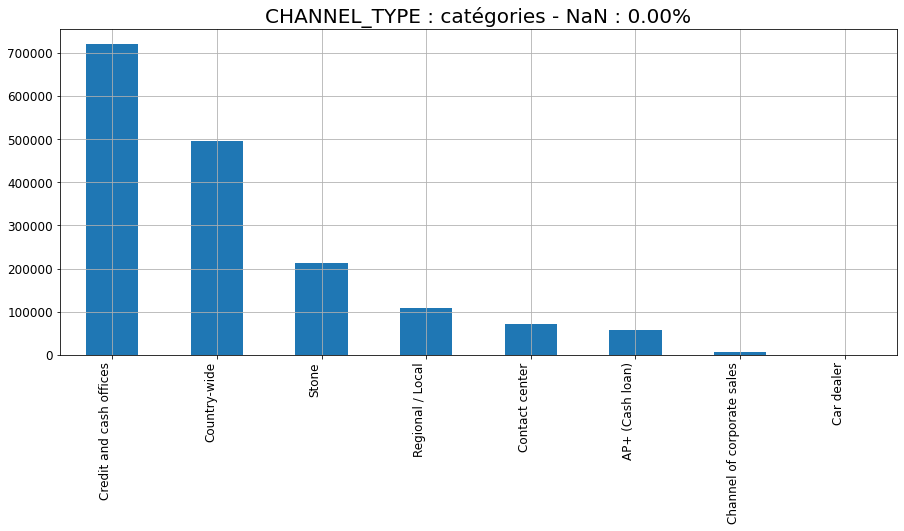

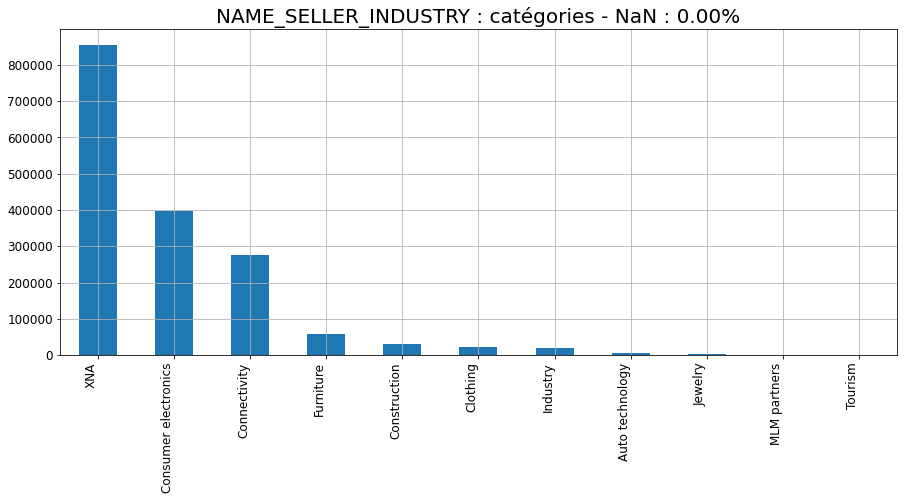

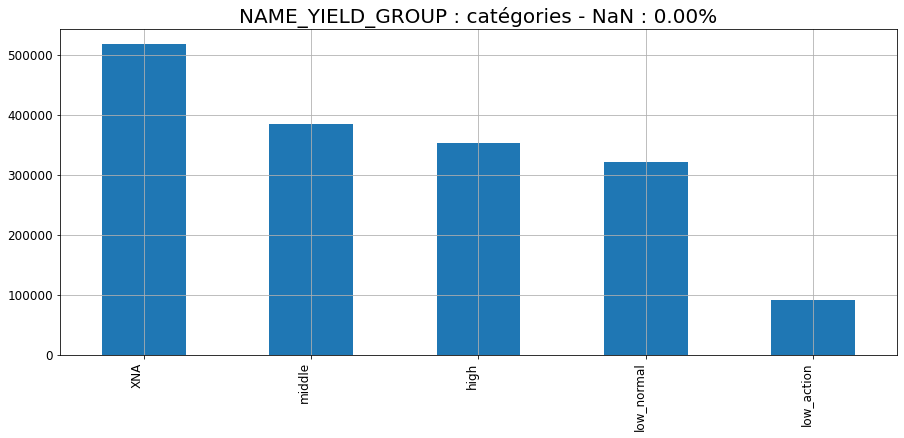

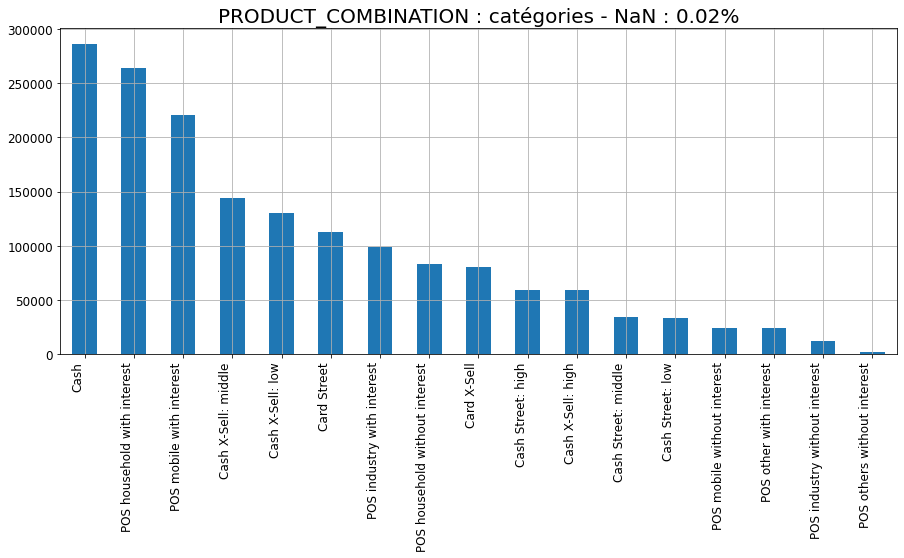

In [603]:
target_col = 'TARGET'
if DISPLAY_EDA_GRAPHS :
    for df, df_name in [[df_application_train, 'df_application_train'],
                        # [df_application_test, 'df_application_test'],
                        [df_bureau, 'df_bureau'],
                        [df_bureau_balance, 'df_bureau_balance'],
                        [df_credit_card_balance, 'df_credit_card_balance'],
                        [df_installments_payments, 'df_installments_payments'],
                        [df_POS_CASH_balance, 'df_POS_CASH_balance'],
                        [df_previous_application, 'df_previous_application']]:

        print(bcolors.BOLD+bcolors.HEADER+df_name+'\n'+'-'*len(df_name)+bcolors.ENDC)
        cat_cols = [col for col in df.columns if df[col].dtype == 'object']
        num_cols = list(set(df.columns) - set(cat_cols) - set(['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']))
        feat_cols = num_cols + cat_cols
        all_cols = feat_cols + [target_col]

        plt.rcParams['figure.figsize'] = [15, 6]
        plt.rcParams['axes.titlesize'] = 20
        plt.rcParams['axes.labelsize'] = 14
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12

        n = len(cat_cols)
        ind = 0
        for colonne in cat_cols:
            ind += 1
            DisplotData.trace_tuyaux_principaux(df,colonne, seuil=1., max_bar=50, kind='bar', rot=90, show_nan=True);

#### Variables numériques

In [604]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

df_application_train
--------------------
num_cols = ['DAYS_LAST_PHONE_CHANGE', 'NONLIVINGAREA_MODE', 'FLAG_DOCUMENT_14', 'DAYS_REGISTRATION', 'FLAG_EMP_PHONE', 'FLOORSMAX_MODE', 'BASEMENTAREA_MEDI', 'CNT_FAM_MEMBERS', 'FLAG_DOCUMENT_6', 'REGION_POPULATION_RELATIVE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_8', 'DAYS_EMPLOYED', 'APARTMENTS_AVG', 'LANDAREA_MEDI', 'ELEVATORS_MODE', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'LIVINGAPARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'BASEMENTAREA_AVG', 'FLAG_DOCUMENT_12', 'DEF_30_CNT_SOCIAL_CIRCLE', 'LANDAREA_MODE', 'AMT_ANNUITY', 'YEARS_BUILD_MODE', 'FLOORSMAX_MEDI', 'COMMONAREA_MODE', 'REGION_RATING_CLIENT', 'APARTMENTS_MODE', 'FLAG_DOCUMENT_21', 'LIVINGAREA_MODE', 'AMT_CREDIT', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'YEARS_BEGINEXPLUATATION_MEDI', 'AMT_GOODS_PRICE', 'YEARS_BEGINEXPLUATATION_AVG', 'FLAG_DOCUMENT_10', 'OBS_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'LIVINGAPARTMENTS_MODE', 'FLAG_DOCUMENT_11', 'EXT_SOURCE_3', 'NON

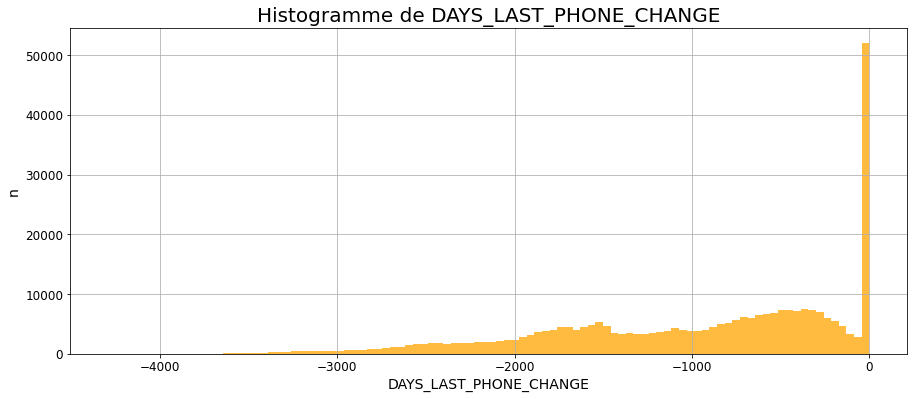

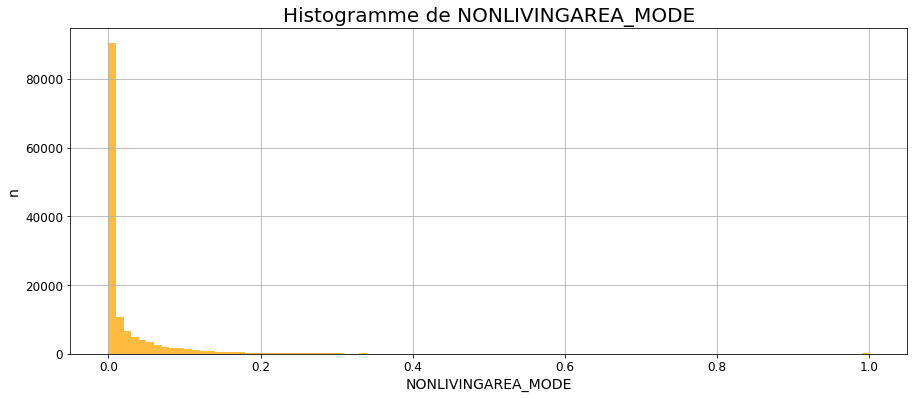

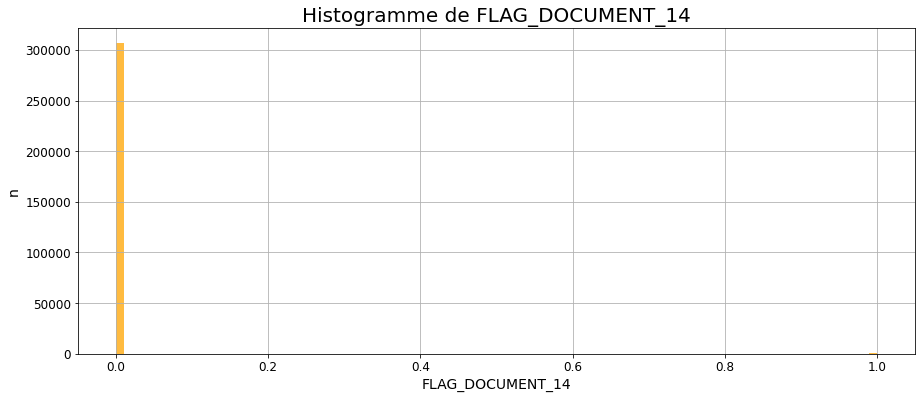

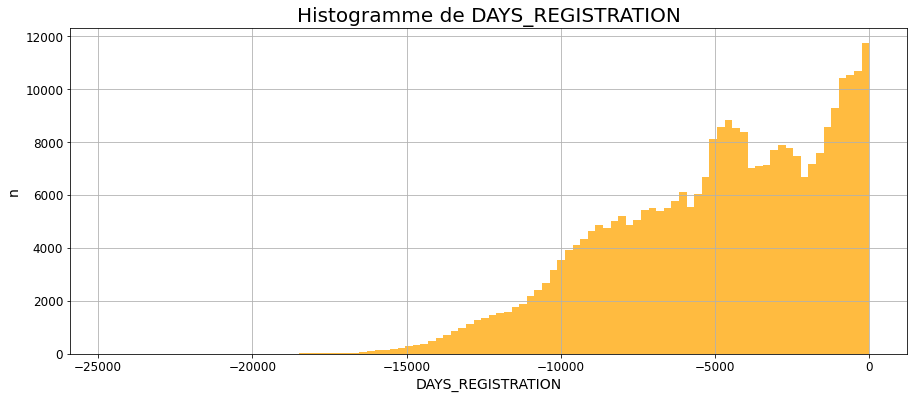

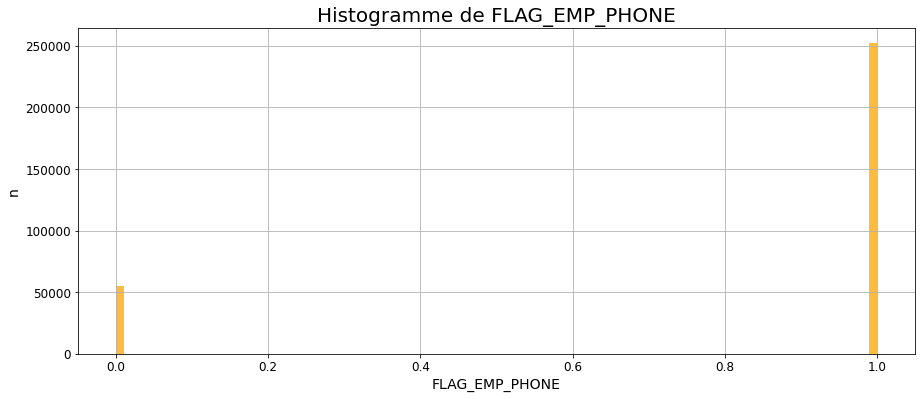

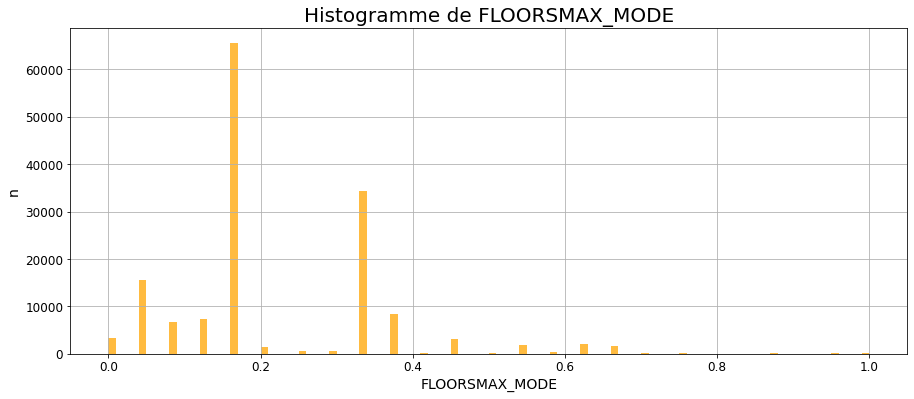

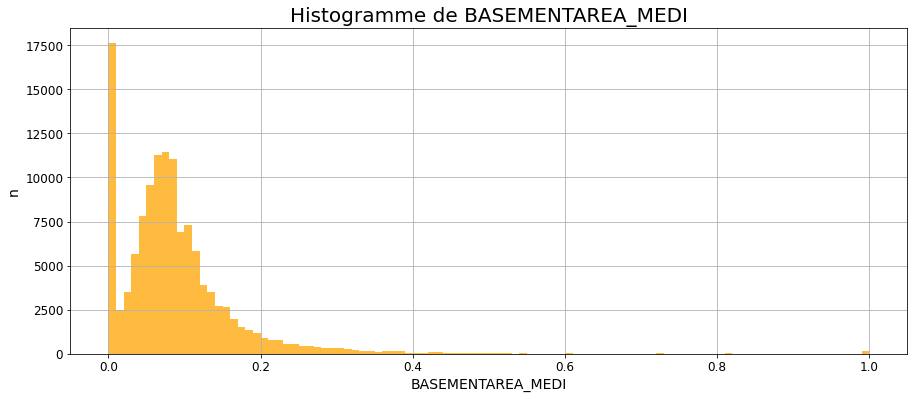

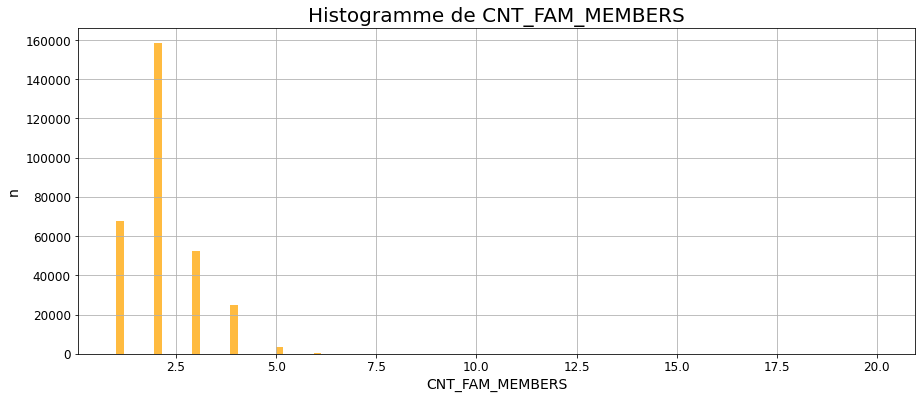

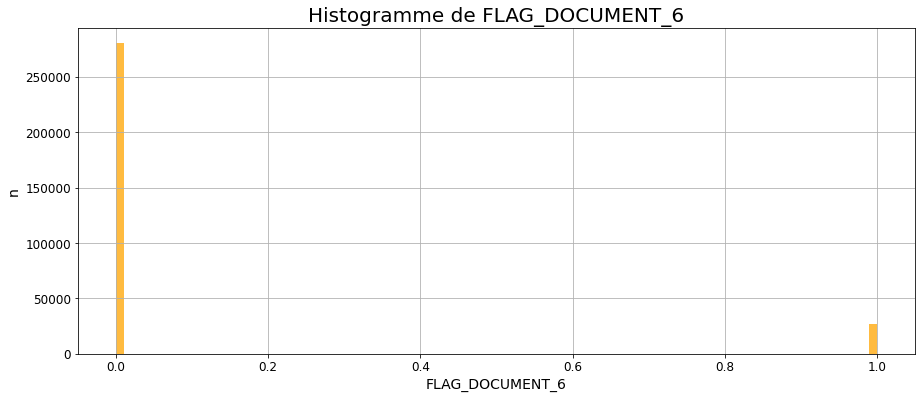

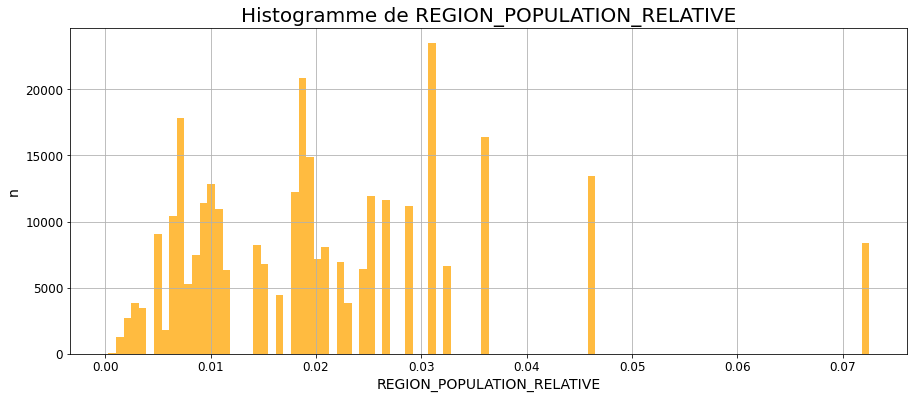

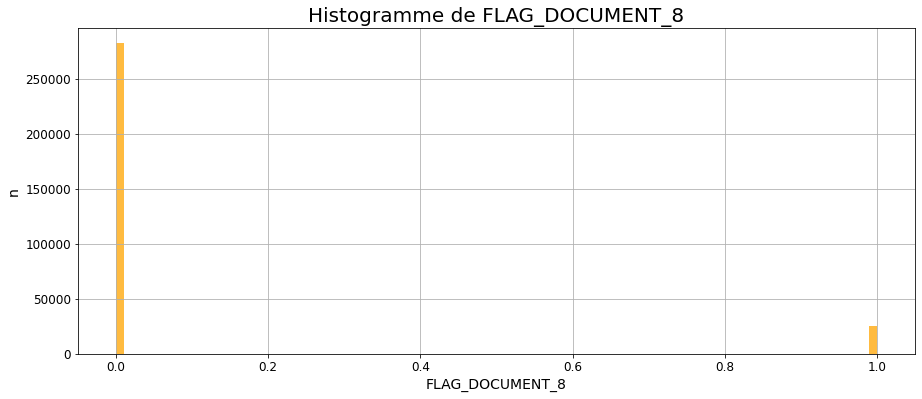

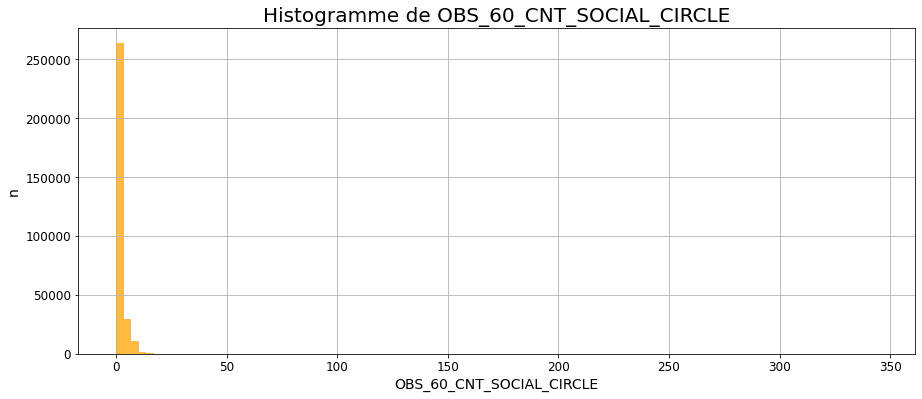

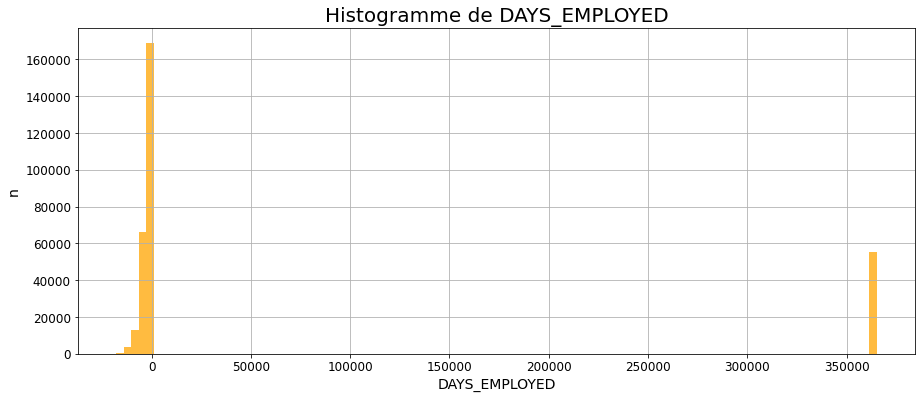

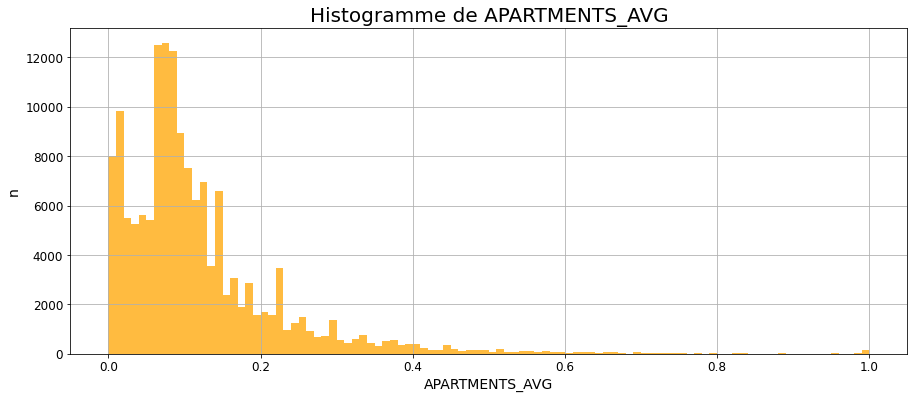

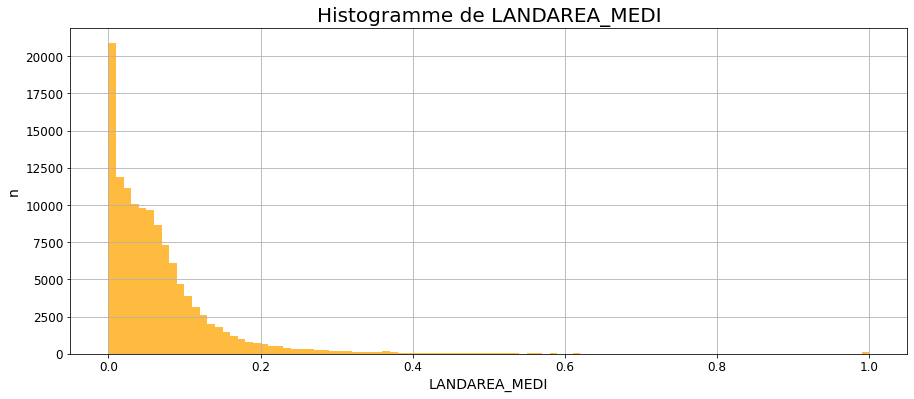

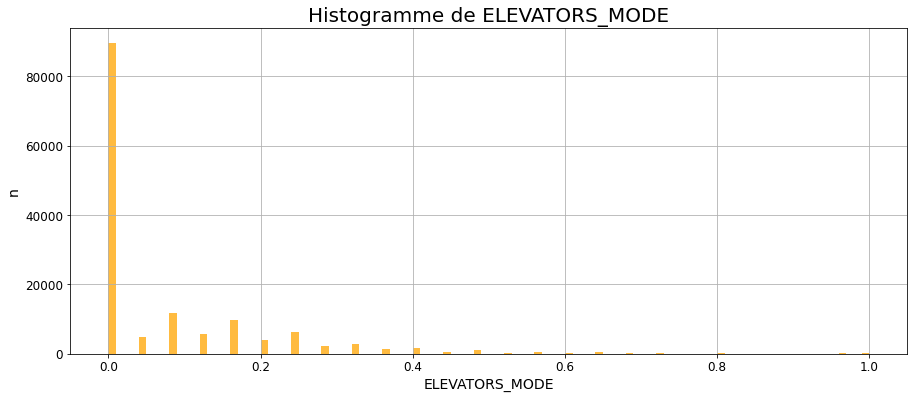

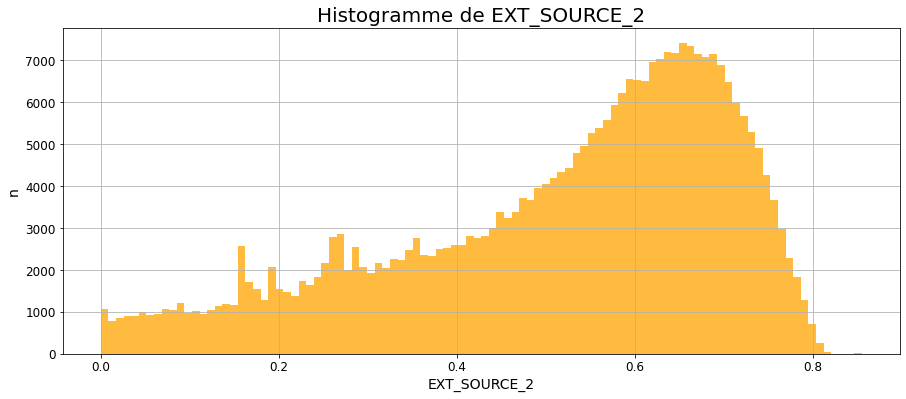

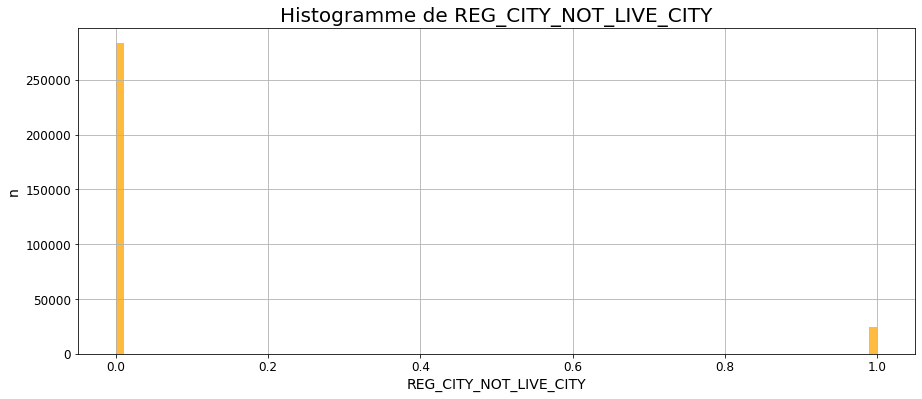

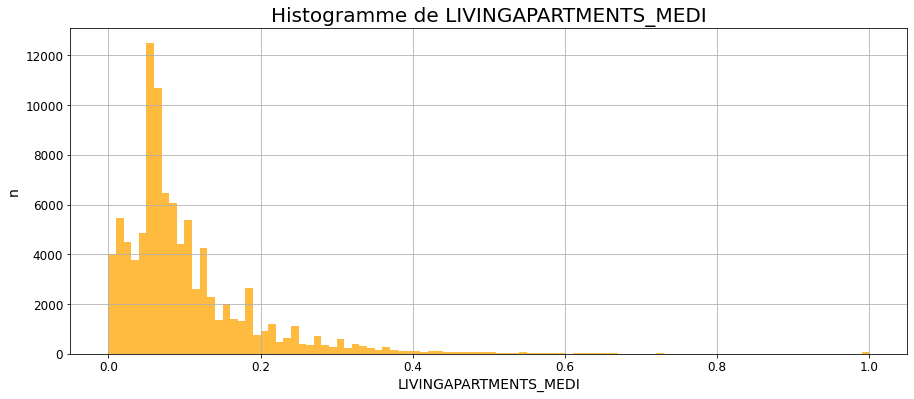

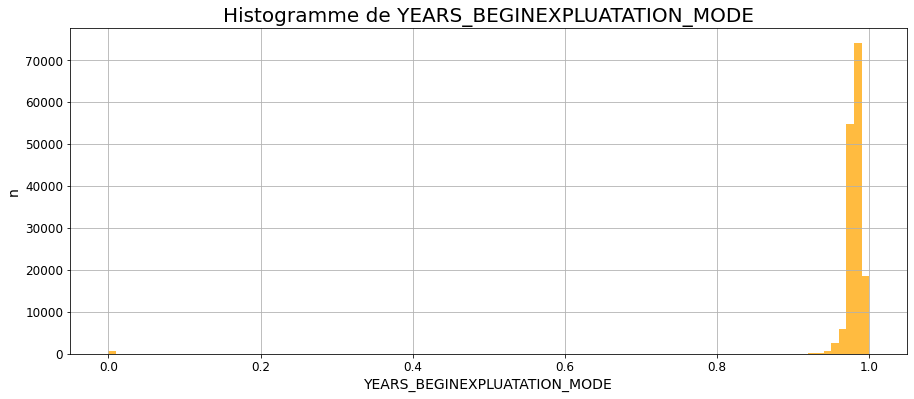

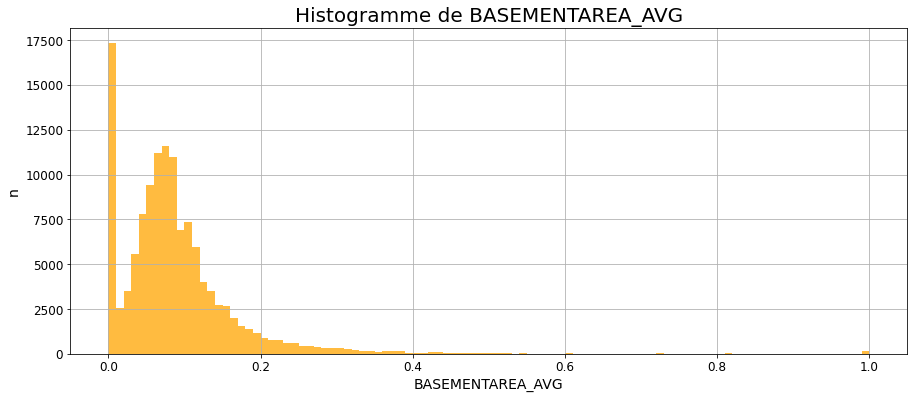

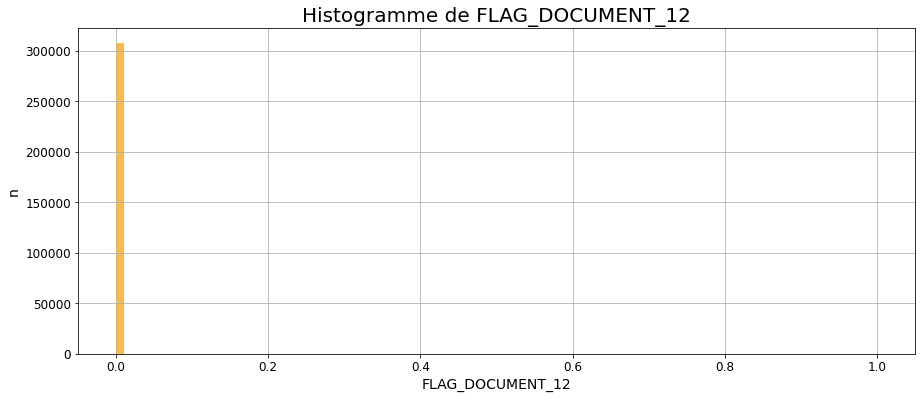

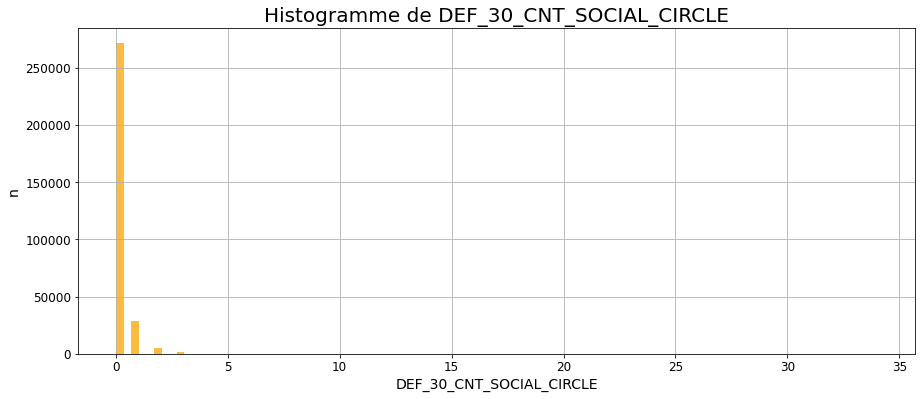

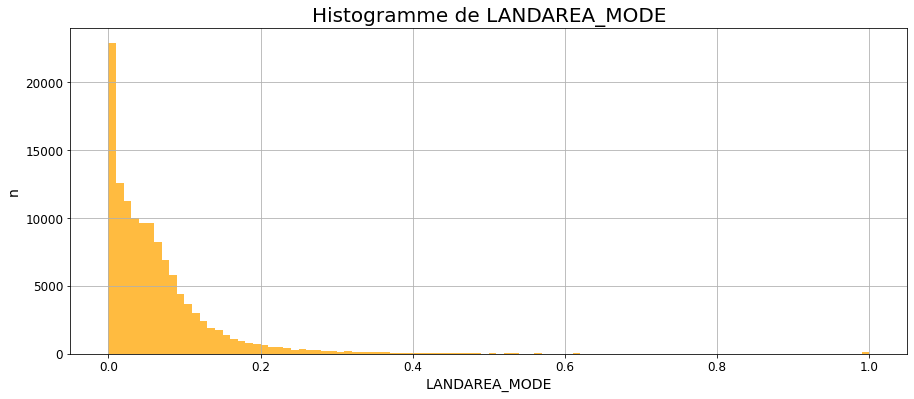

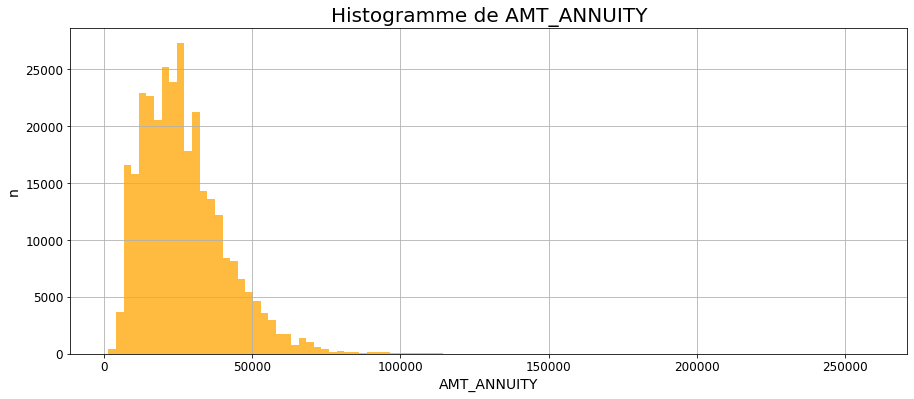

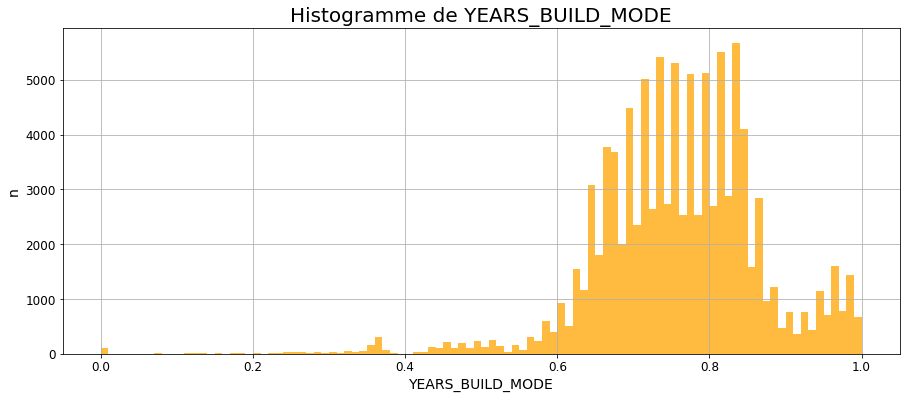

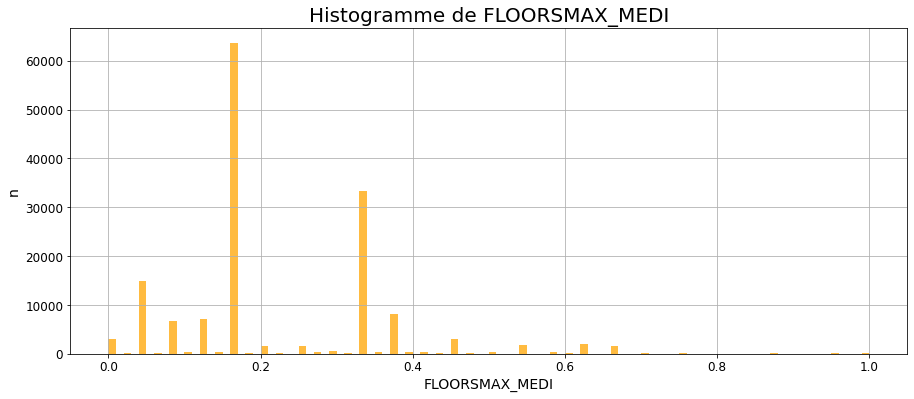

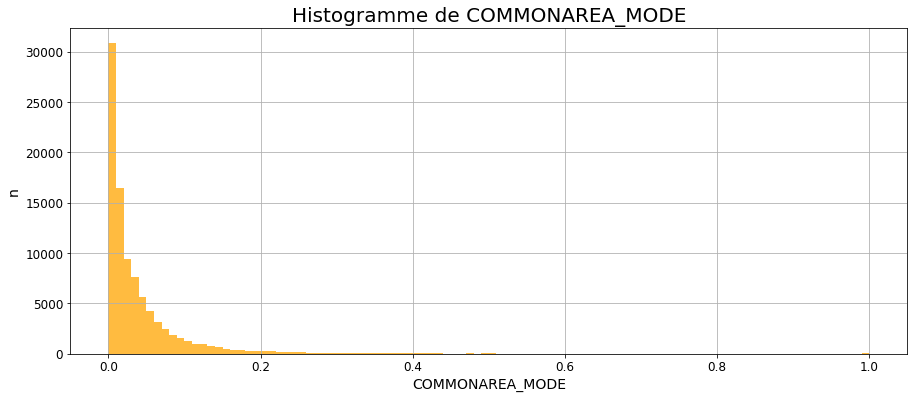

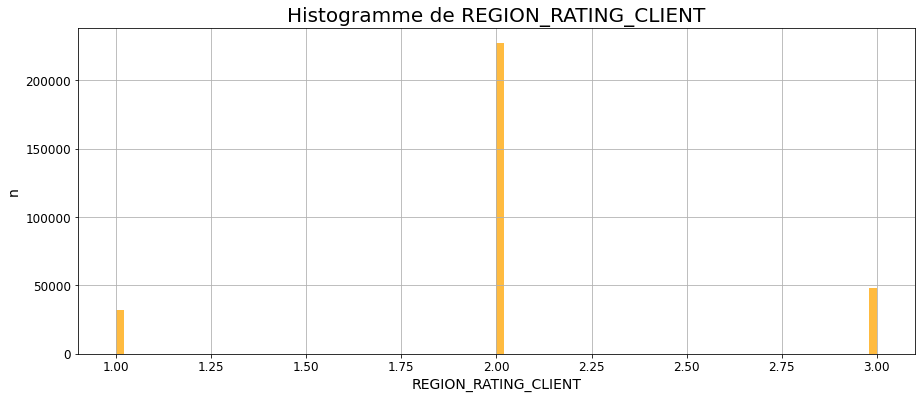

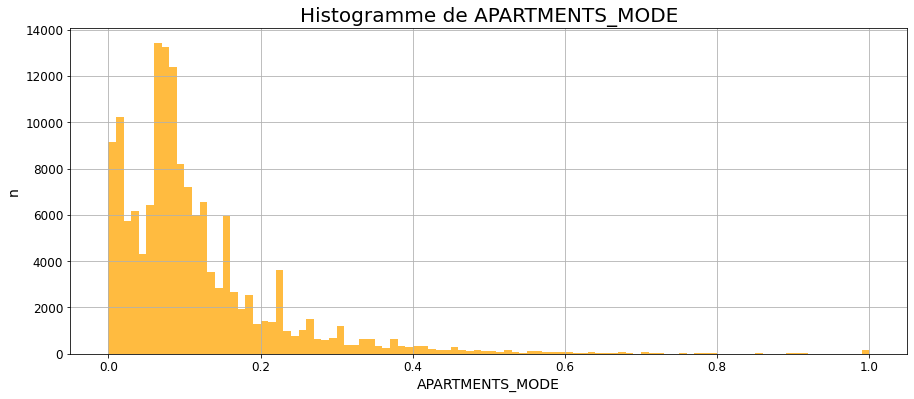

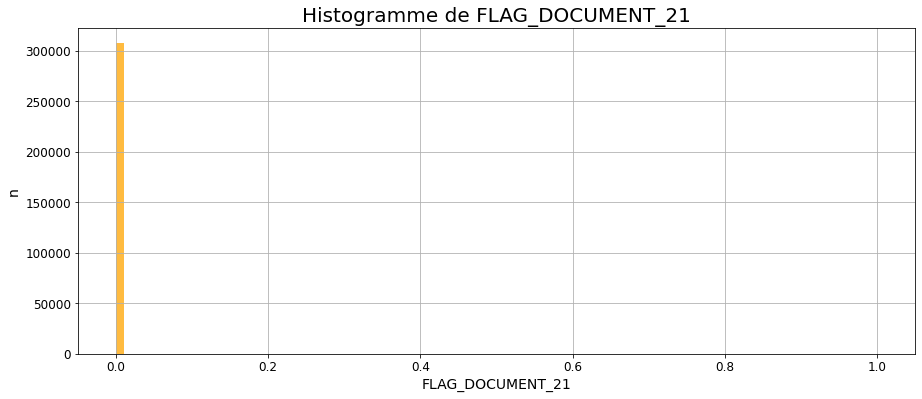

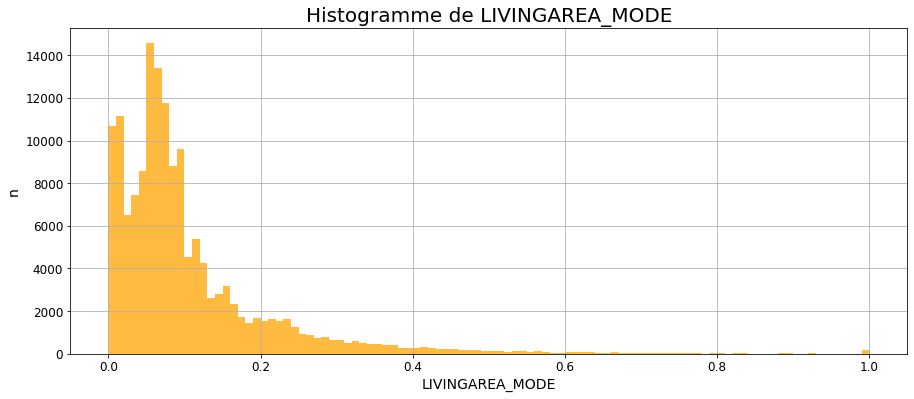

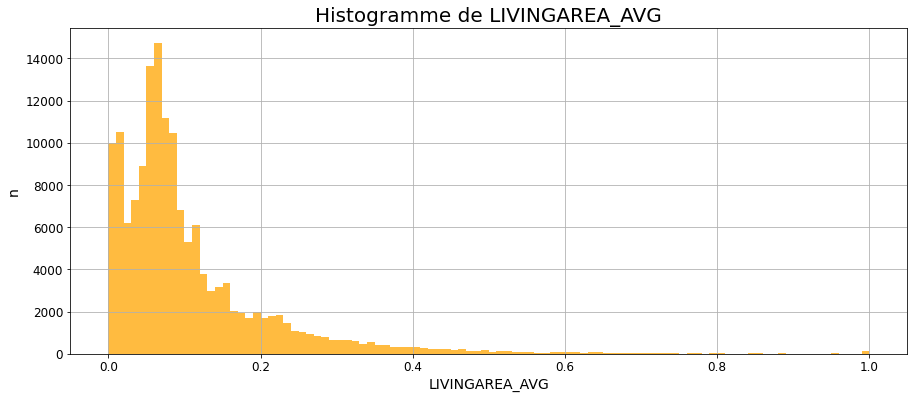

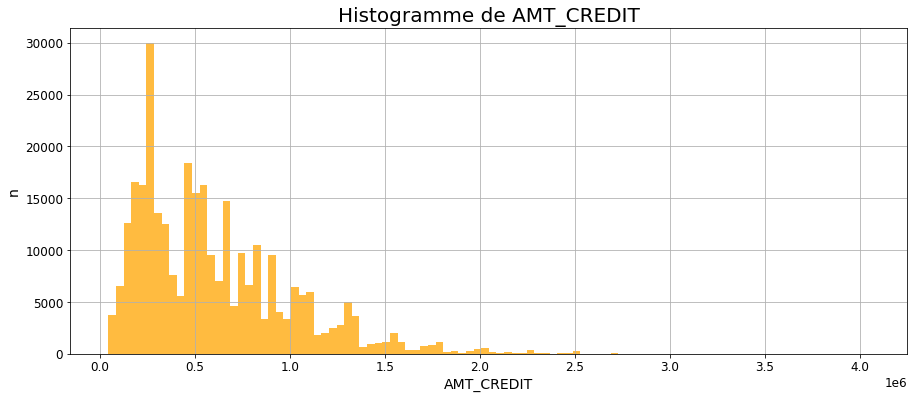

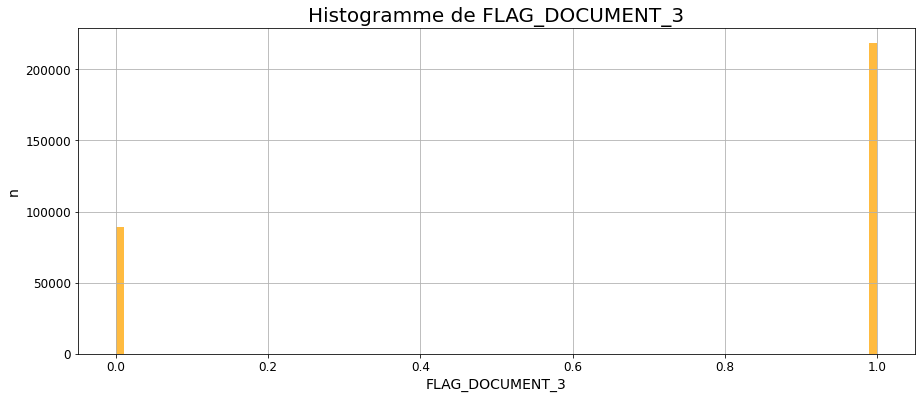

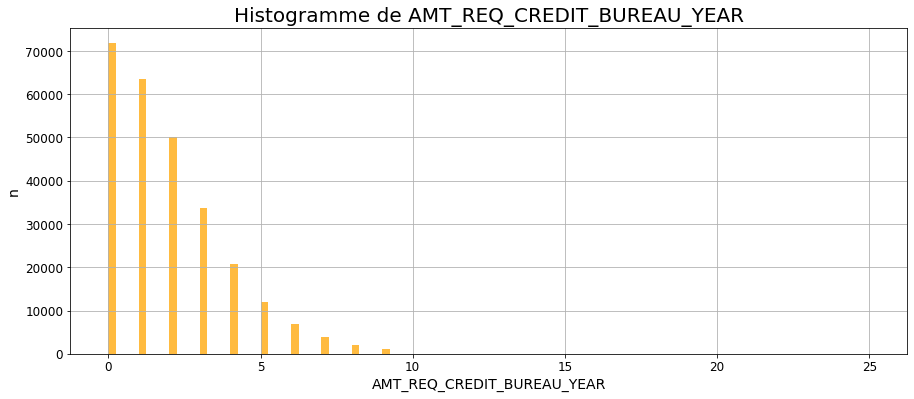

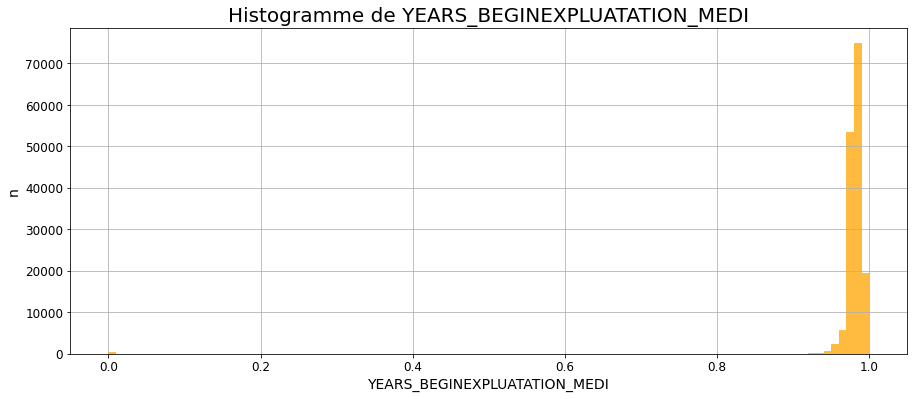

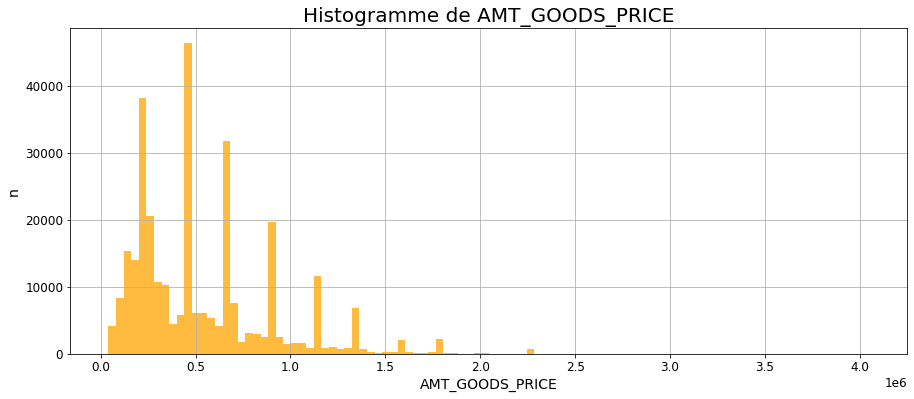

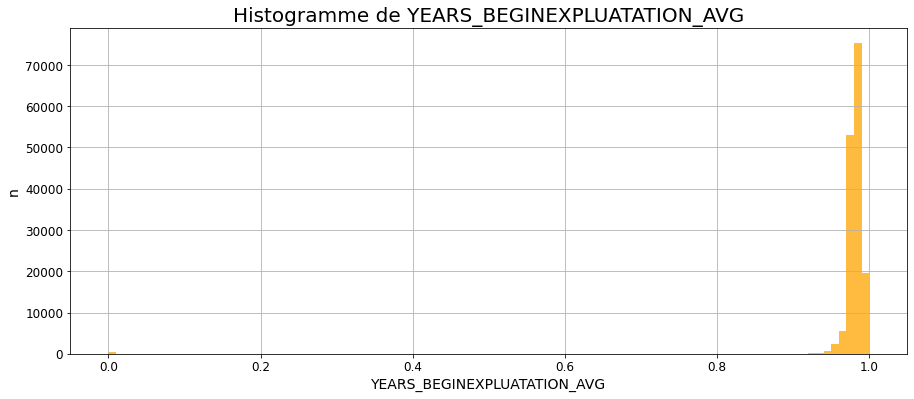

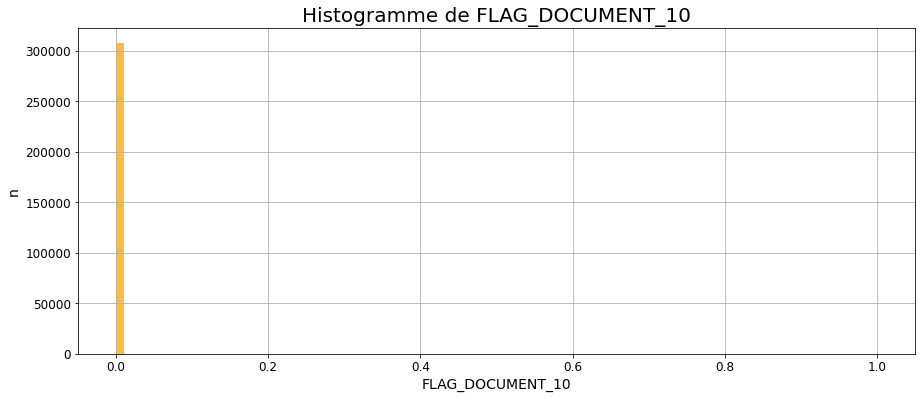

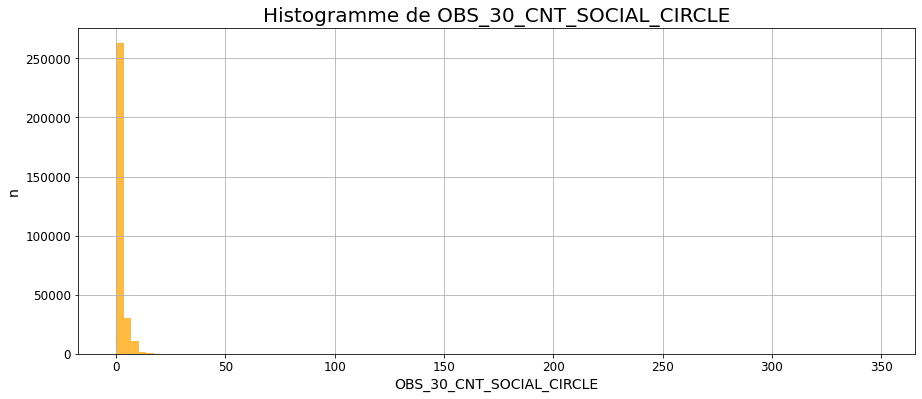

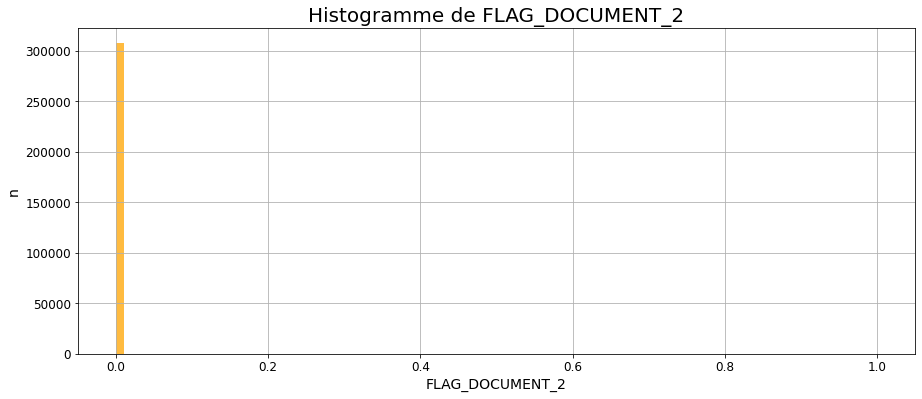

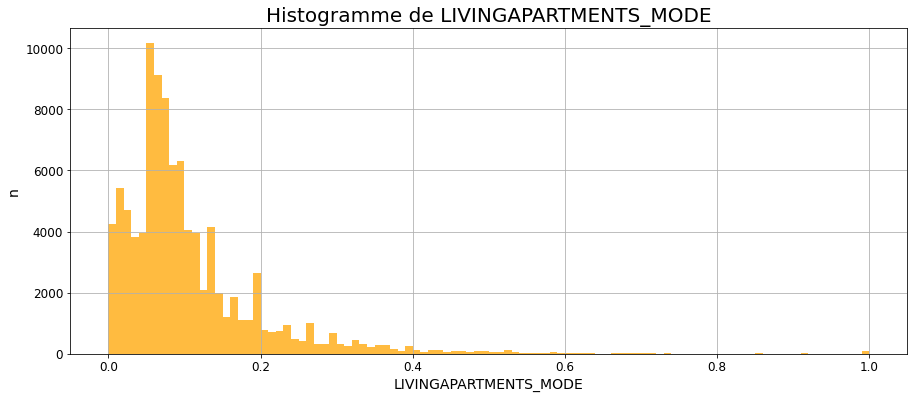

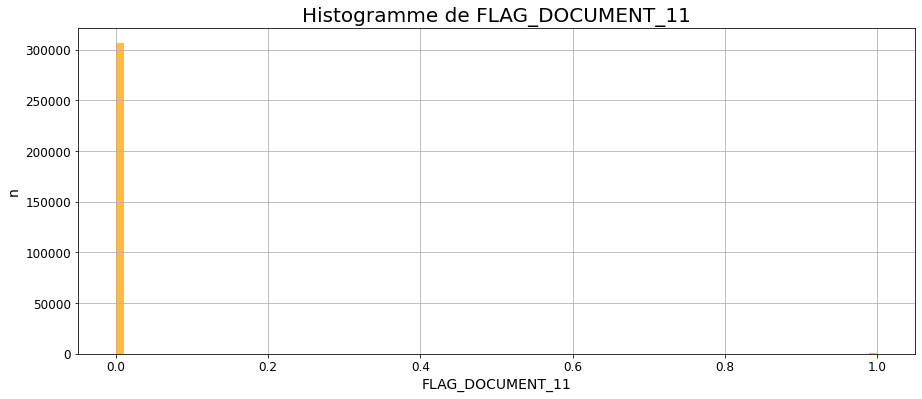

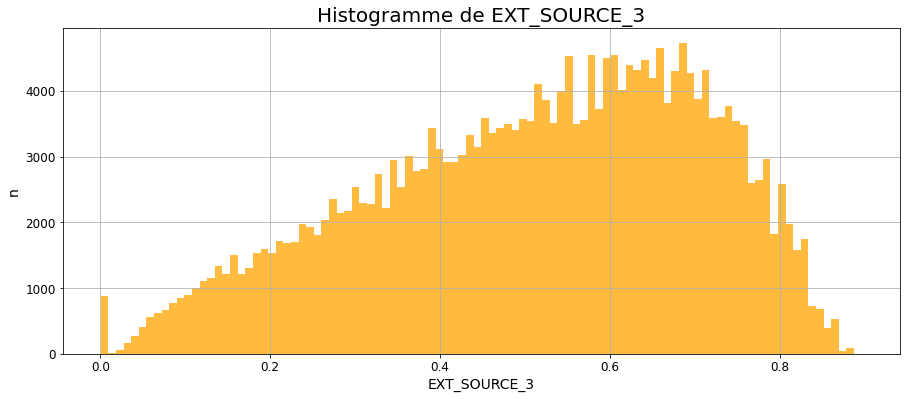

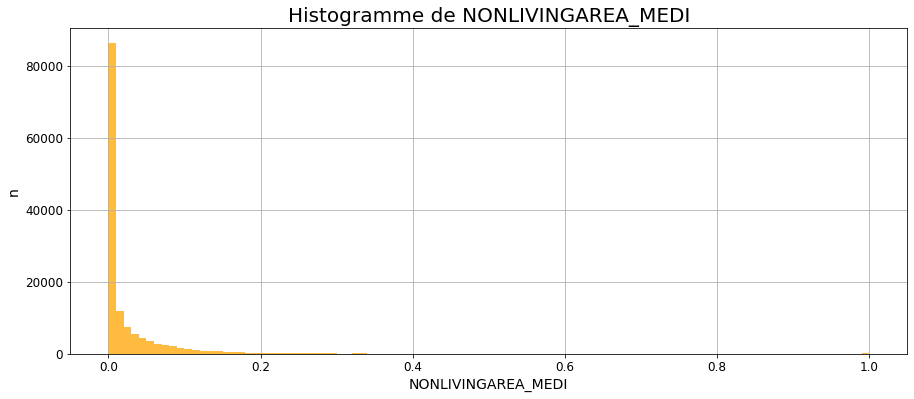

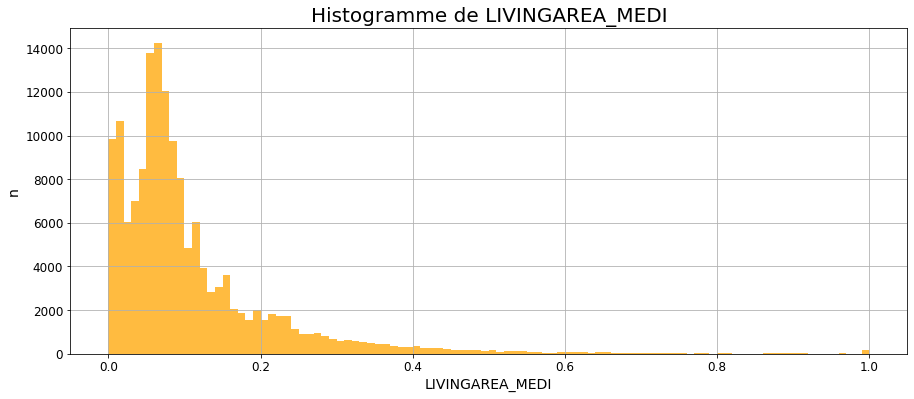

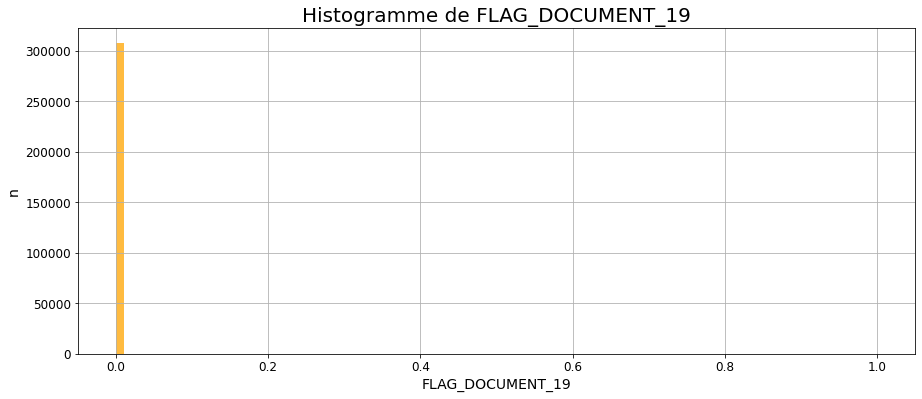

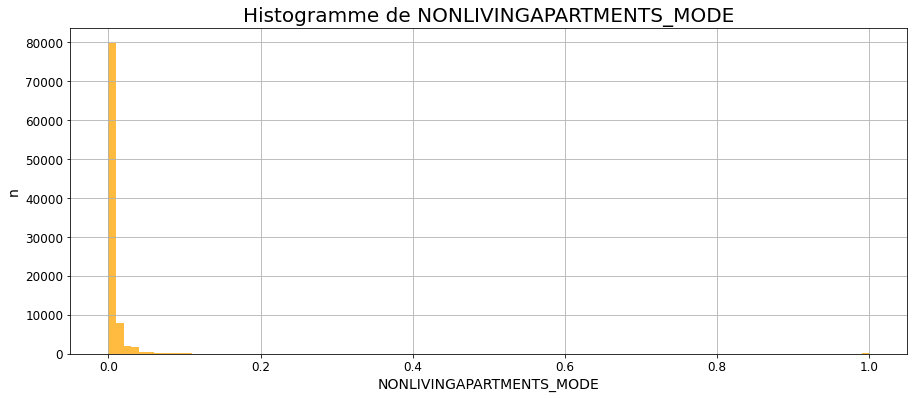

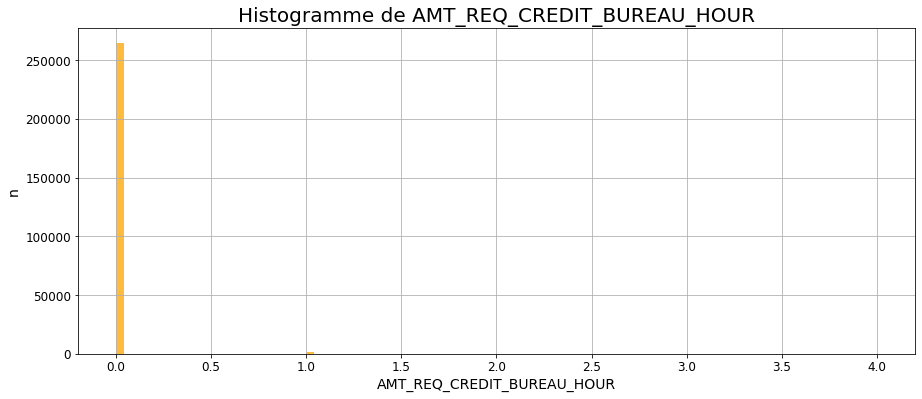

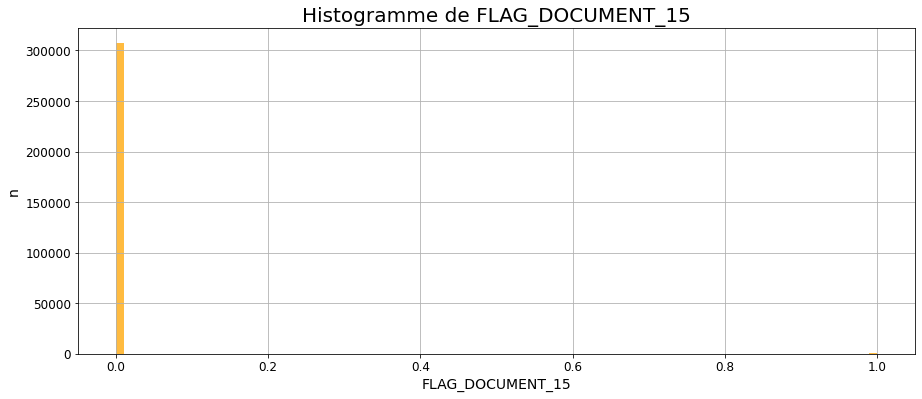

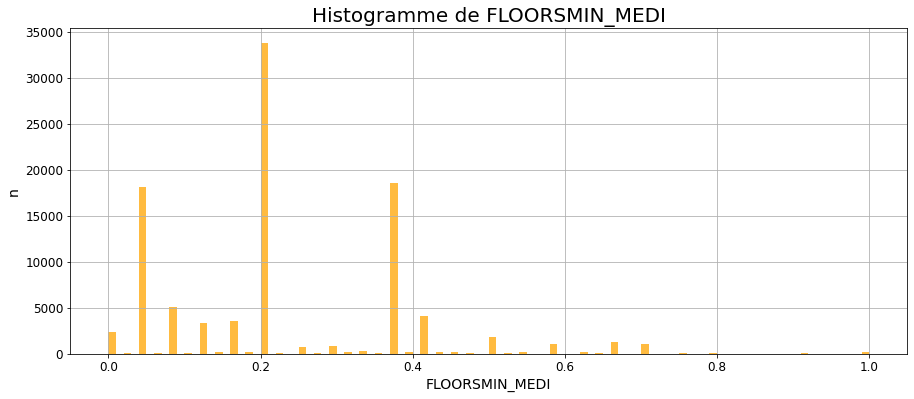

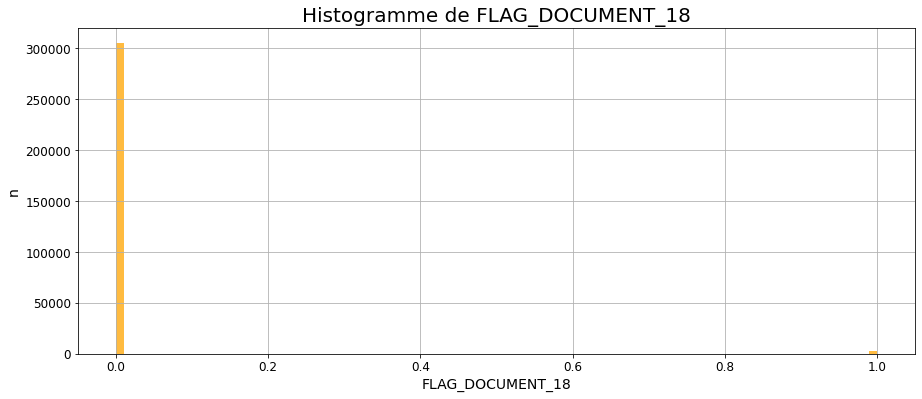

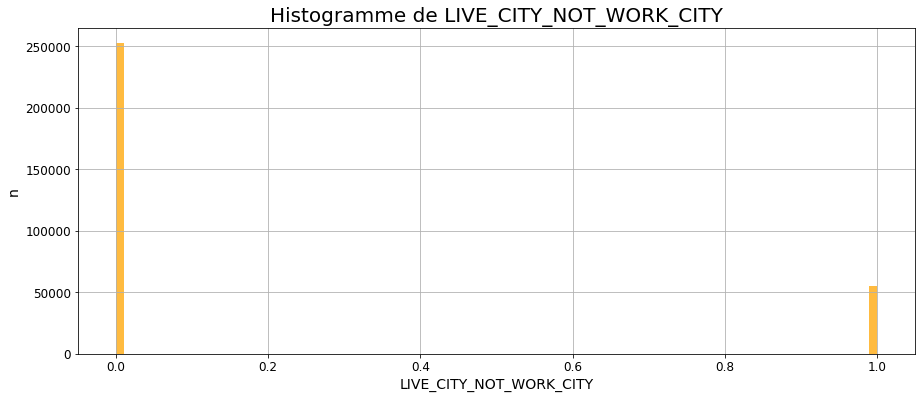

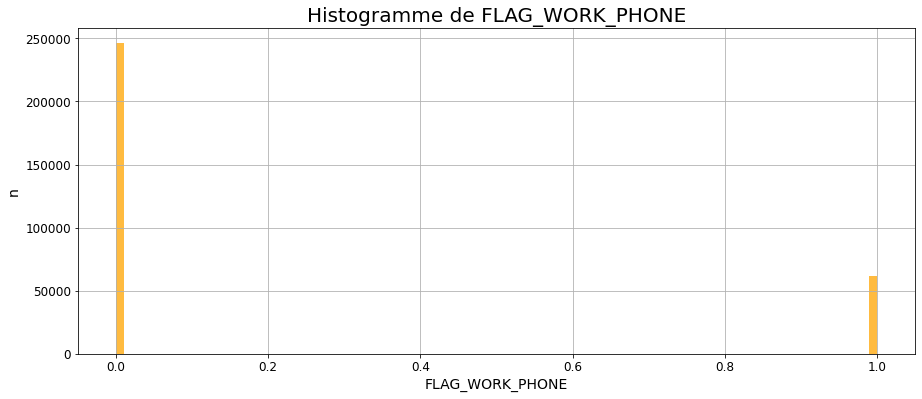

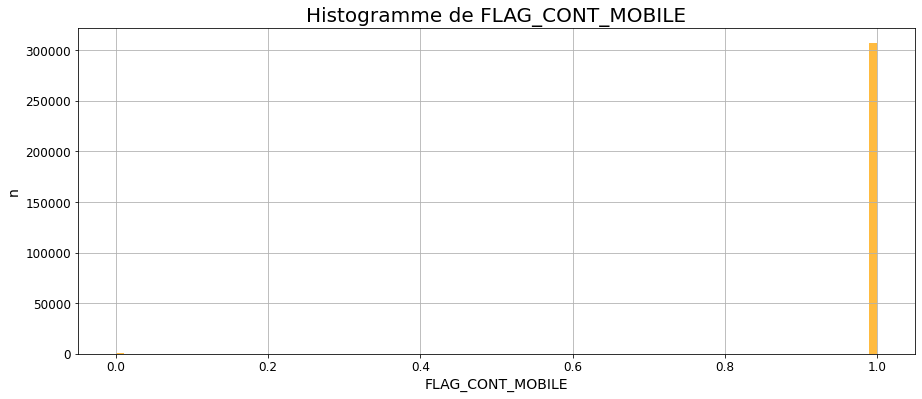

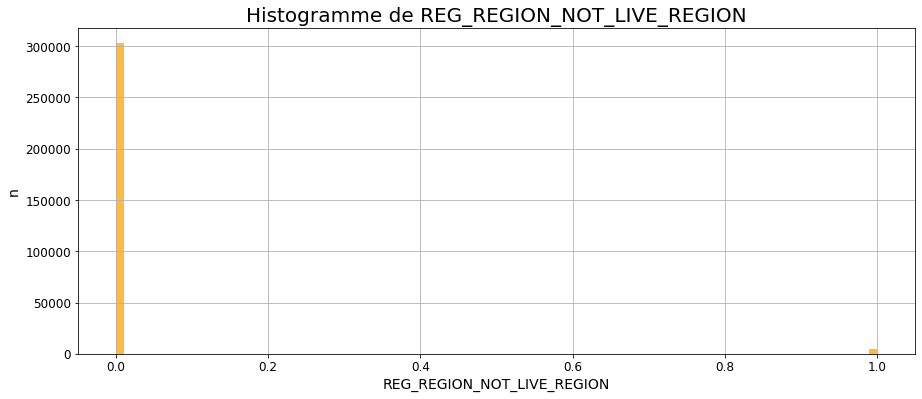

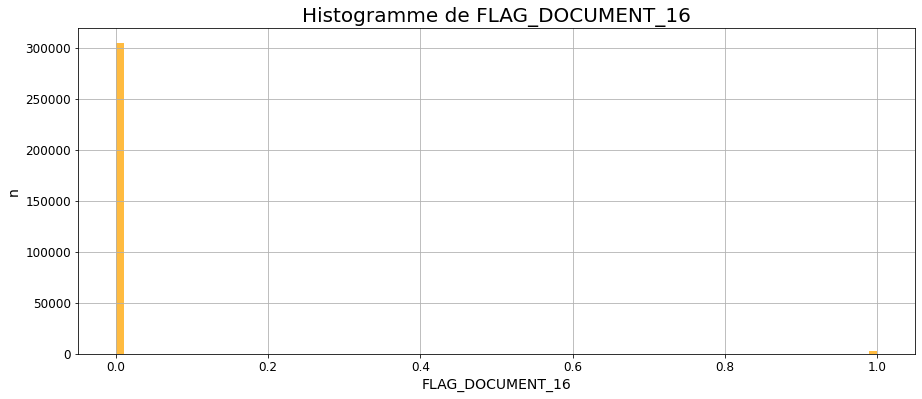

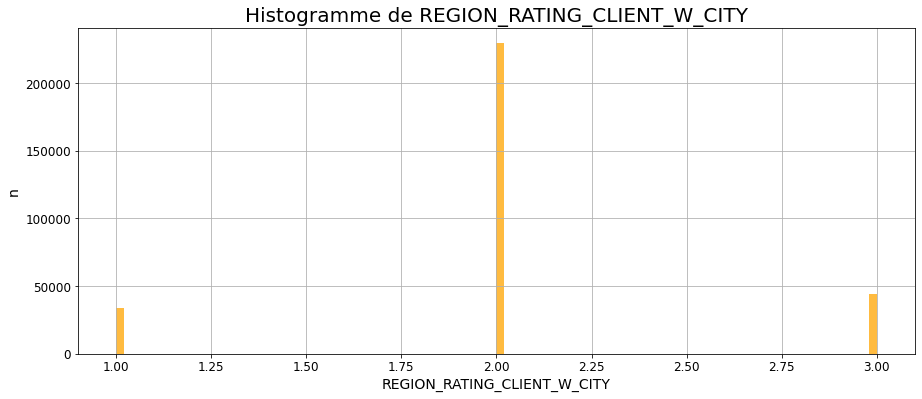

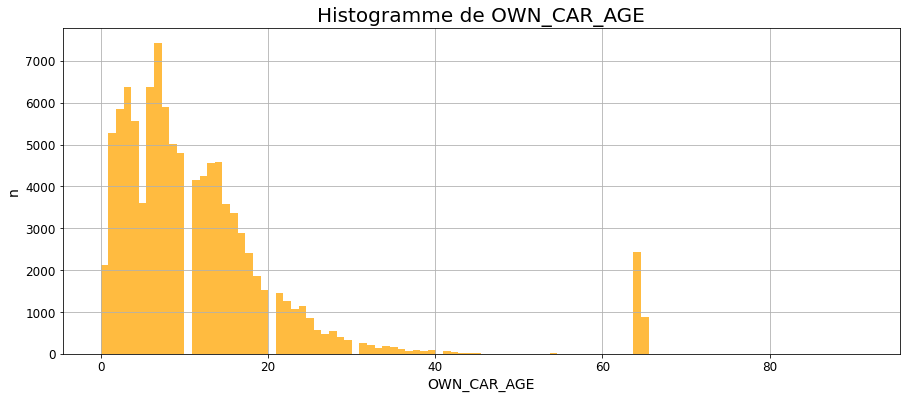

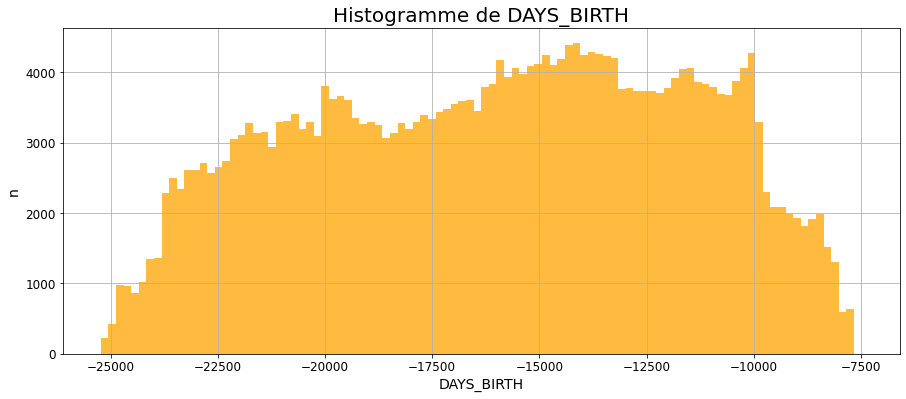

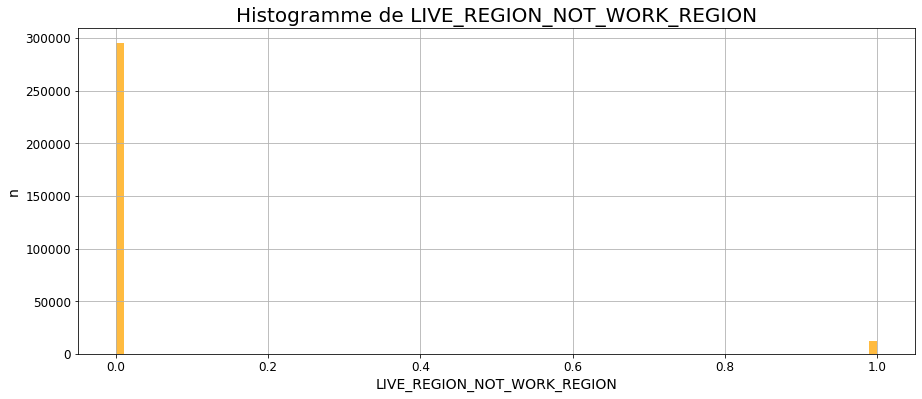

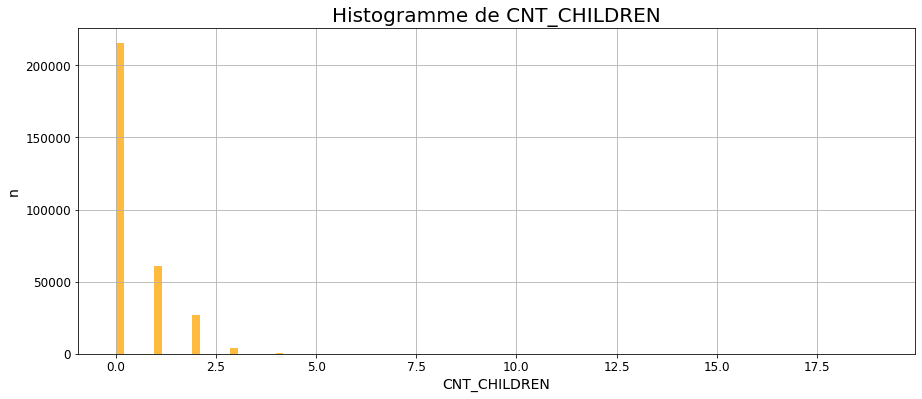

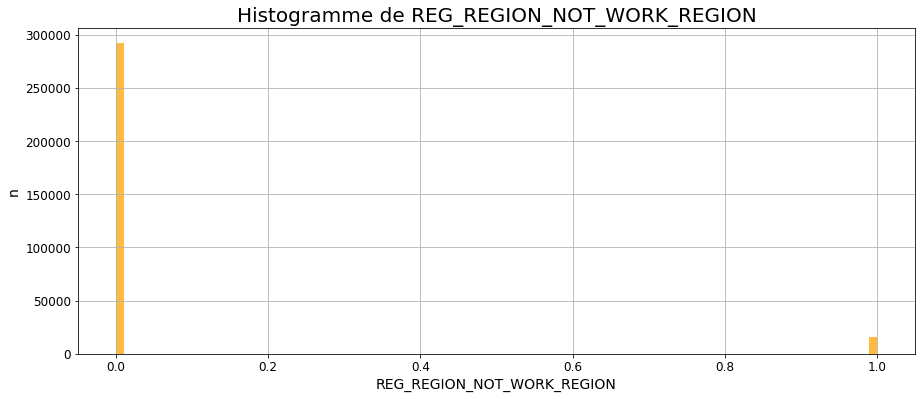

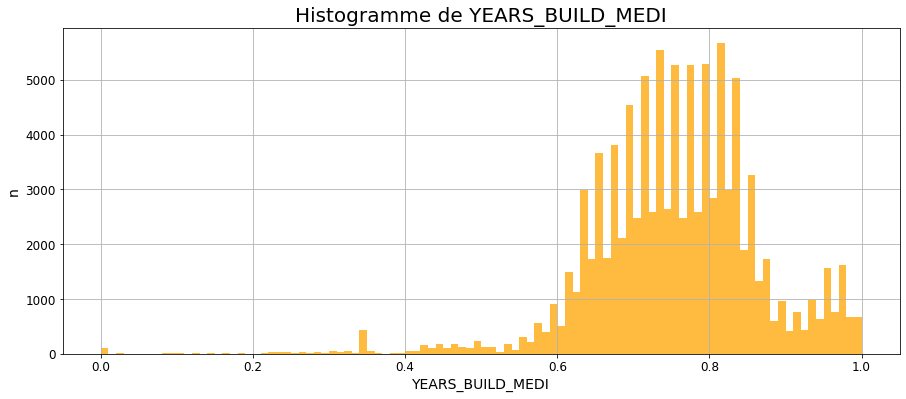

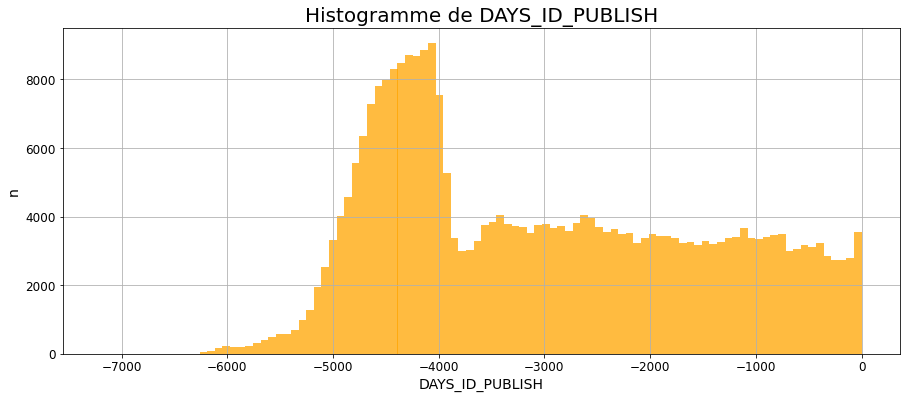

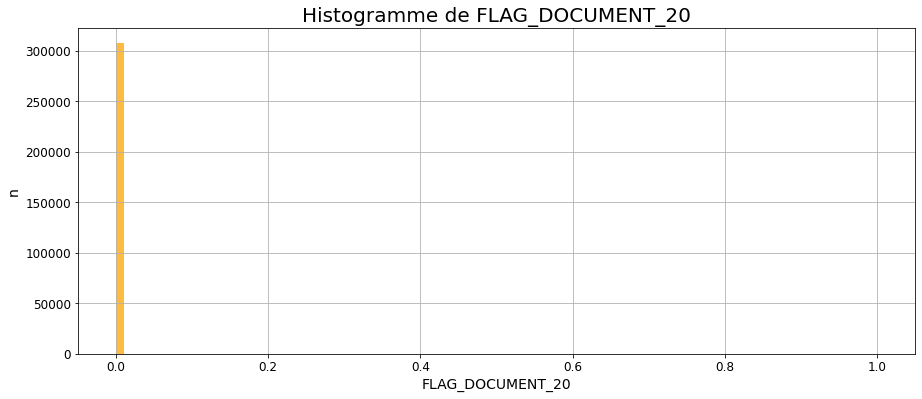

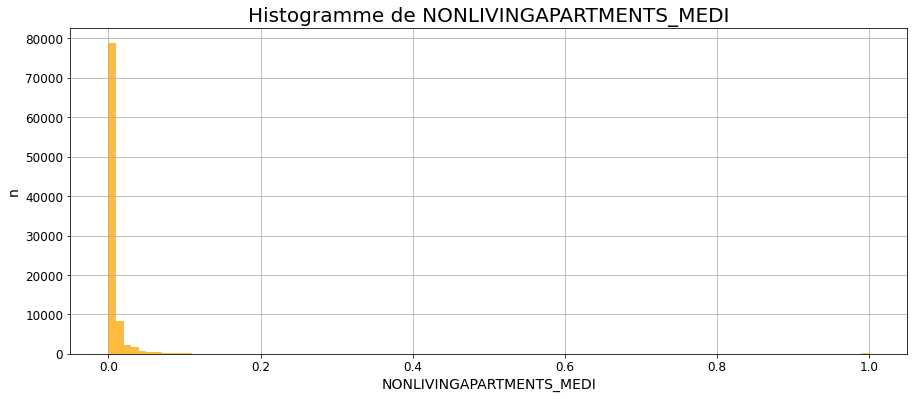

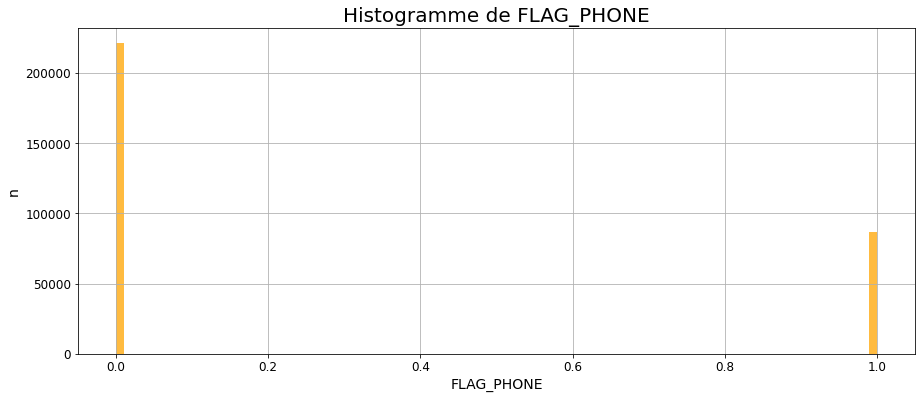

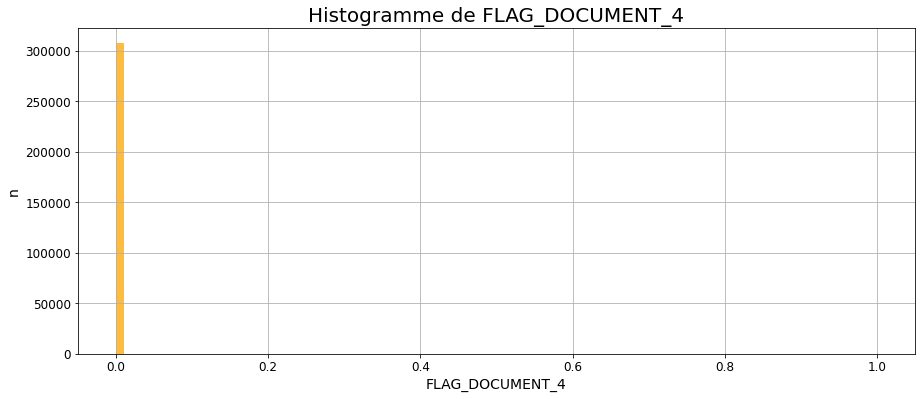

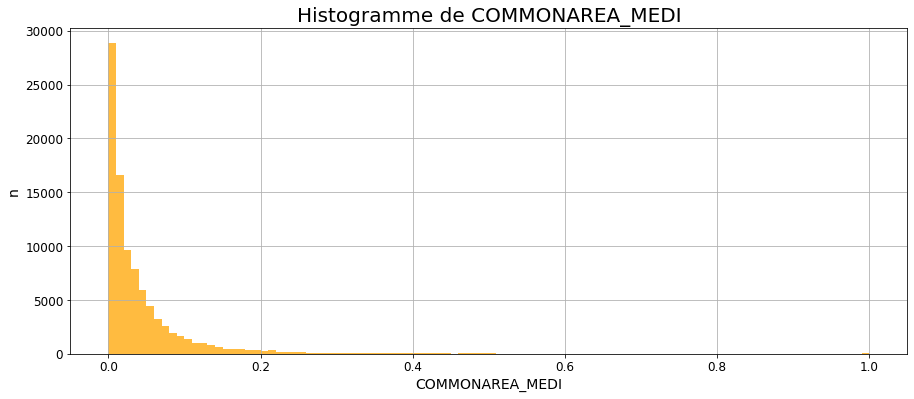

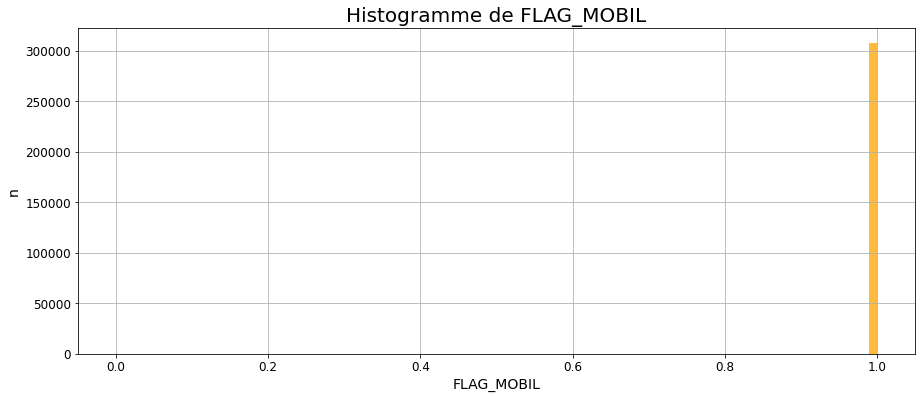

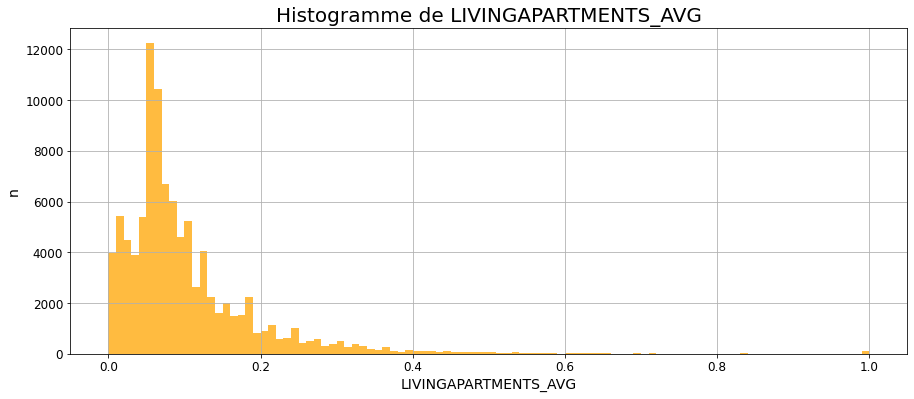

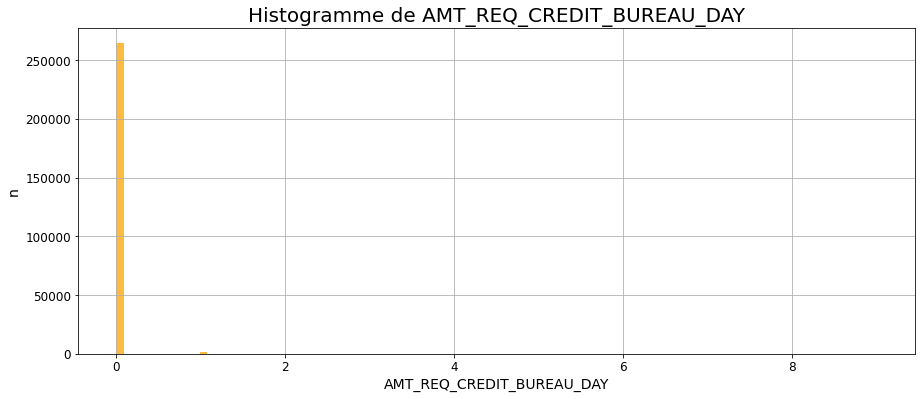

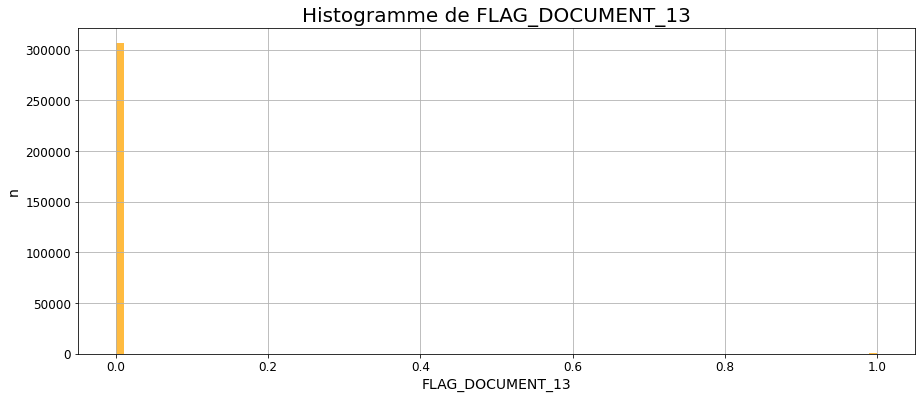

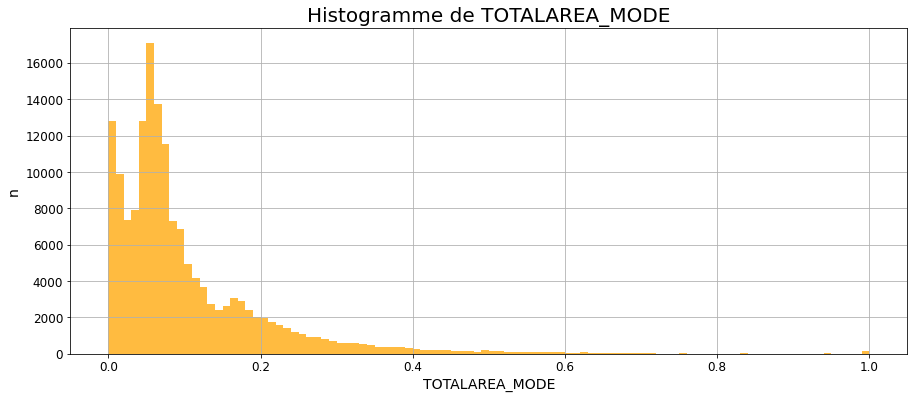

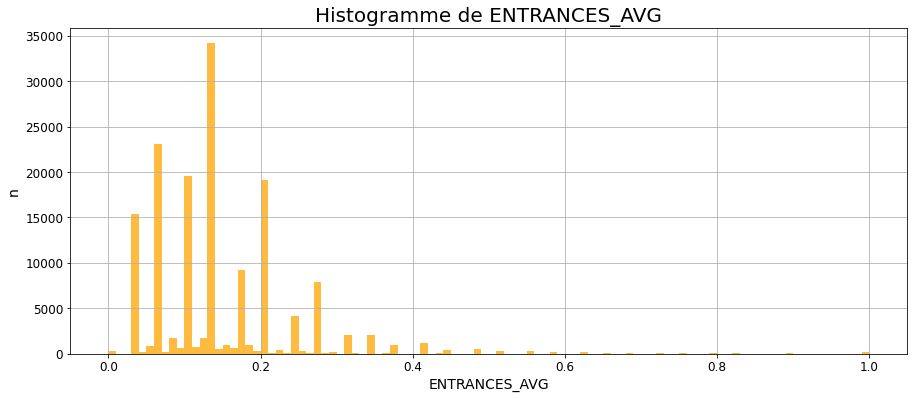

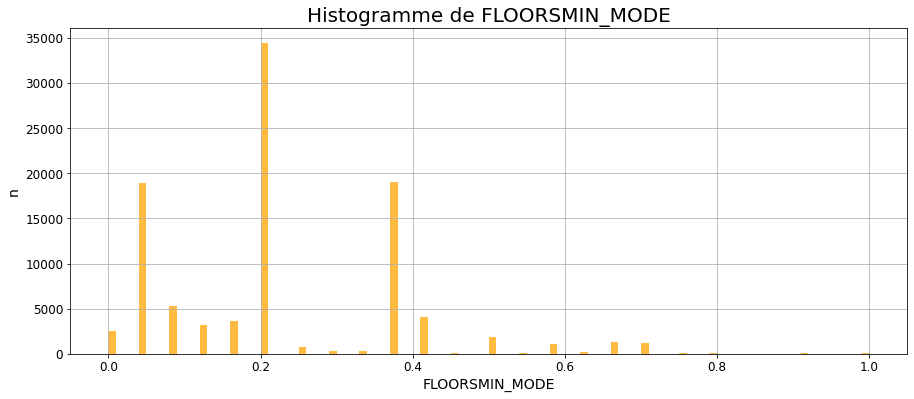

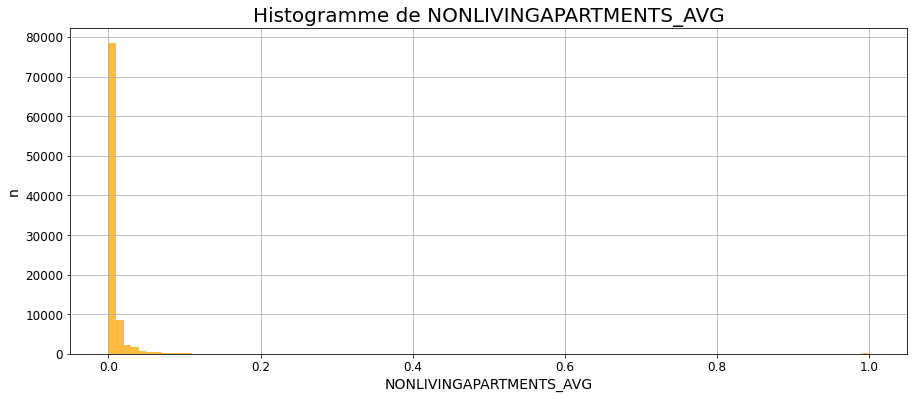

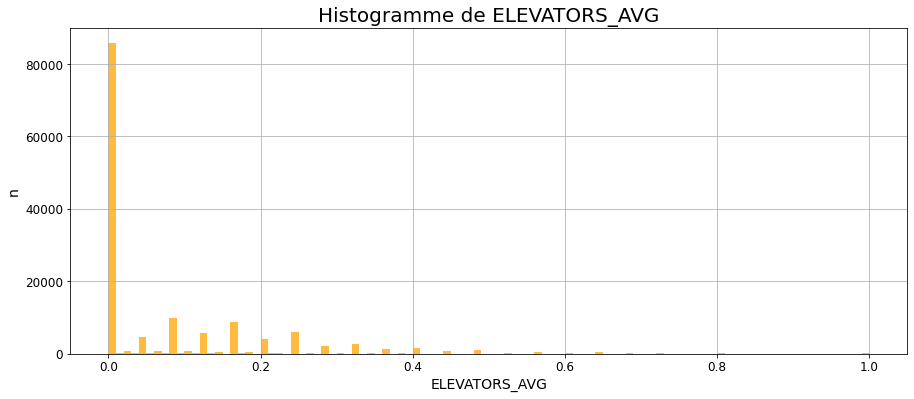

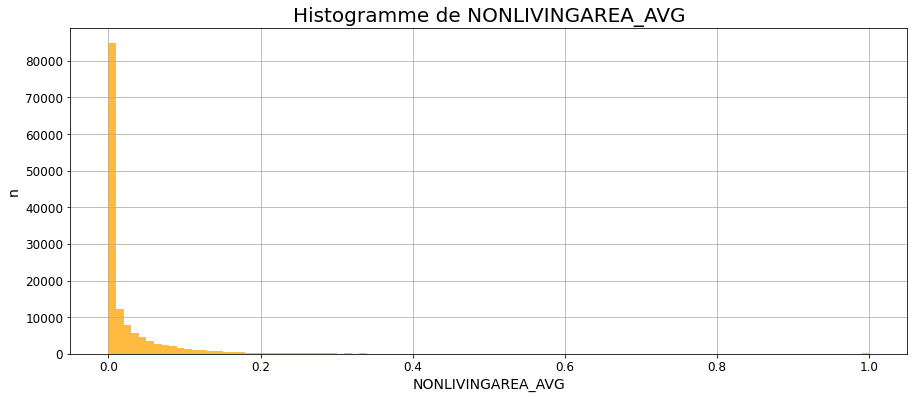

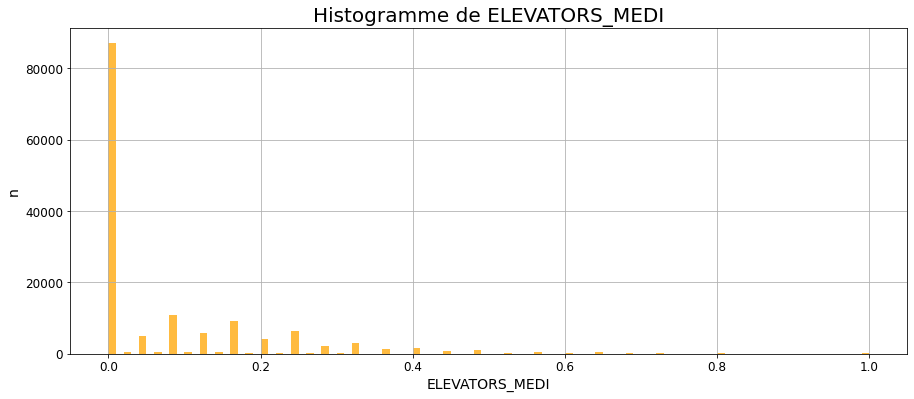

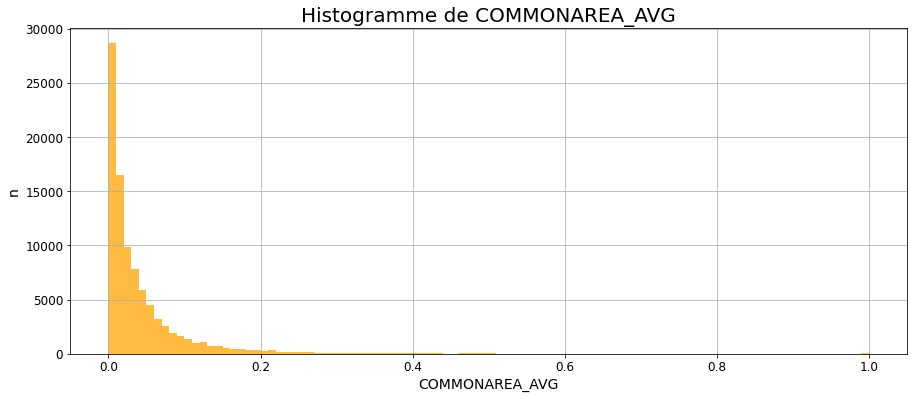

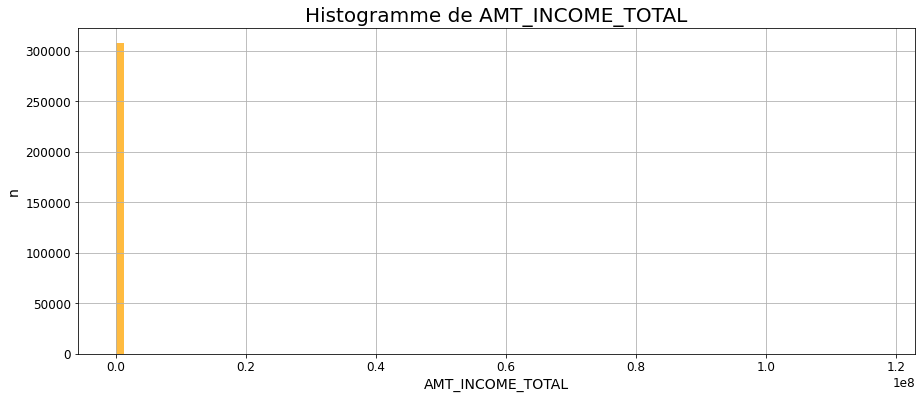

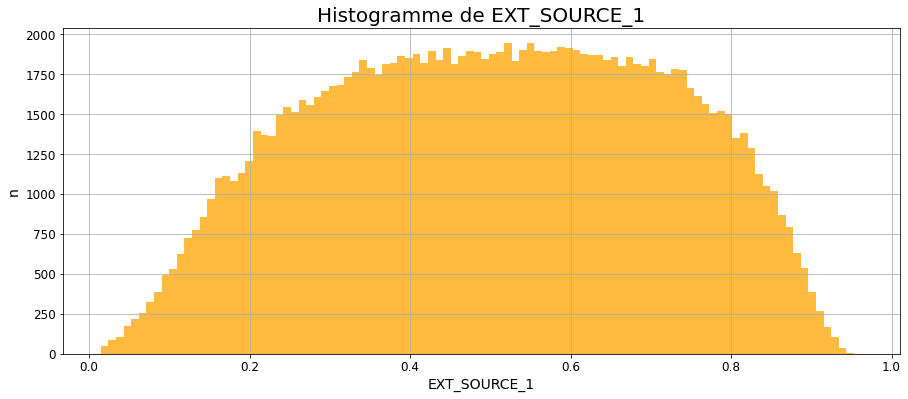

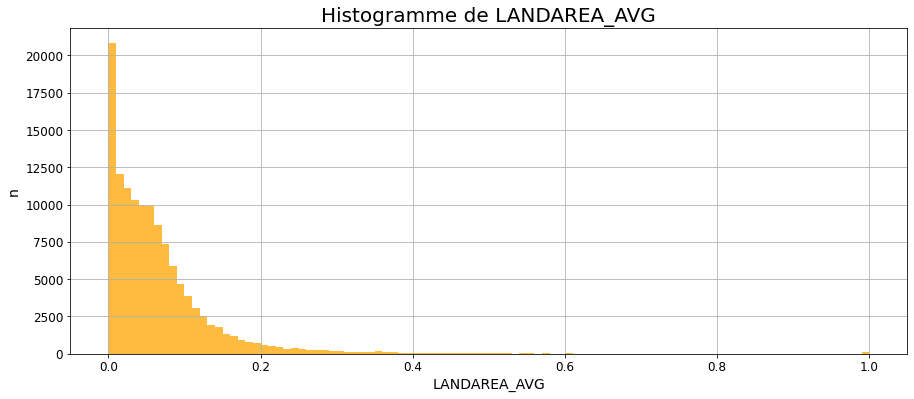

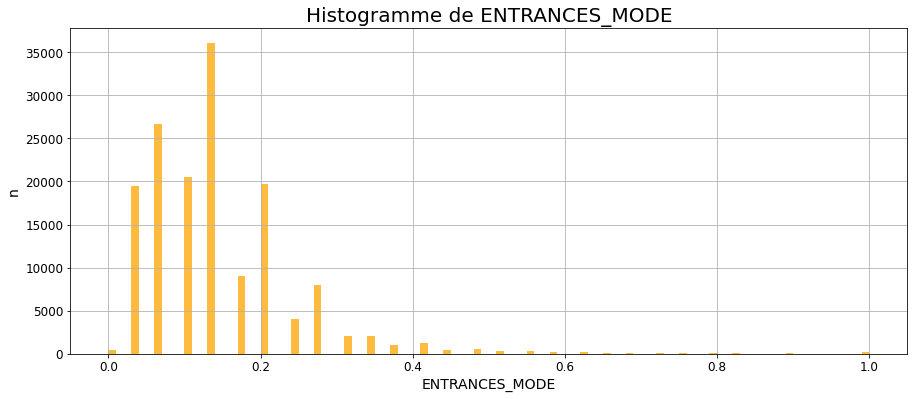

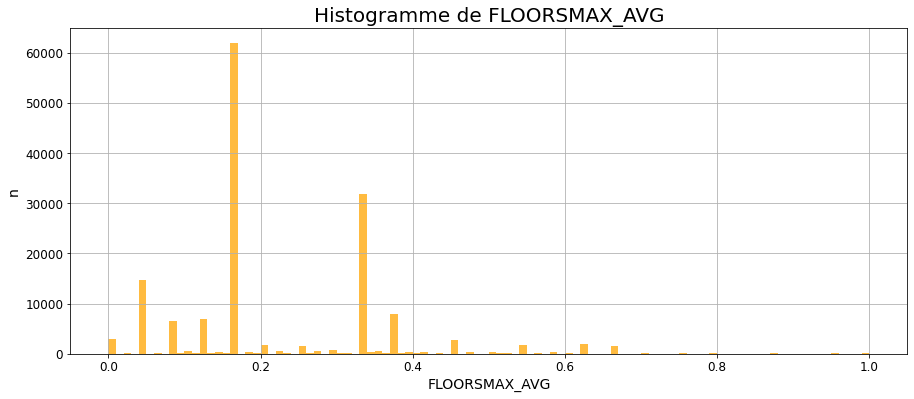

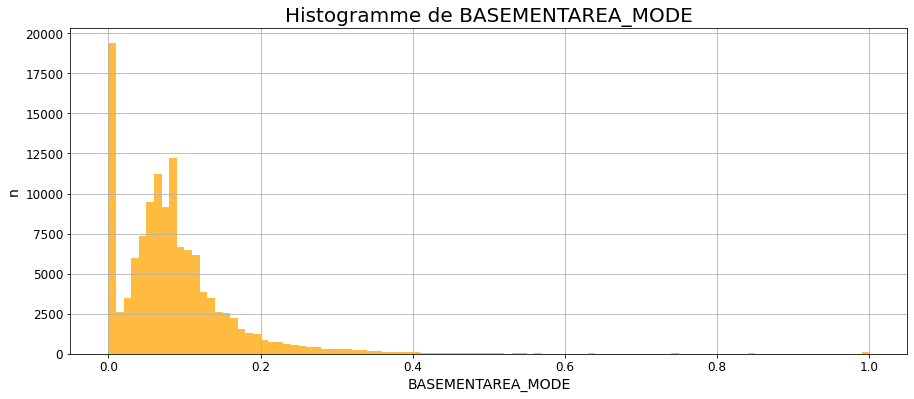

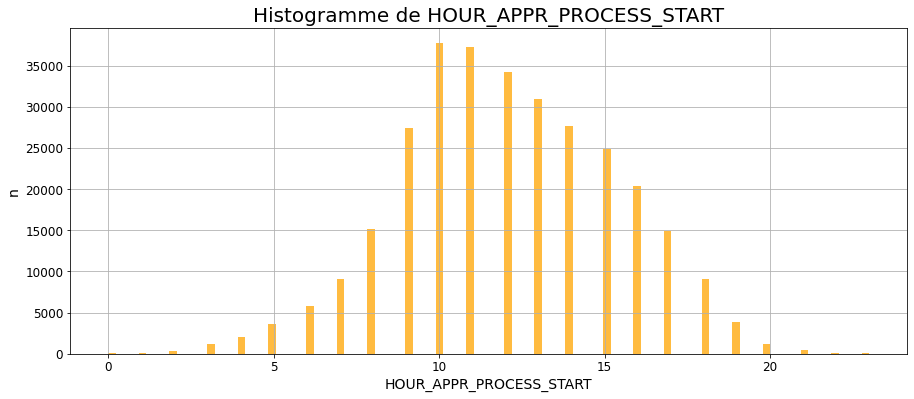

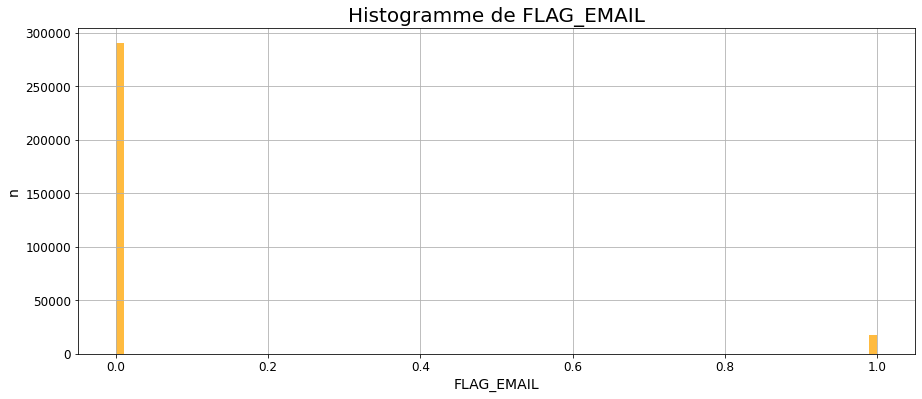

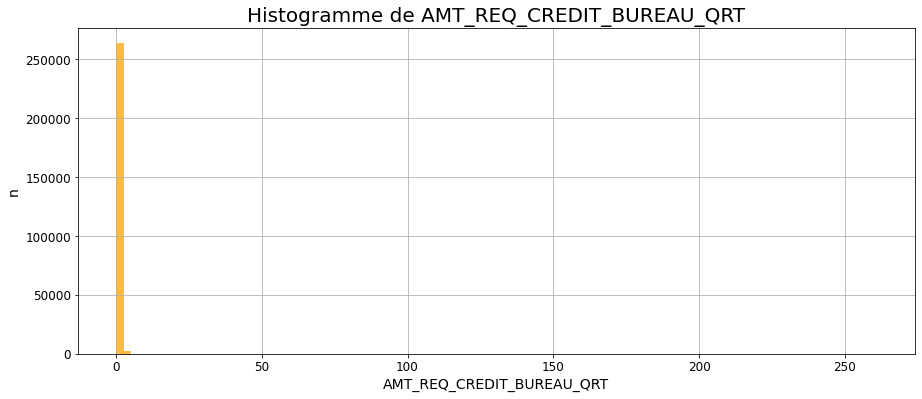

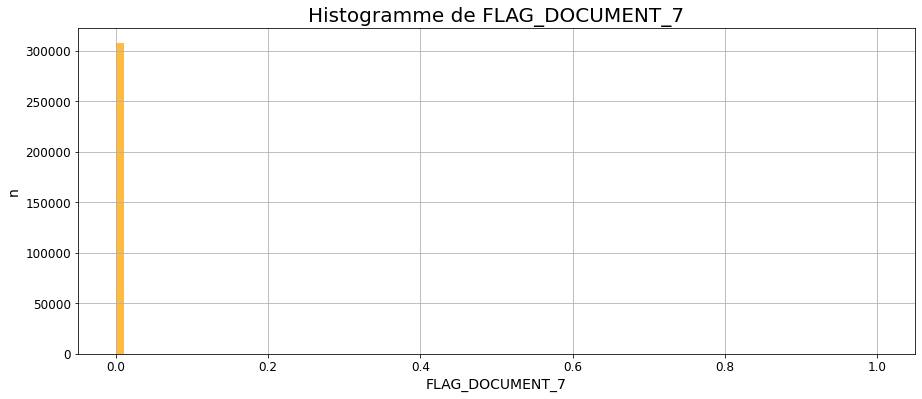

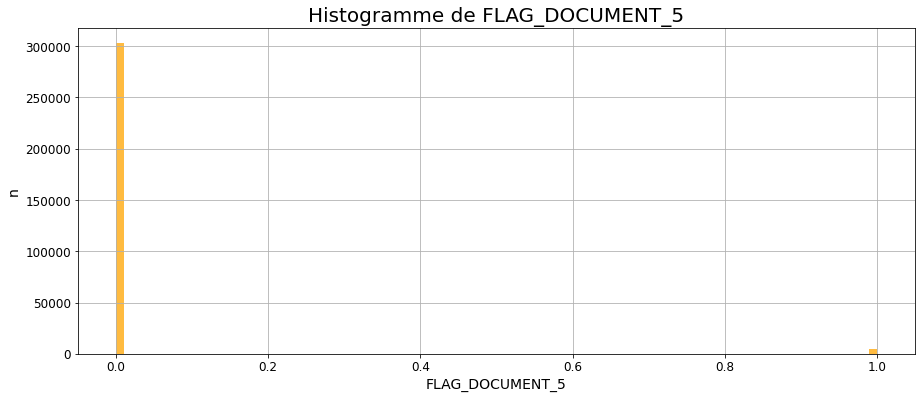

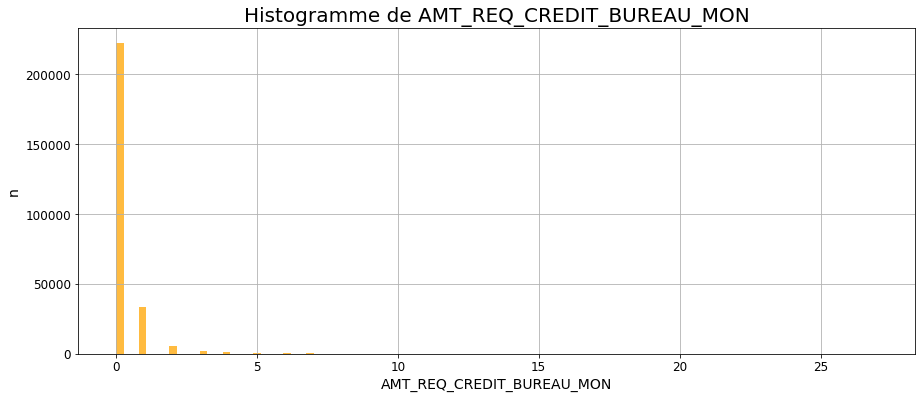

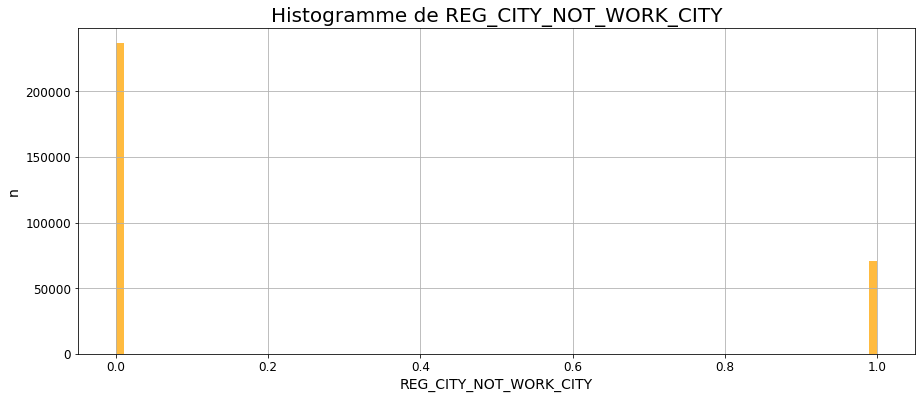

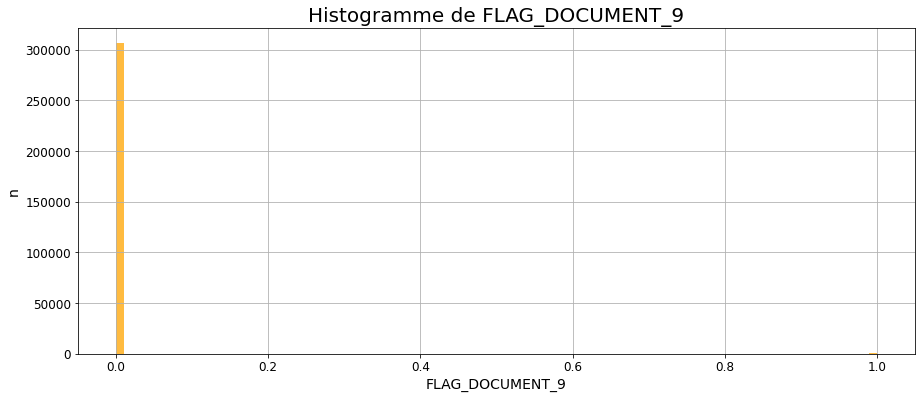

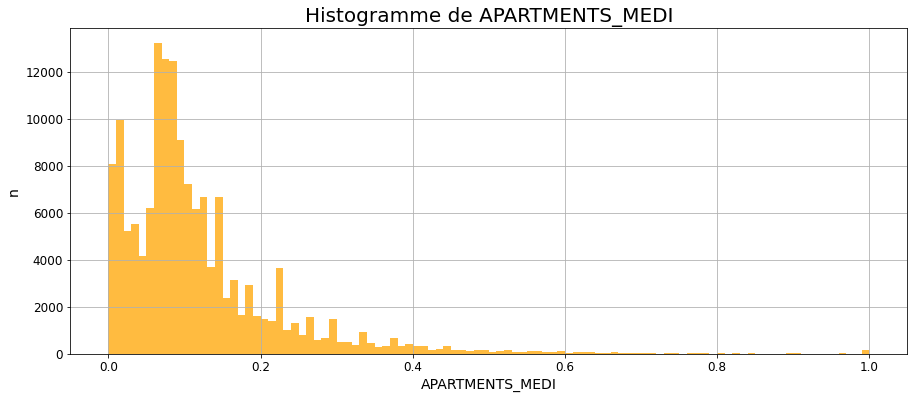

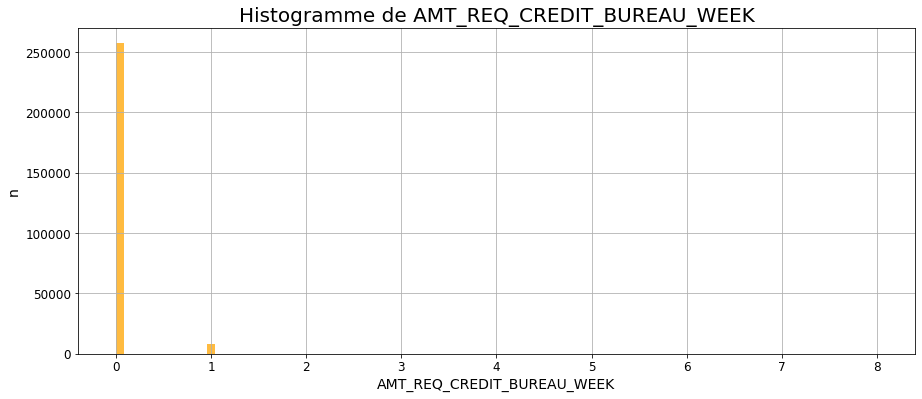

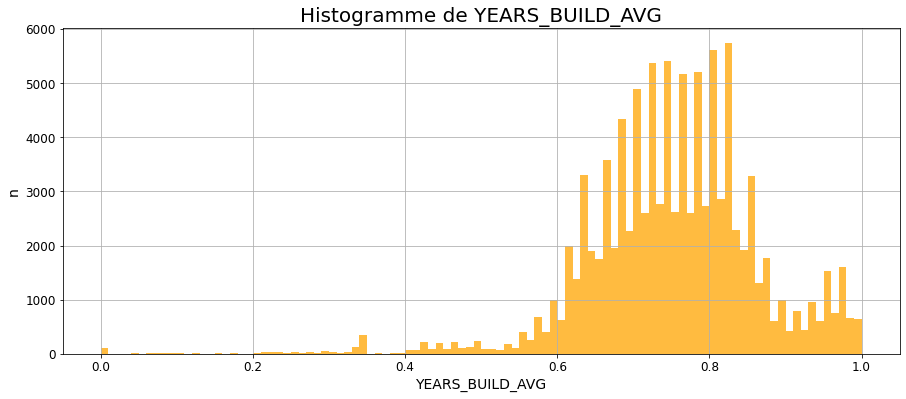

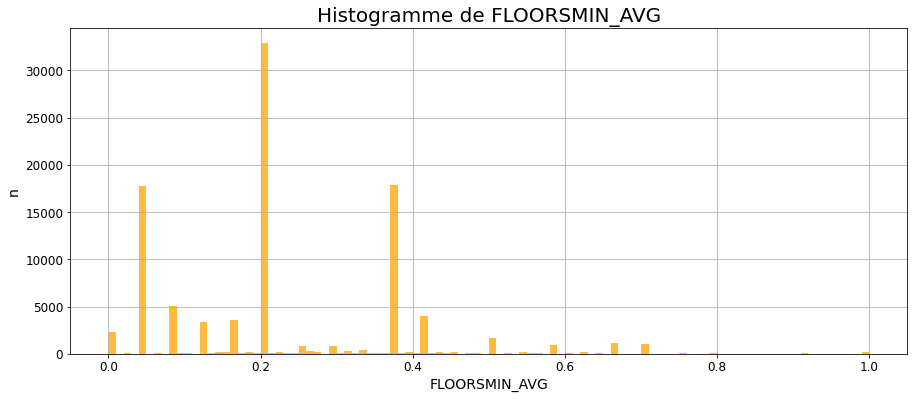

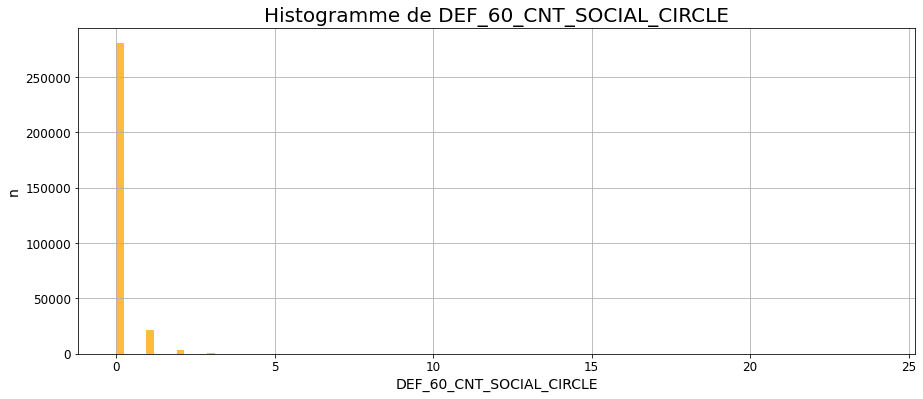

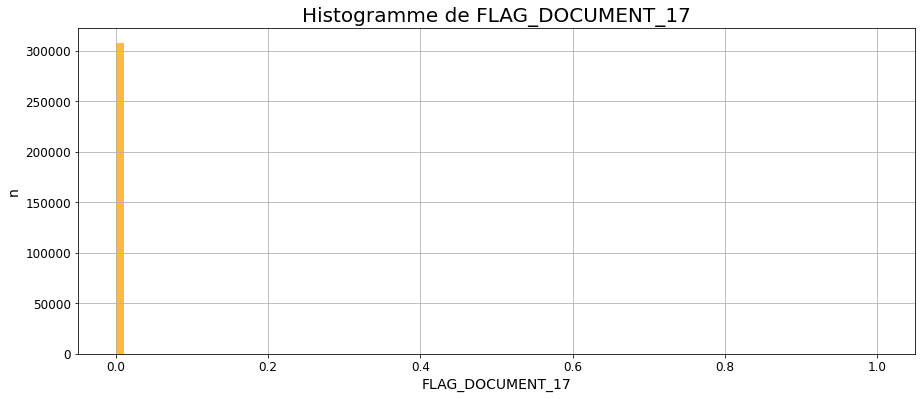

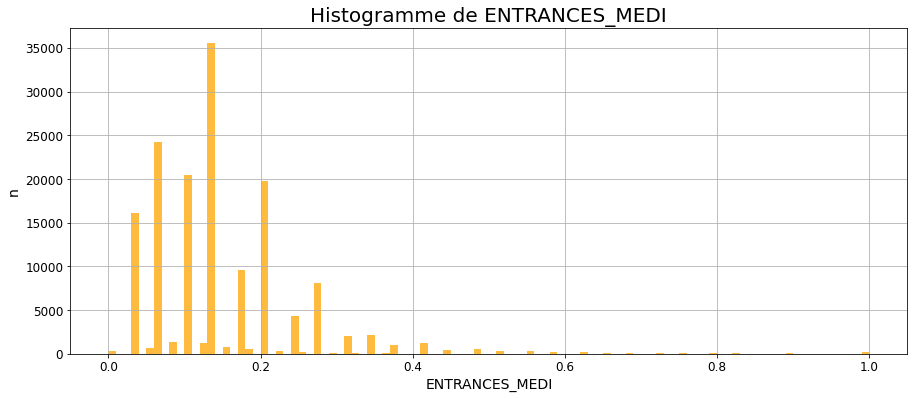

df_bureau
---------
num_cols = ['AMT_CREDIT_MAX_OVERDUE', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'DAYS_ENDDATE_FACT']
num_cols = ['AMT_CREDIT_MAX_OVERDUE', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'DAYS_ENDDATE_FACT']


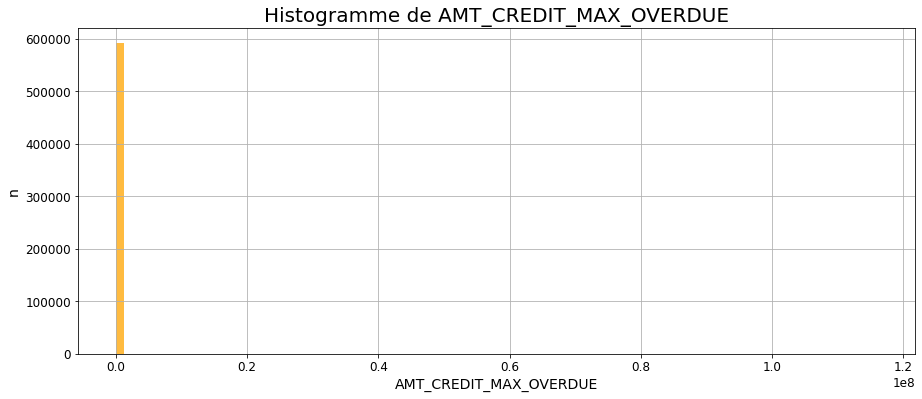

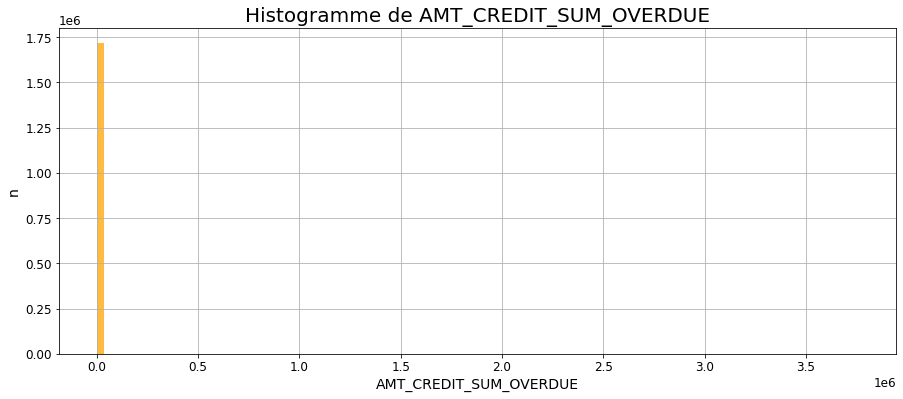

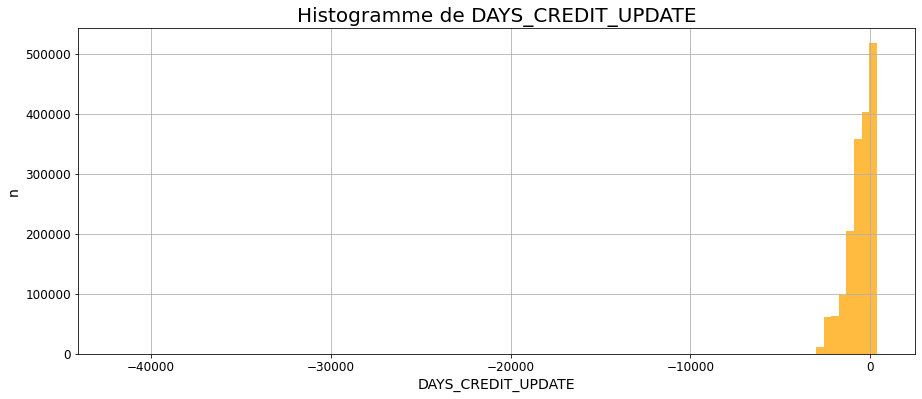

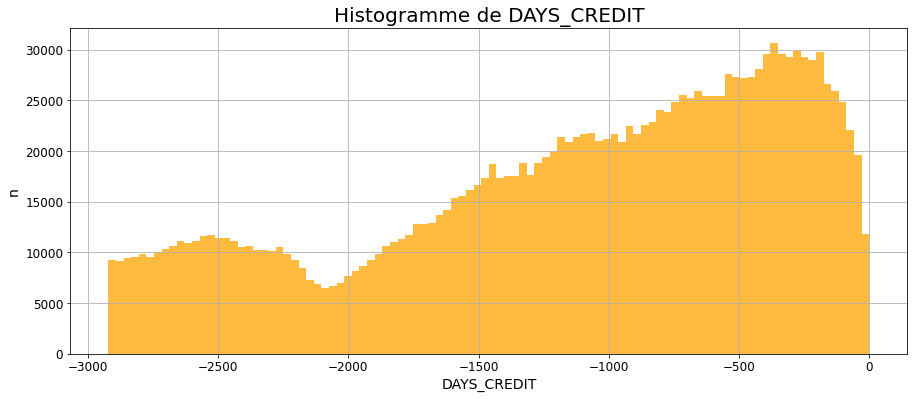

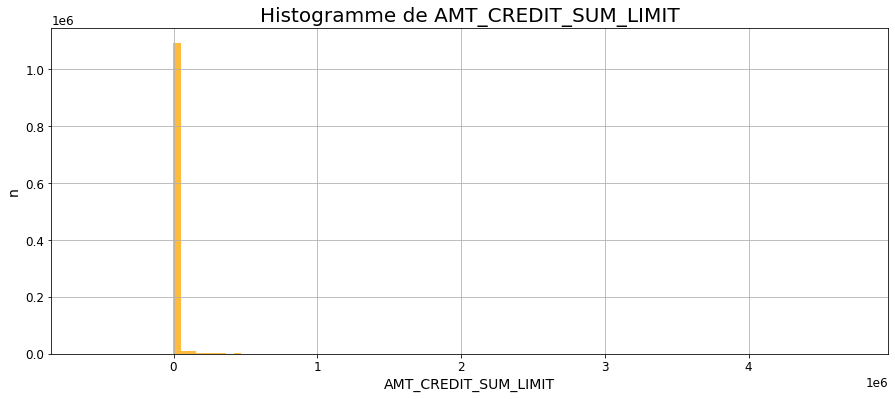

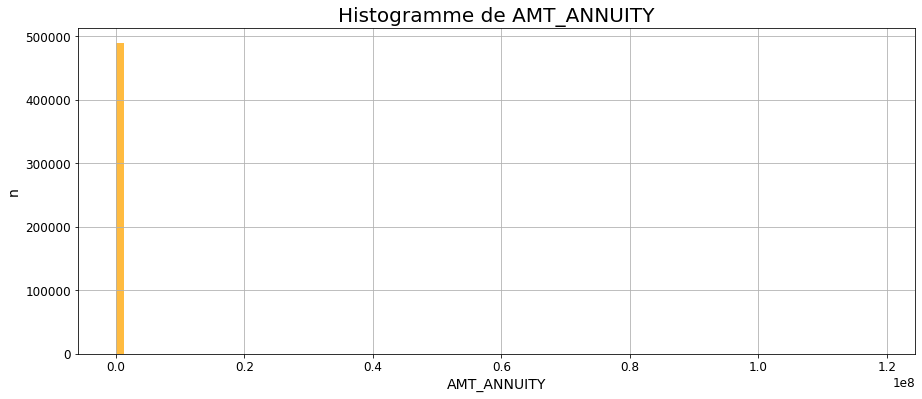

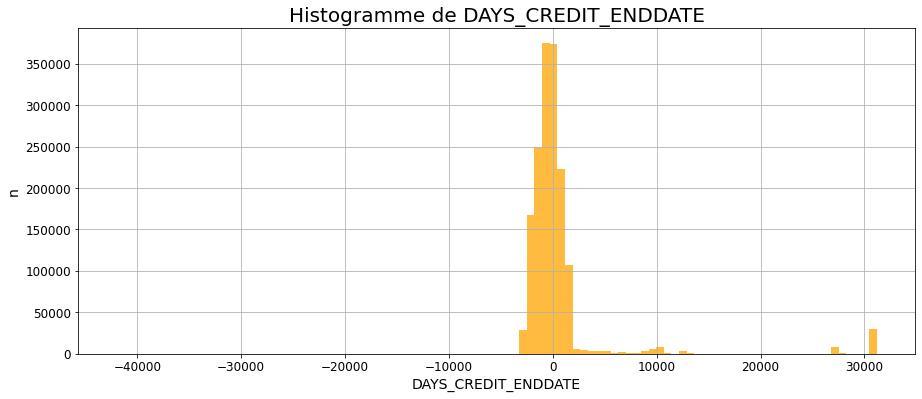

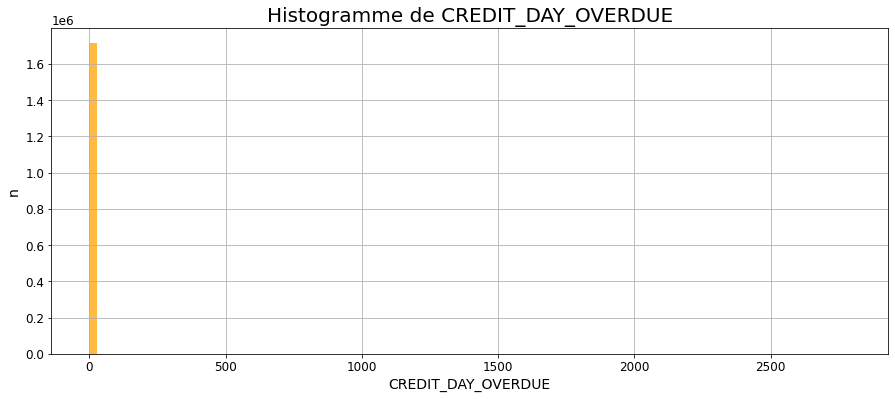

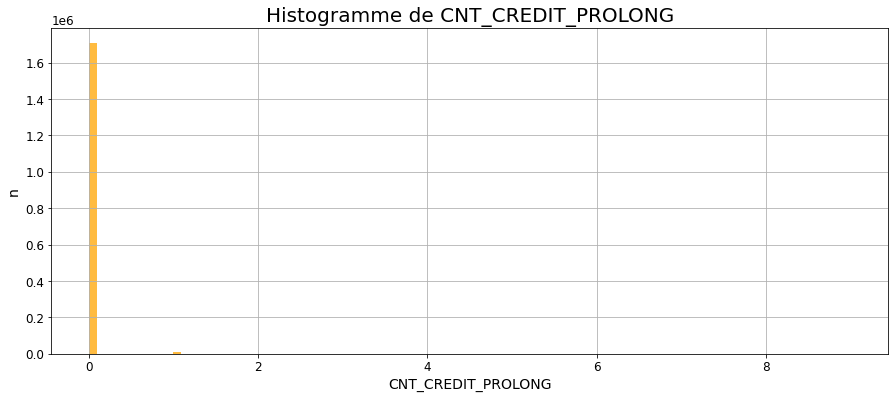

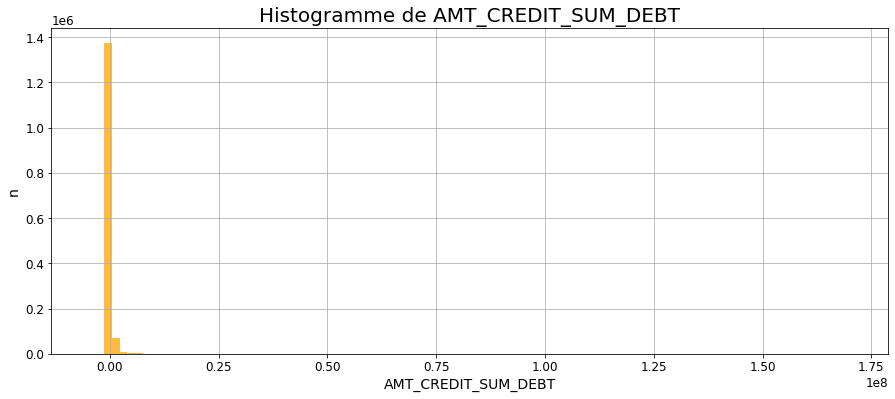

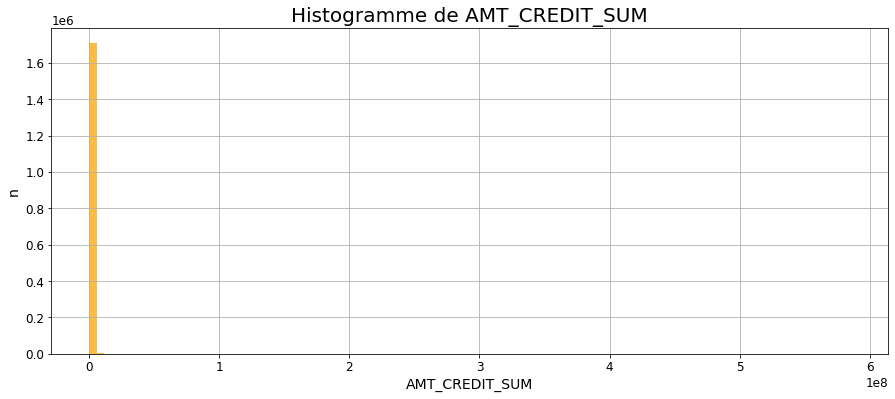

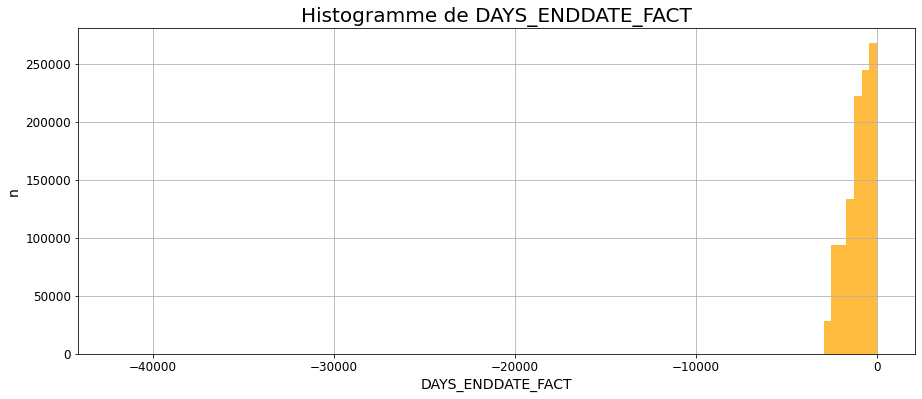

df_bureau_balance
-----------------
num_cols = ['MONTHS_BALANCE']
num_cols = ['MONTHS_BALANCE']


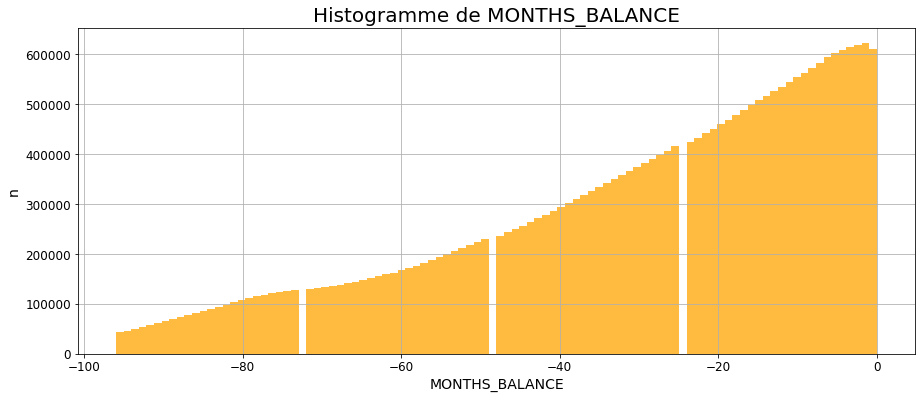

df_credit_card_balance
----------------------
num_cols = ['AMT_CREDIT_LIMIT_ACTUAL', 'SK_DPD_DEF', 'AMT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_INST_MIN_REGULARITY', 'AMT_RECIVABLE', 'AMT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_BALANCE', 'AMT_DRAWINGS_OTHER_CURRENT', 'SK_DPD', 'MONTHS_BALANCE', 'AMT_TOTAL_RECEIVABLE', 'AMT_PAYMENT_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'AMT_PAYMENT_TOTAL_CURRENT']
num_cols = ['AMT_CREDIT_LIMIT_ACTUAL', 'SK_DPD_DEF', 'AMT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_INST_MIN_REGULARITY', 'AMT_RECIVABLE', 'AMT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_BALANCE', 'AMT_DRAWINGS_OTHER_CURRENT', 'SK_DPD', 'MONTHS_BALANCE', 'AMT_TOTAL_RECEIVABLE', 'AMT_PAYMENT_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_INSTALMENT_MATURE_CUM

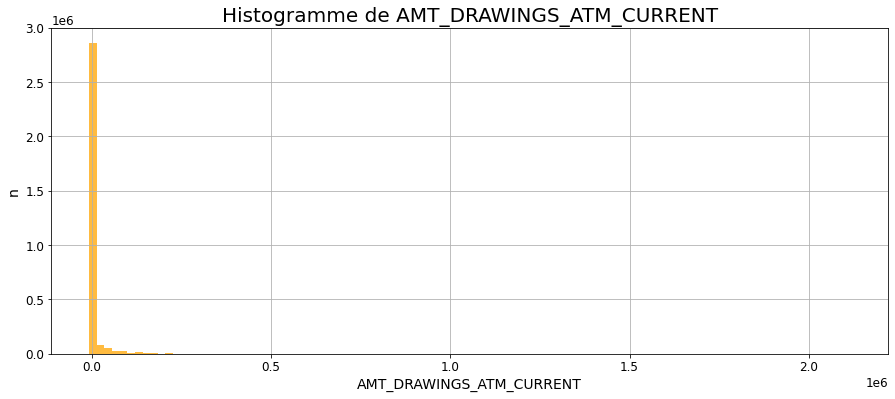

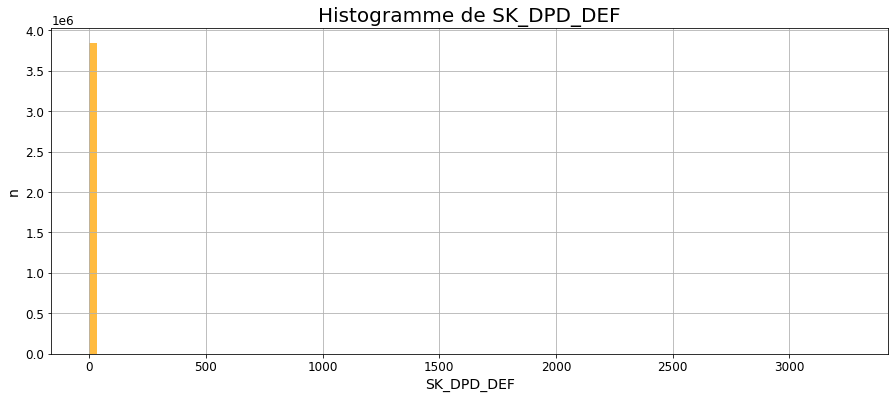

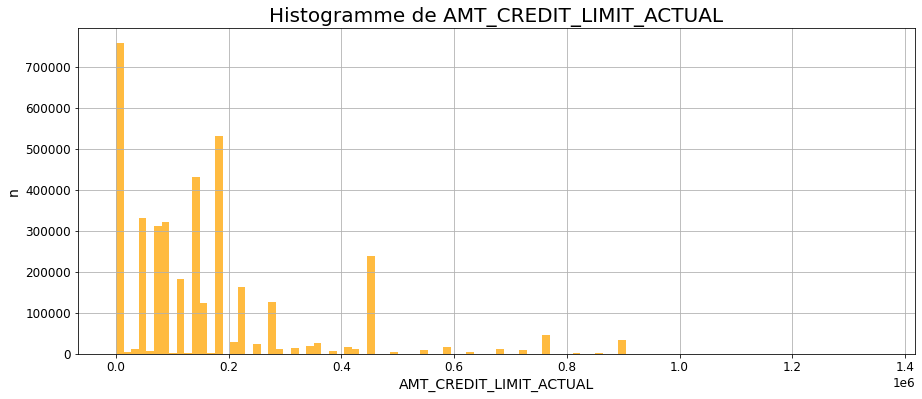

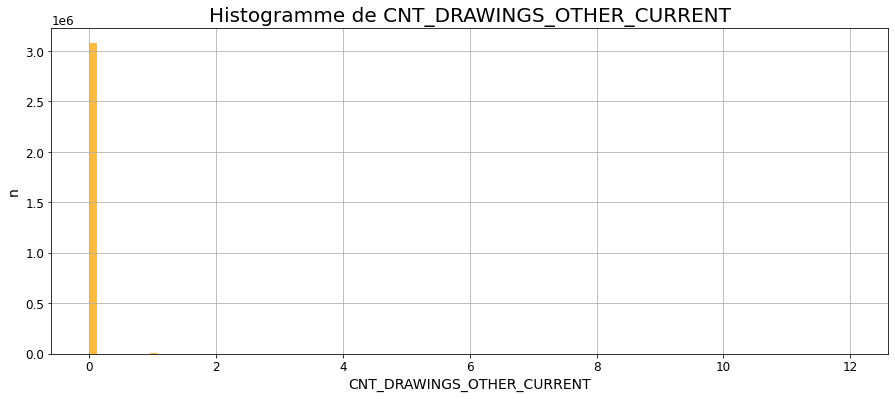

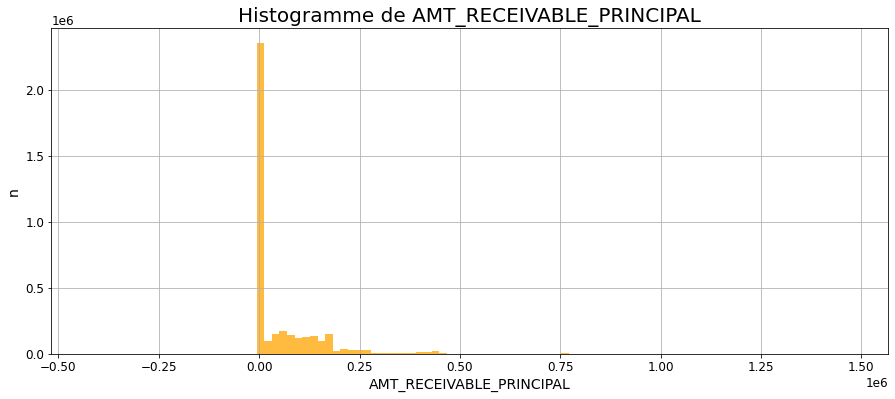

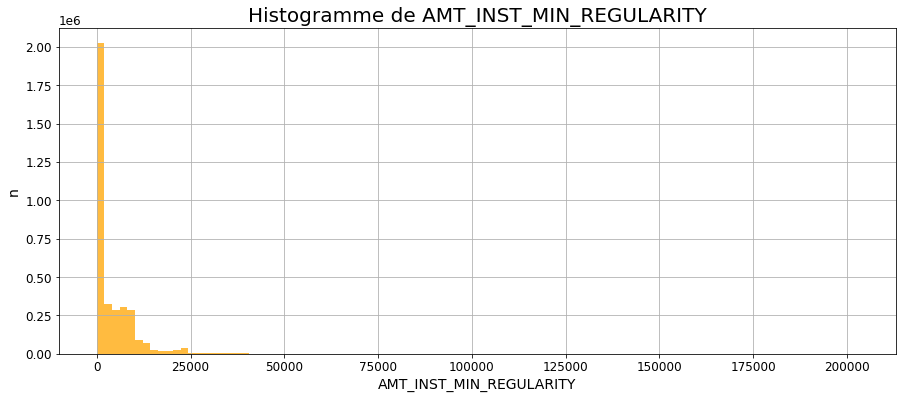

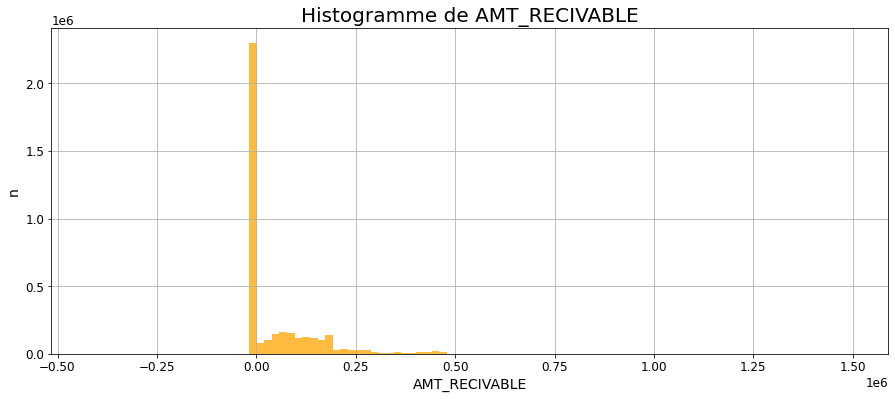

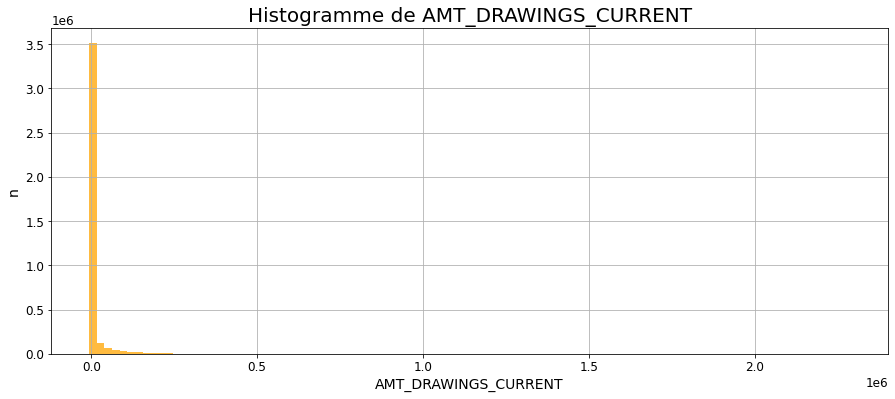

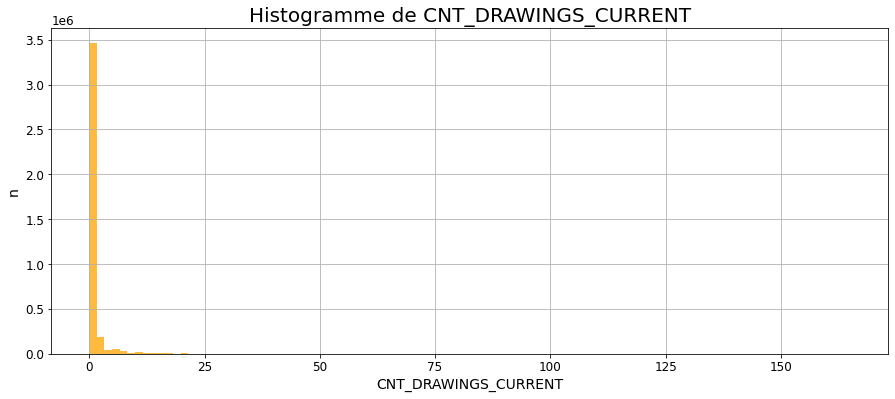

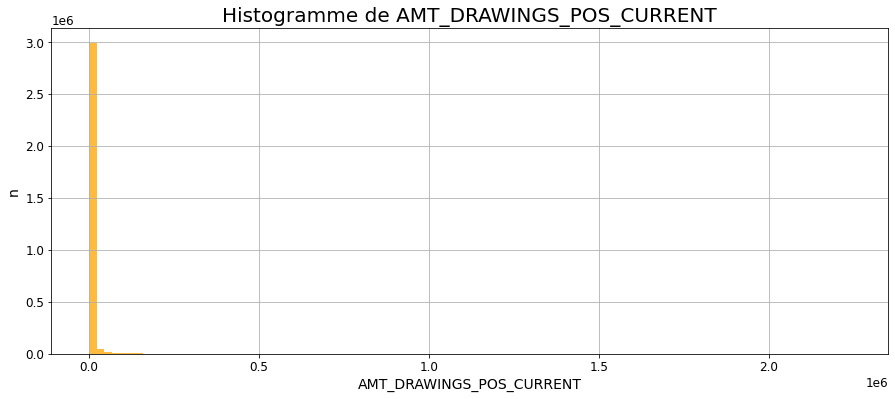

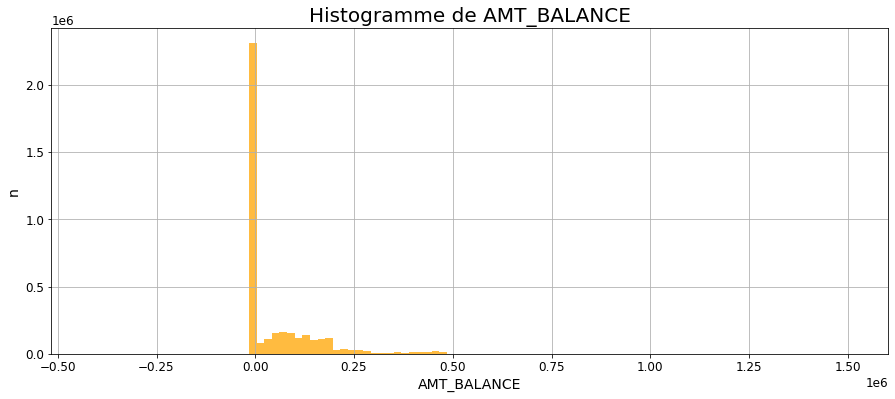

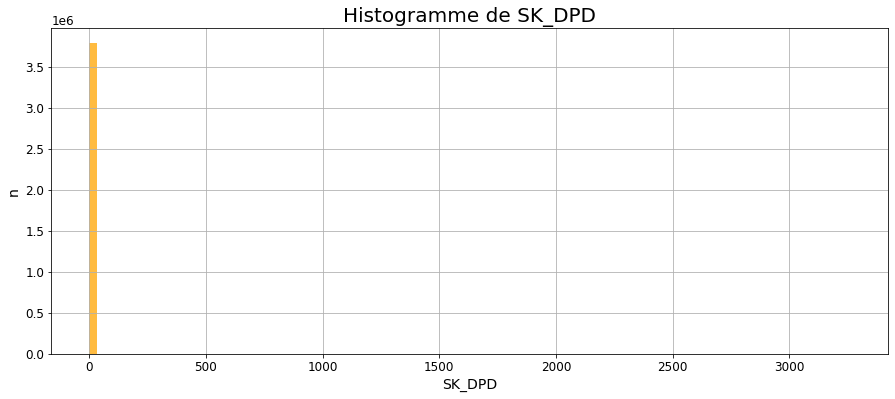

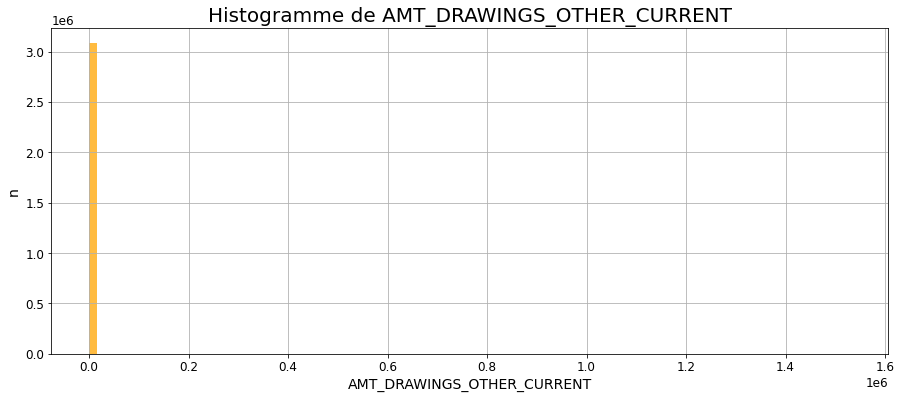

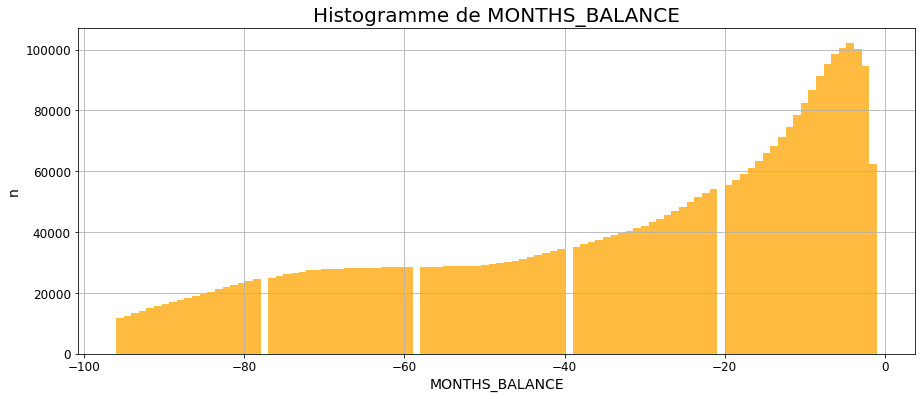

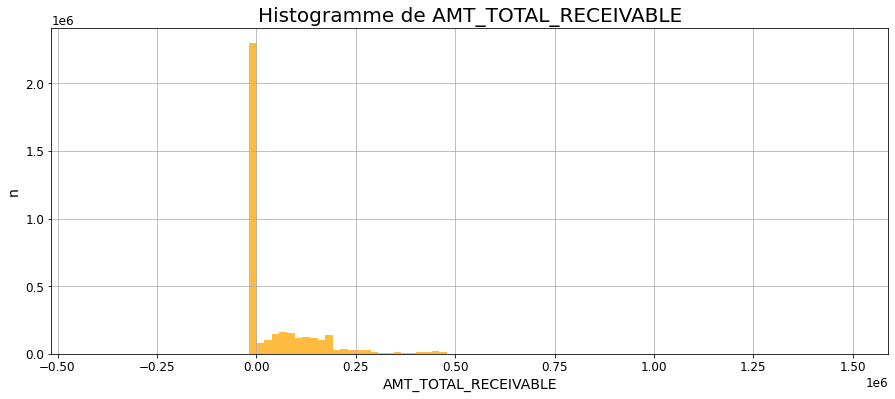

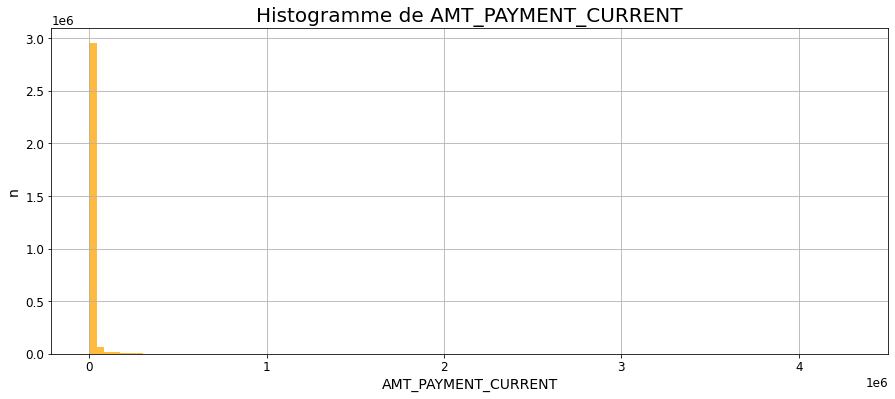

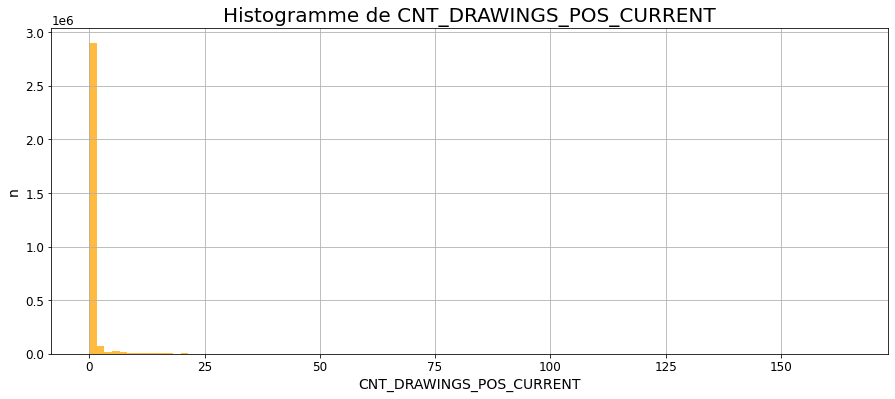

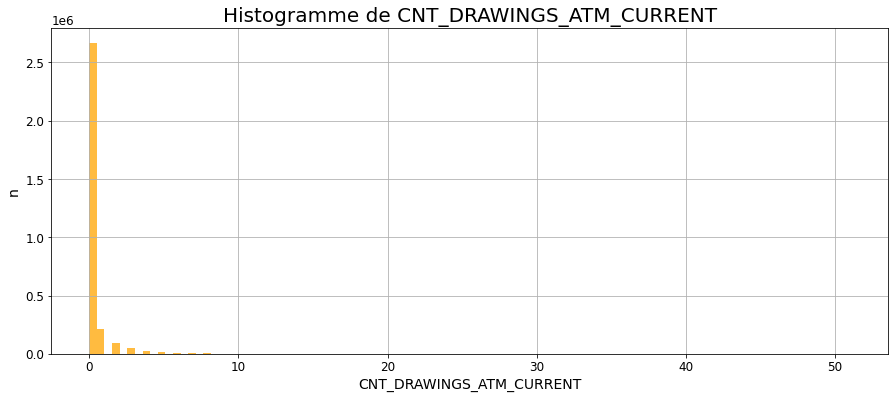

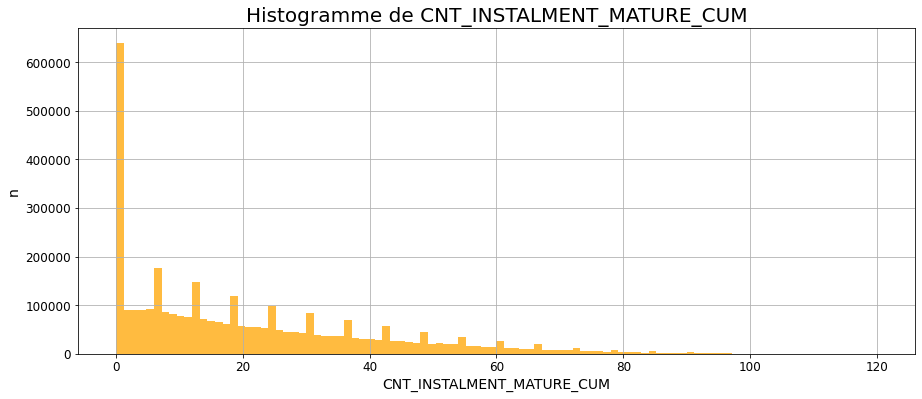

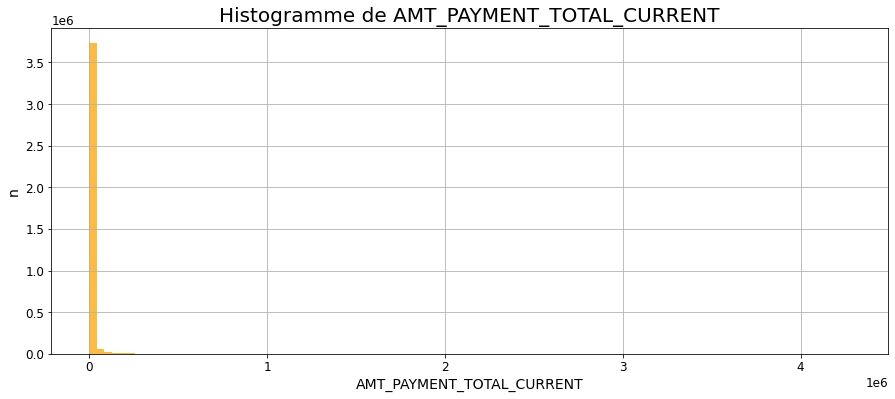

df_installments_payments
------------------------
num_cols = ['DAYS_INSTALMENT', 'NUM_INSTALMENT_NUMBER', 'NUM_INSTALMENT_VERSION', 'AMT_PAYMENT', 'AMT_INSTALMENT', 'DAYS_ENTRY_PAYMENT']
num_cols = ['DAYS_INSTALMENT', 'NUM_INSTALMENT_NUMBER', 'NUM_INSTALMENT_VERSION', 'AMT_PAYMENT', 'AMT_INSTALMENT', 'DAYS_ENTRY_PAYMENT']


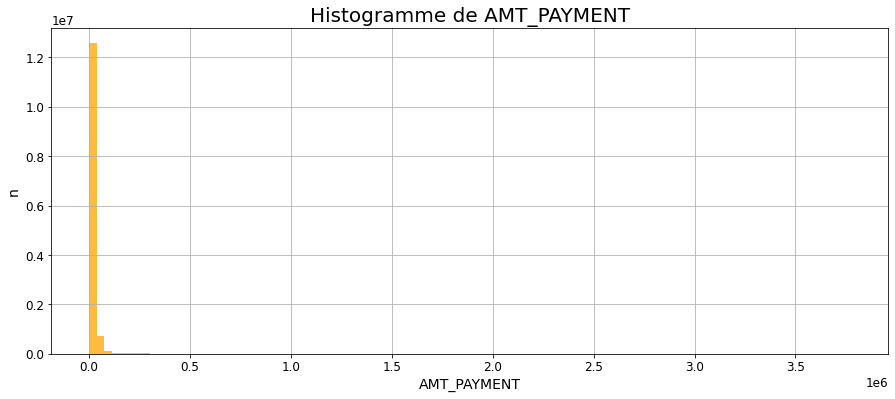

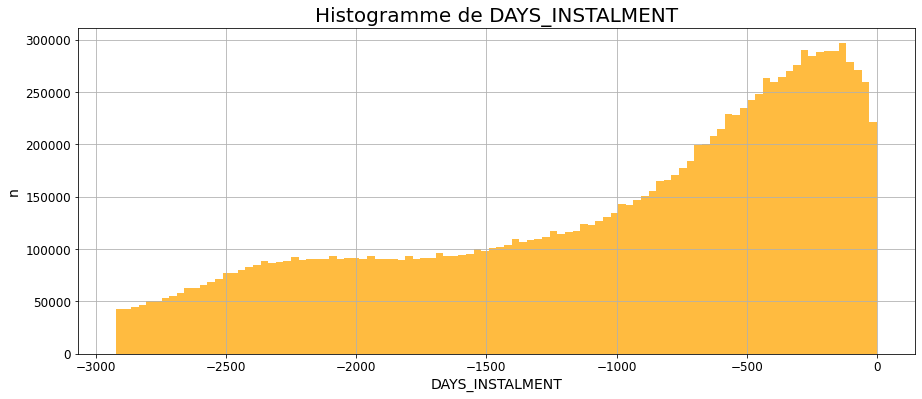

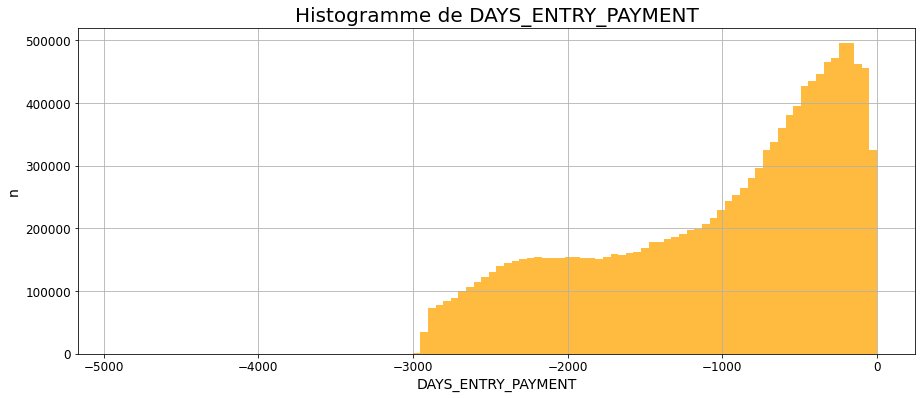

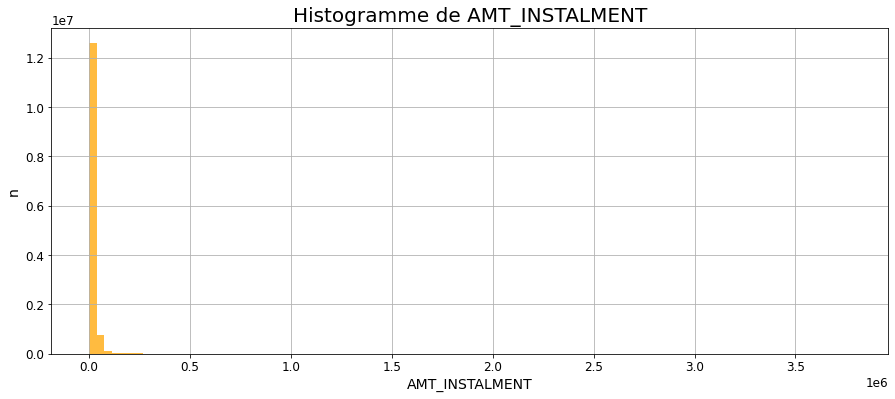

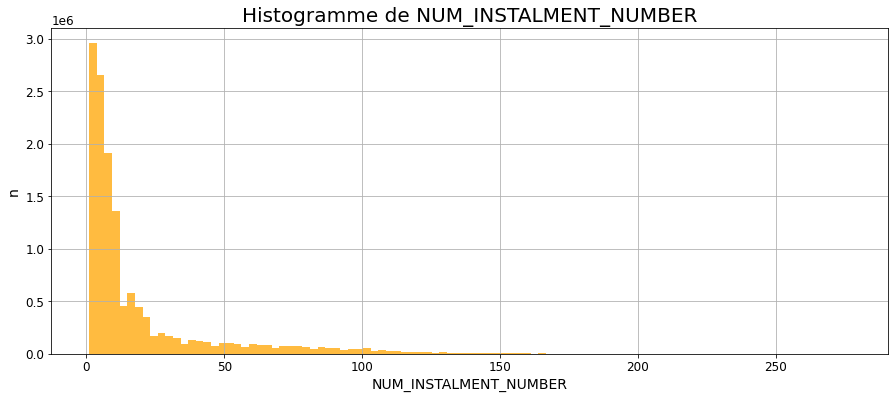

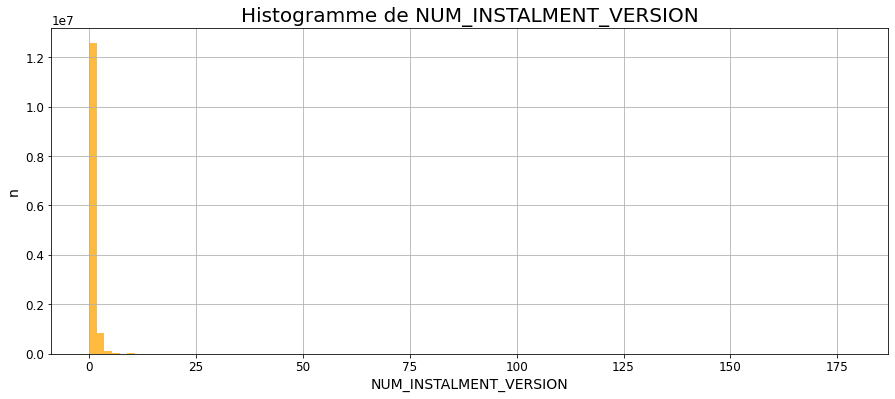

df_POS_CASH_balance
-------------------
num_cols = ['SK_DPD', 'SK_DPD_DEF', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
num_cols = ['SK_DPD', 'SK_DPD_DEF', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']


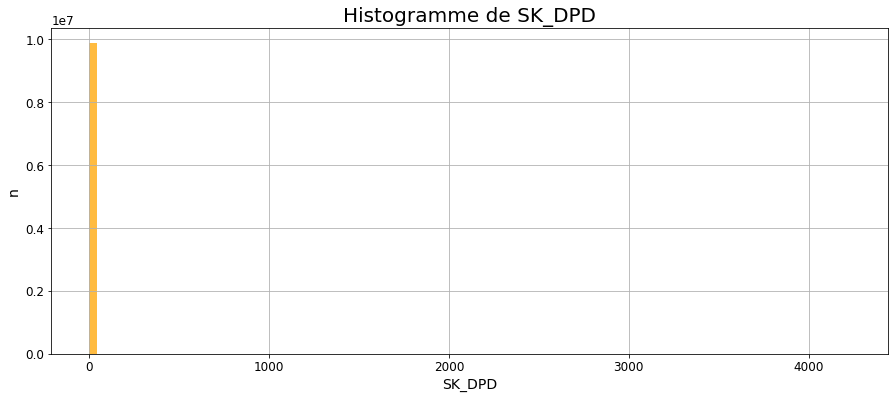

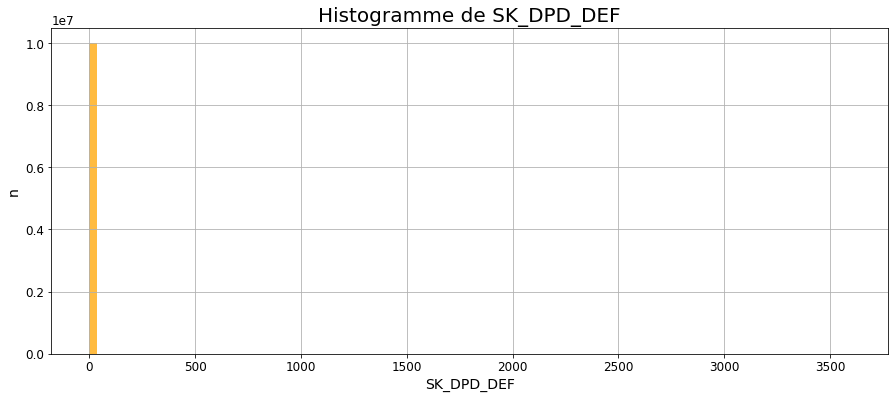

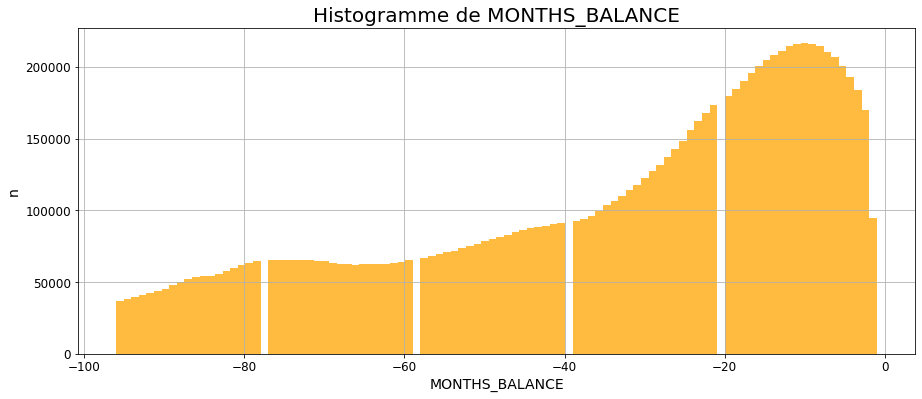

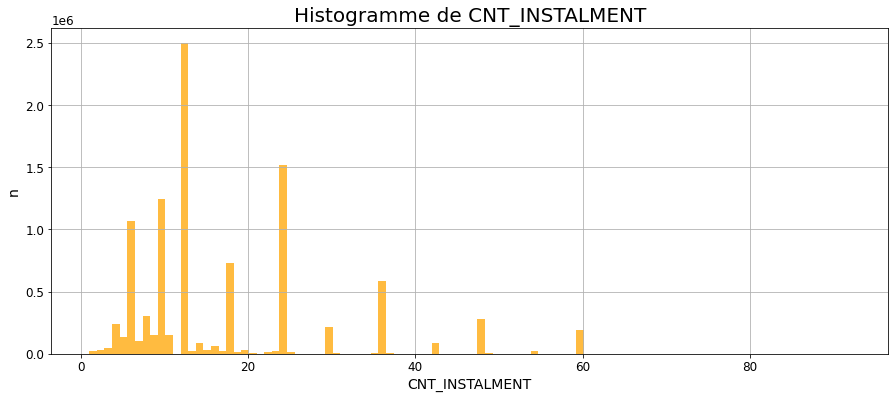

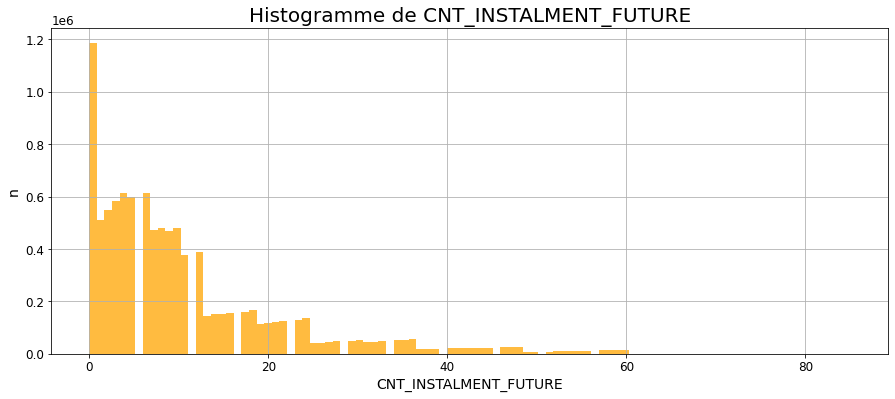

df_previous_application
-----------------------
num_cols = ['CNT_PAYMENT', 'AMT_ANNUITY', 'AMT_APPLICATION', 'RATE_INTEREST_PRIVILEGED', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'AMT_CREDIT', 'DAYS_TERMINATION', 'RATE_DOWN_PAYMENT', 'HOUR_APPR_PROCESS_START', 'AMT_GOODS_PRICE', 'NFLAG_INSURED_ON_APPROVAL', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_INTEREST_PRIMARY', 'DAYS_LAST_DUE', 'DAYS_FIRST_DRAWING', 'AMT_DOWN_PAYMENT', 'DAYS_FIRST_DUE']
num_cols = ['CNT_PAYMENT', 'AMT_ANNUITY', 'AMT_APPLICATION', 'RATE_INTEREST_PRIVILEGED', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'AMT_CREDIT', 'DAYS_TERMINATION', 'RATE_DOWN_PAYMENT', 'HOUR_APPR_PROCESS_START', 'AMT_GOODS_PRICE', 'NFLAG_INSURED_ON_APPROVAL', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_INTEREST_PRIMARY', 'DAYS_LAST_DUE', 'DAYS_FIRST_DRAWING', 'AMT_DOWN_PAYMENT', 'DAYS_FIRST_DUE']


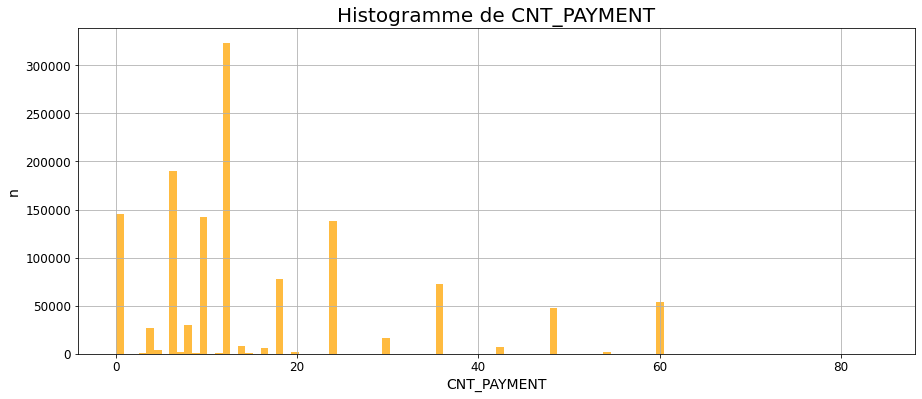

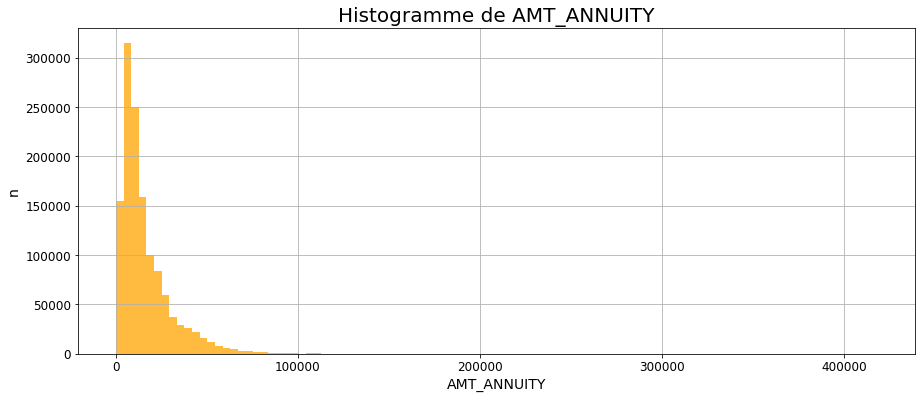

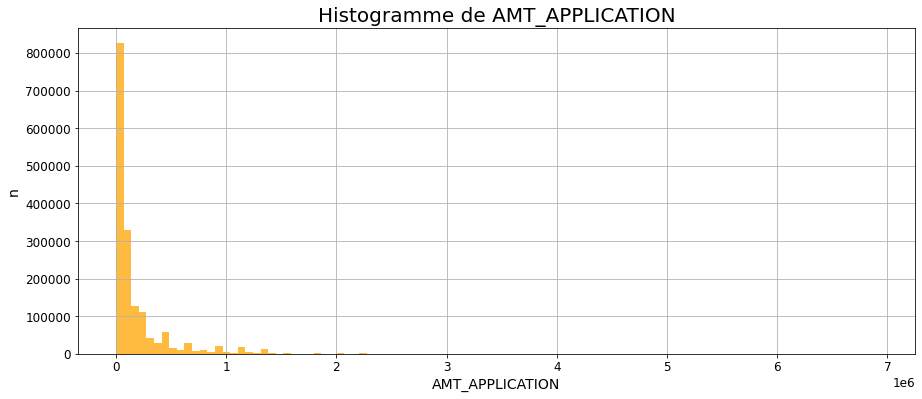

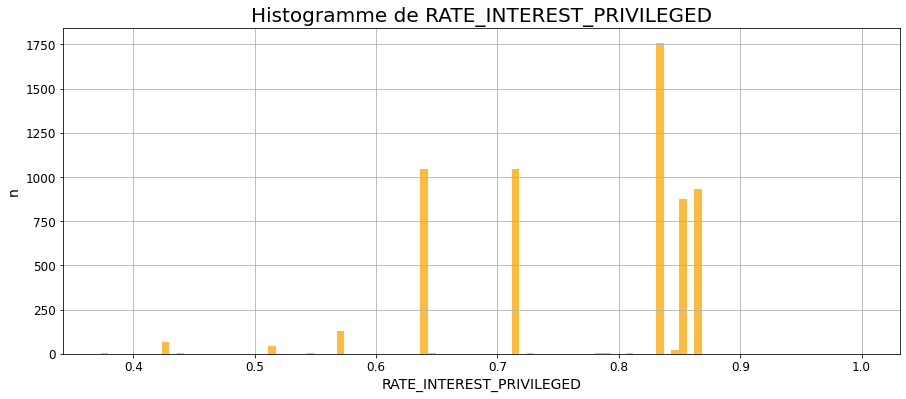

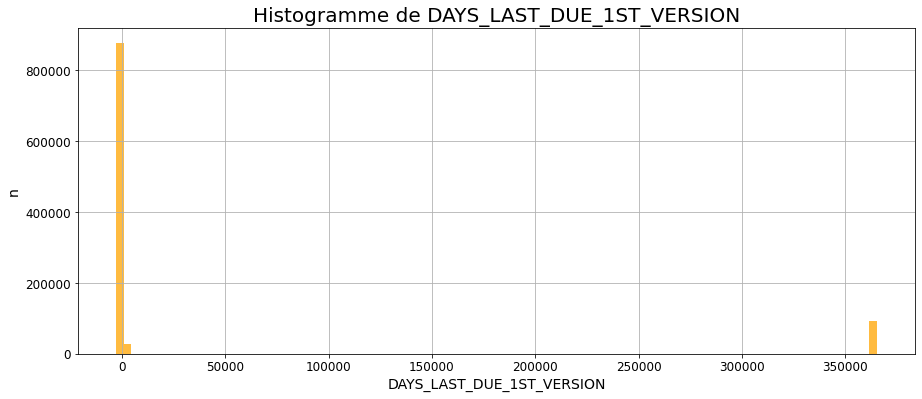

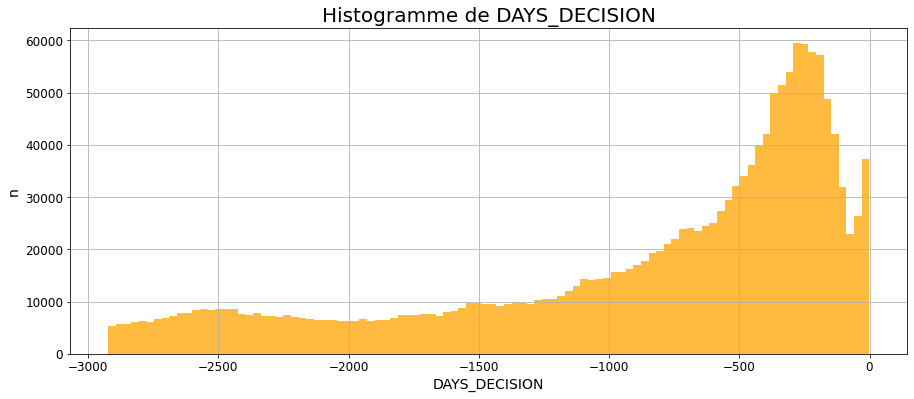

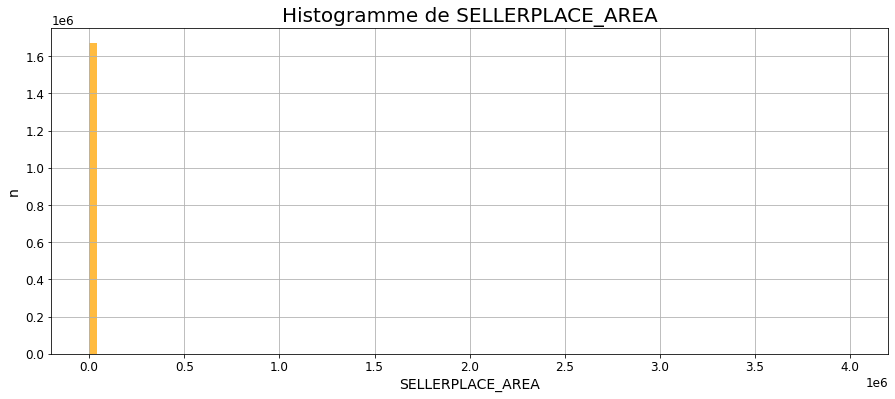

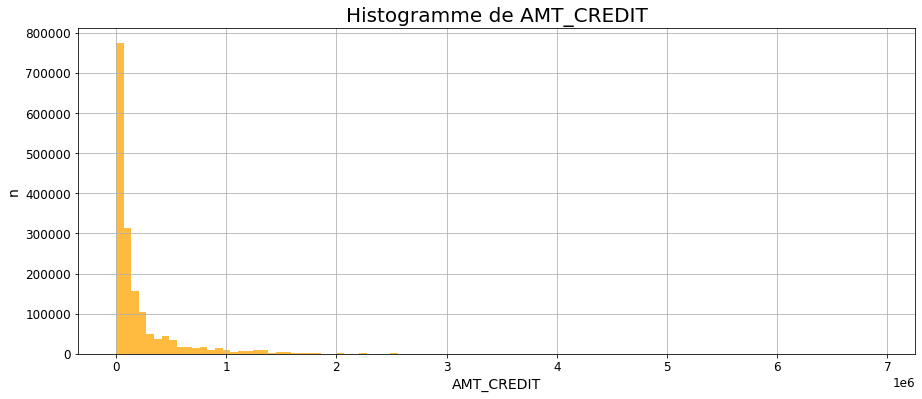

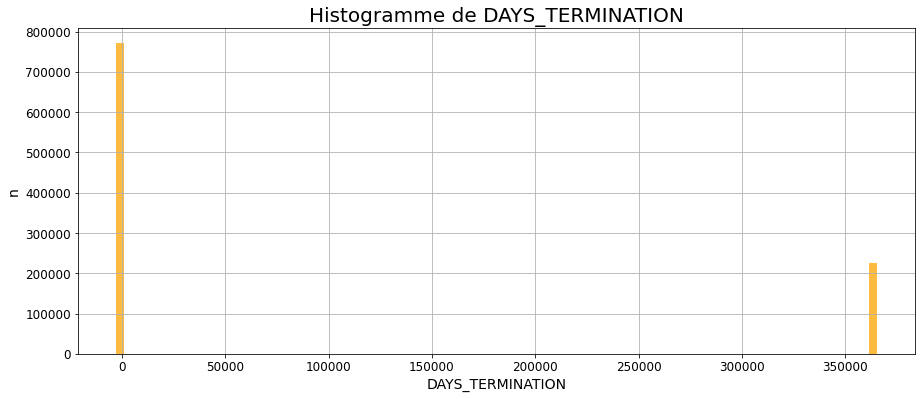

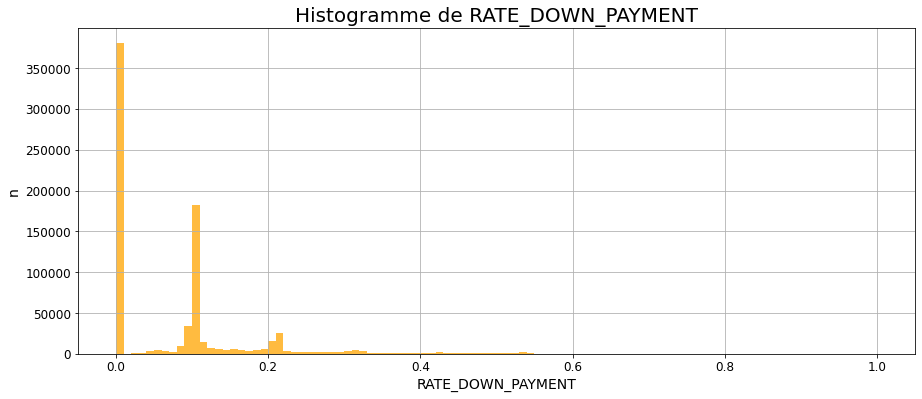

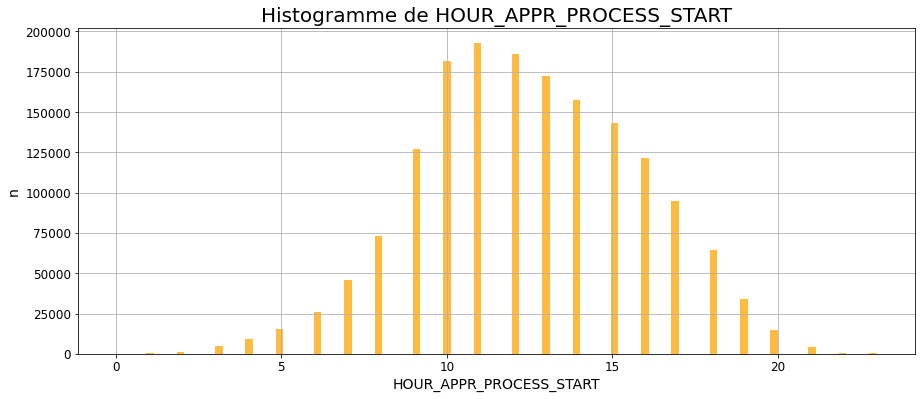

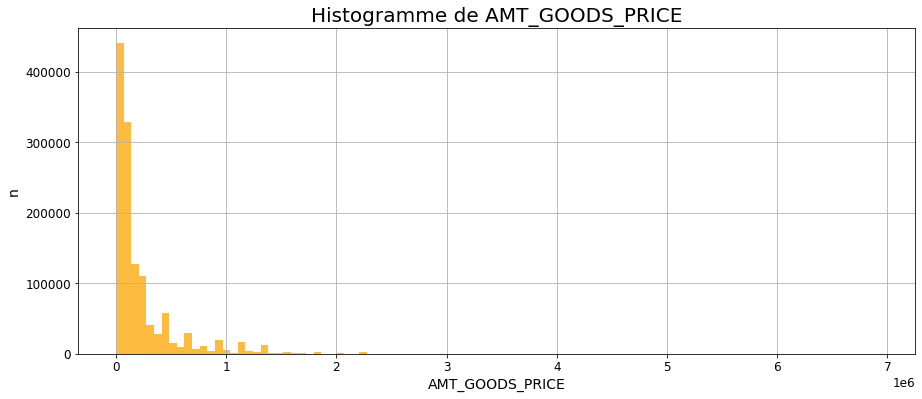

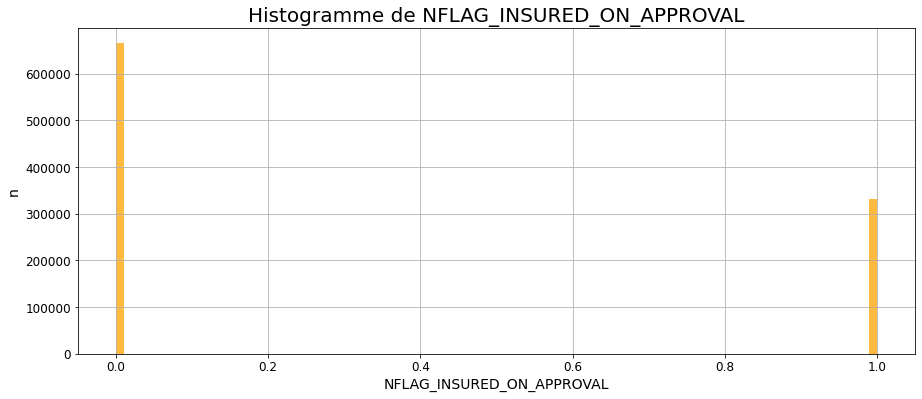

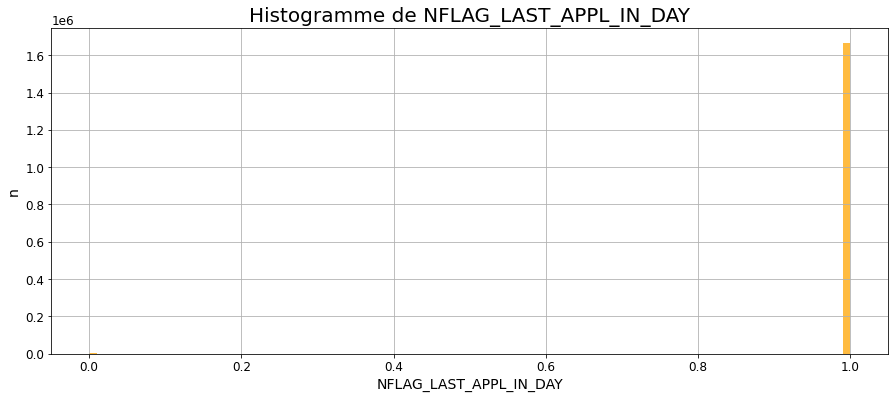

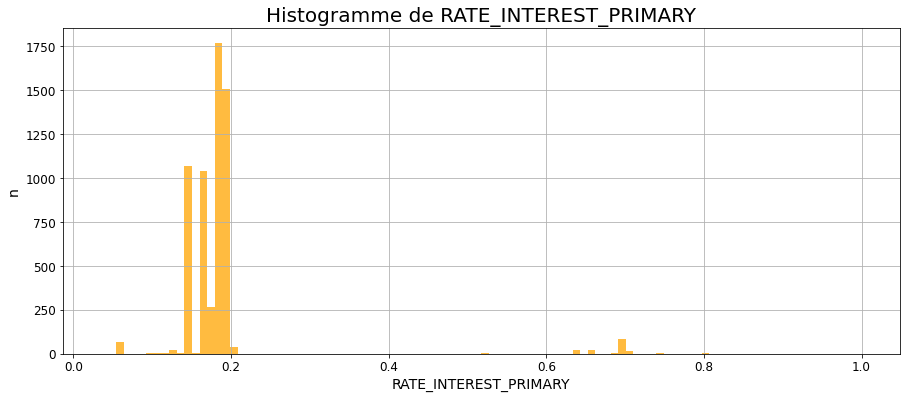

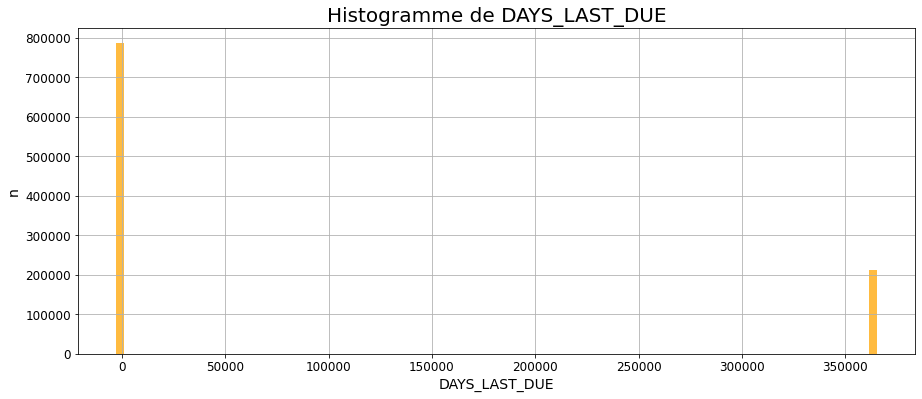

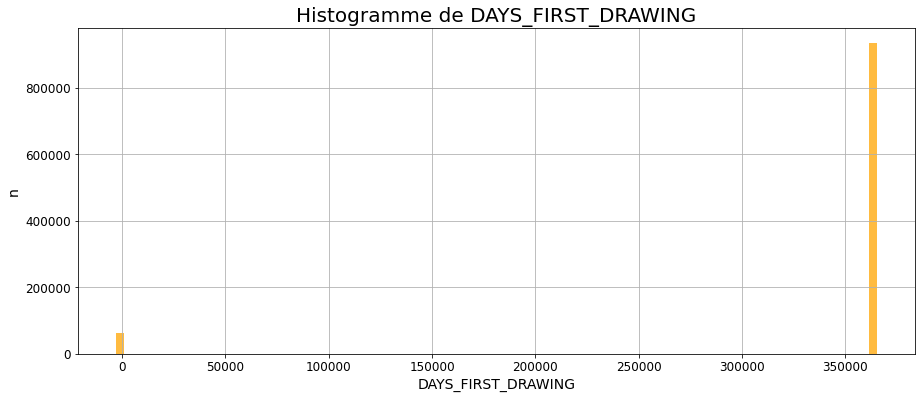

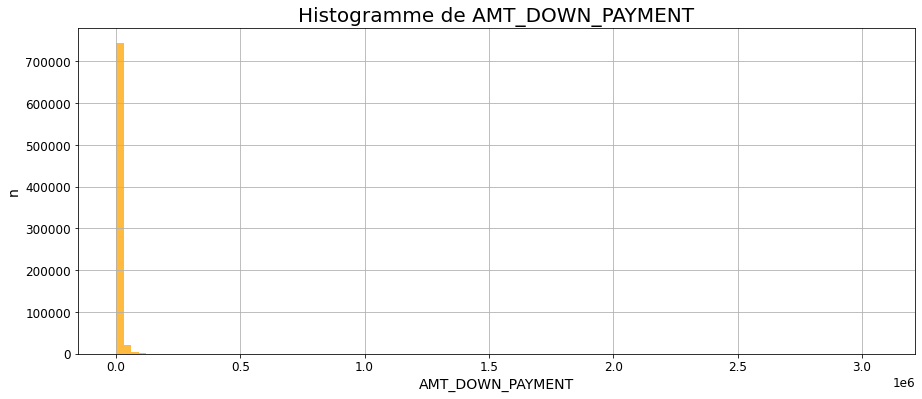

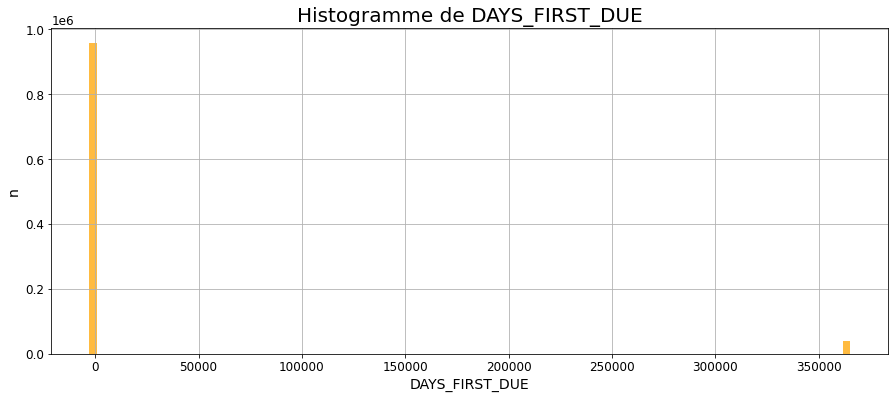

In [605]:
if DISPLAY_EDA_GRAPHS :
    for df, df_name in [[df_application_train, 'df_application_train'],
                        # [df_application_test, 'df_application_test'],
                        [df_bureau, 'df_bureau'],
                        [df_bureau_balance, 'df_bureau_balance'],
                        [df_credit_card_balance, 'df_credit_card_balance'],
                        [df_installments_payments, 'df_installments_payments'],
                        [df_POS_CASH_balance, 'df_POS_CASH_balance'],
                        [df_previous_application, 'df_previous_application']]:

        print(bcolors.BOLD+bcolors.HEADER+df_name+'\n'+'-'*len(df_name)+bcolors.ENDC)
        cat_cols = [col for col in df.columns if df[col].dtype == 'object']
        num_cols = list(set(df.columns) - set(cat_cols) - set(['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU', 'TARGET']))
        feat_cols = num_cols + cat_cols
        all_cols = feat_cols + [target_col]

        n = len(cat_cols)
        print(f"num_cols = {num_cols}")
        print(f"num_cols = {num_cols}")
        DisplotData.plot_distrib(df, num_cols, nbins=100)

In [606]:
df_application_train['FLAG_OWN_REALTY'].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

Text(0.5, 1.0, 'True labels (%)')

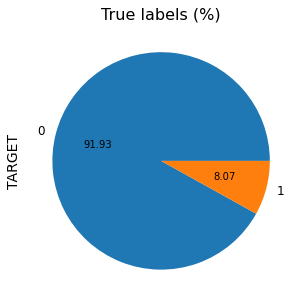

In [607]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig = plt.figure()
df_application_train['TARGET'].value_counts().plot(kind='pie', autopct='%.2f')
plt.title("True labels (%)")

### Etudes bivariées

### Etudes multivariées 

#### ACP de visu

In [87]:
selected_features_file = data_dir+'selected_features.csv'
selected_features = read_feature_selection(selected_features_file, min_level=3)
selected_features.head()

Column1                         Table                 Row  \
0        1  application_{train|test}.csv          SK_ID_CURR   
1        2  application_{train|test}.csv              TARGET   
2        5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3        6  application_{train|test}.csv         CODE_GENDER   
4        7  application_{train|test}.csv        FLAG_OWN_CAR   

                              Traduction description  Non-relaxable  Interet  \
0                  ID de pret dans notre echantillon              0        3   
1  Variable cible (1 - Client avec difficultes de...              0        3   
2    Identification si le pret est cash ou revolving              1        3   
3                                     Sexe du client              1        3   
4              Flag Si le client possede une voiture              1        3   

                  Commentaire interet Operations  \
0                                 NaN        NaN   
1                                 NaN        NaN   
2  Revolving = plutet surendettatoire     [mean]   
3                               LGBM2        NaN   
4                                 NaN        NaN   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [88]:
df_prep, cat_cols, num_cols = preprocess(selected_features=selected_features, num_rows=100000)

Train samples: 100000, test samples: 48744
Bureau df shape: (305811, 60)
Process bureau and bureau_balance - done in 13s
Previous applications df shape: (338858, 45)
Process previous_applications - done in 6s
Pos-cash balance df shape: (337252, 4)
Process POS-CASH balance - done in 3s
Installments payments df shape: (339587, 7)
Process installments payments - done in 2s
Credit card balance df shape: (103558, 20)
Process credit card balance - done in 3s
create_cnt_payment: train score = 0.940
create_cnt_payment: test score  = 0.830
Create new variables - done in 8s


In [89]:
acp_df = df_prep[df_prep['TARGET'].notnull()].copy()
acp_df = acp_df.dropna(axis=0)
del(df_prep)

In [90]:
# On ne retient que les colonnes numériques continues

In [91]:
# cols = [col for col in acp_df.columns if acp_df[col].dtype!='object']
cols = [col for col in acp_df.columns if '_NR' not in col]
acp_df = acp_df[cols]

In [92]:
acp_df

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
262        100302     0.0          180000.0    187704.0       9256.5   
427        100493     0.0          270000.0   1288350.0      41692.5   
2925       103411     0.0          202500.0   2085120.0      72607.5   
3129       103657     0.0          225000.0    817560.0      29362.5   
3905       104565     0.0          216000.0    820453.5      34893.0   
...           ...     ...               ...         ...          ...   
96889      212474     0.0          450000.0    225000.0      12343.5   
97551      213267     0.0          126000.0   1350000.0      39474.0   
98438      214288     0.0          337500.0    809136.0      44023.5   
99727      215776     1.0          315000.0   1096020.0      56092.5   
99919      216003     0.0          202500.0    180000.0       9319.5   

       AMT_GOODS_PRICE  DAYS_BIRTH  DAYS_EMPLOYED  EXT_SOURCE_2  EXT_SOURCE_3  \
262           148500.0       -9105         -482.0      0.479431      0.051682   
427          1125000.0      -18651        -2593.0      0.692166      0.349055   
2925         1800000.0      -18612         -942.0      0.552606      0.365617   
3129          675000.0      -11133        -1159.0      0.701342      0.355639   
3905          652500.0      -21216        -3641.0      0.369157      0.644679   
...                ...         ...            ...           ...           ...   
96889         225000.0       -8991        -1327.0      0.531907      0.549597   
97551        1350000.0      -14286        -1560.0      0.621793      0.326475   
98438         643500.0      -18124         -592.0      0.515818      0.125308   
99727         900000.0      -14217        -2190.0      0.544488      0.151008   
99919         180000.0      -20935        -1708.0      0.539701      0.492060   

       DAYS_EMPLOYED_PERC  INCOME_CREDIT_PERC  INCOME_PER_PERSON  \
262              0.052938            0.958957            90000.0   
427              0.139027            0.209570           135000.0   
2925             0.050613            0.097117           202500.0   
3129             0.104105            0.275209            75000.0   
3905             0.171616            0.263269           108000.0   
...                   ...                 ...                ...   
96889            0.147592            2.000000           225000.0   
97551            0.109198            0.093333            42000.0   
98438            0.032664            0.417112           168750.0   
99727            0.154041            0.287404            63000.0   
99919            0.081586            1.125000           202500.0   

       ANNUITY_INCOME_PERC  PAYMENT_RATE  BURO%DAYS_CREDIT#MAX  \
262               0.051425      0.049314                 -72.0   
427               0.154417      0.032361                -222.0   
2925              0.358556      0.034822                -462.0   
3129              0.130500      0.035915                 -89.0   
3905              0.161542      0.042529                 -68.0   
...                    ...           ...                   ...   
96889             0.027430      0.054860                -191.0   
97551             0.313286      0.029240                -175.0   
98438             0.130440      0.054408                -218.0   
99727             0.178071      0.051178                -345.0   
99919             0.046022      0.051775                 -71.0   

       BURO%AMT_CREDIT_SUM_LIMIT#MEAN  BURO%AMT_ANNUITY#MEAN  \
262                       5118.075000            3562.232727   
427                       1520.330625            5390.437500   
2925                      6438.382500           13912.312500   
3129                      6529.167000           25974.765000   
3905                         0.000000            5668.233750   
...                               ...                    ...   
96889                        0.000000            7531.605000   
97551                    26784.685000          

In [93]:
from sklearn.decomposition import PCA

In [94]:
X_train_pca = acp_df[cols].drop(['TARGET'], axis=1)
y = acp_df[['TARGET']]

# Centrage et Réduction
std_scale = StandardScaler().fit(X_train_pca)
X_train_pca_scaled = std_scale.transform(X_train_pca)
# Calcul des composantes principales
pca = PCA(n_components=2)
pca.fit(X_train_pca_scaled)
X_train_pca_proj = pca.transform(X_train_pca_scaled)
# DataFrame
# X_train_pca_proj = pd.DataFrame(X_train_pca_proj,index=X_train_pca.index)


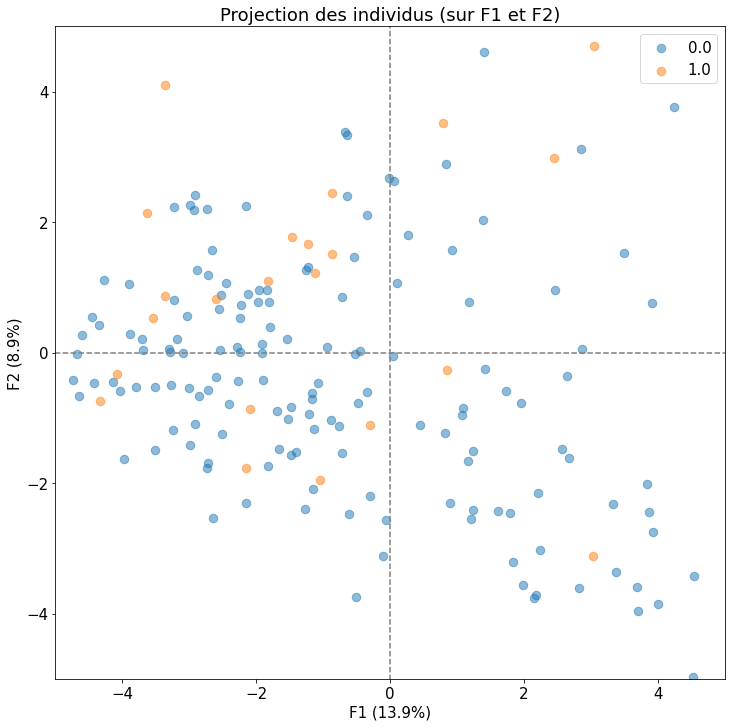

In [95]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
illustrative_var = [str(val[0]) for val in y.values]
DisplotML.display_factorial_planes(X_train_pca_proj, 2, pca, [(0,1)], alpha=0.5, labels=None,
                                   marker='o', s=72 , illustrative_var=illustrative_var,
                                   xlim=[-5.,5.], ylim=[-5.,5.]
                                  )
plt.show()

On a un "overlapping" a priori assez important, mais difficile de conclure sur une ACP. Une régression logistique n'est a priori pas applicable, mais elle ne coûte pas grand en temps d'exécution, on la mettra dans le plan de tests. 